<a href="https://colab.research.google.com/github/buihanhtrang/NCKH_UTG_2024/blob/master/NCKH_Final(Code).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ICHST-2023/Ver2

[Errno 2] No such file or directory: '/content/drive/MyDrive/ICHST-2023/Ver2'
/content


In [ ]:
!pwd

/content


#1 Library

In [ ]:
import pandas as pd
import numpy as np

#Display
import matplotlib.pyplot as plt
import seaborn as sns

#Implement models
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn import svm
from sklearn.utils.fixes import loguniform
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier

#2 Data Prepration

##2.1. Đổi tên cột

Tên cột

In [ ]:
columns = [
    'record_ID',
    'Event_Name',
    'age',  #Demographics
    'ngay_vao_vien',
    'name',
    'ma_nghien_cuu',
    'gender', #Demographics
    'height',
    'weight',
    'bmi',
    # D1. Xét nghiệm huyết học, sinh hóa máu:
    'red_blood_cell',
    'white_blood_cell',
    'platelets',             #Tieu cau
    'INR',
    'prothrombin',
    'AST',
    'ALT',
    'GGT',
    'total_bilirubin',
    'indirect_bilirubin',
    'albumin',
    'ure',
    'creatinin',
    'blood_type',
    'cholesterol',
    'triglyceride',
    'HDL-C',
    'LDL-C',
    'glucose',
    'HbA1C',
    'HbsAg',
    'AntiHCV',
    'CEA',
    'Alpha_FP',
    'PIVKA-II',
    'CA_19_9',

    # D2. Các chỉ số đánh giá mức độ xơ hóa phi xâm lấn:
    'APRI',
    'AST/ALT',
    'FIB-4',
    'NFS',       # (Điểm số xơ hóa NAFLD)
    'BARD',      # Điểm BARD

    # cac thong so khac
    'D3',
    'D4',
    'Varice',
    'Ket_qua_dac_biet',
    'D5',
    'ket_qua',
    # ket qua
    'benh_gan',
    'viem_gan',
    'ung_thu_gan',
    'icd_khac',
    'check'
]

### xóa các cột (trong D3. Triệu chứng chuyển hóa) và Event_Name

In [ ]:
columns_to_drop = [
    'Event_Name',
    'D3',
    'D4',
    'Varice',
    'Ket_qua_dac_biet',
    'D5',
    'ket_qua'
]

In [ ]:
dataRaw = pd.read_csv('https://drive.google.com/uc?id=1DH7boUGaR1qbOy9EVKc-P8kFRqHkjH3D', names=columns, header=None)
dataRaw.drop(index = 0, axis = 0, inplace = True)
dataRaw.drop(columns = columns_to_drop, axis = 1, inplace = True)

In [ ]:
dataRaw['class'] = np.where(
                            ((dataRaw['check']=='Hoàn thành')
                            & (dataRaw['benh_gan'].isnull())
                            & (dataRaw['viem_gan'].isnull())
                            & (dataRaw['ung_thu_gan'].isnull())
                            & (dataRaw['icd_khac'].isnull())),

                            '0', np.where(
                                ((dataRaw['benh_gan'].notnull())
                                | (dataRaw['viem_gan'].notnull())
                                | (dataRaw['ung_thu_gan'].notnull())
                                | (dataRaw['icd_khac'].notnull())),
                                '1','2')
                            )

In [ ]:
dataRaw['class'].value_counts()

class
1    153
2     35
0      5
Name: count, dtype: int64

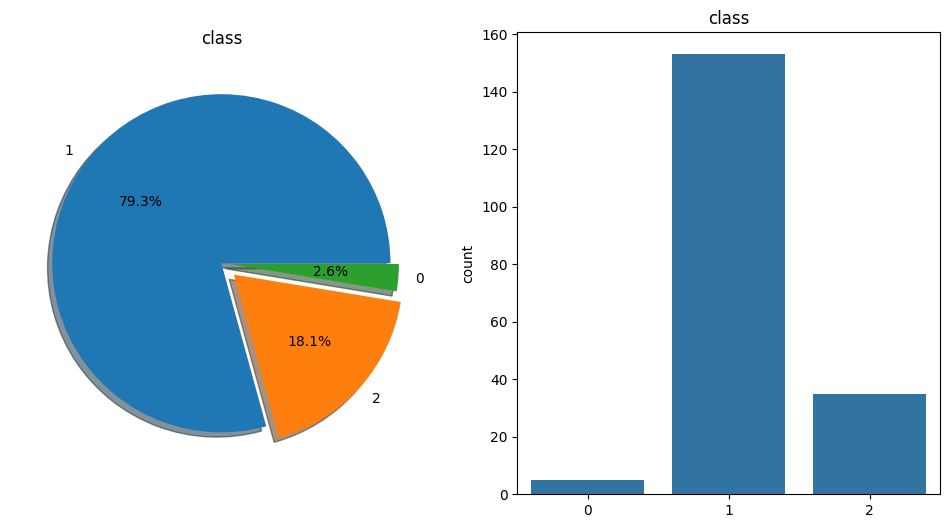

class
1    153
2     35
0      5
Name: count, dtype: int64

In [ ]:
f, ax=plt.subplots(
    1,
    2,
    figsize=(12,6)
)

dataRaw['class'].value_counts().plot.pie(
    explode=[0,0.1,0.05],
    autopct='%1.1f%%',
    ax=ax[0],
    shadow=True
)

ax[0].set_title('class')
ax[0].set_ylabel('')

sns.countplot(
    x='class',
    data=dataRaw,ax=ax[1]
)

ax[1].set_title('class')
ax[1].set_xlabel('')
plt.show()
dataRaw['class'].value_counts()

In [ ]:
dataRaw.drop(dataRaw.loc[dataRaw['class'] == '2'].index, inplace = True)

In [ ]:
dataRaw['class'].value_counts()

class
1    153
0      5
Name: count, dtype: int64

##2.2. Thống kê ICD

In [ ]:
ma_icd = dataRaw[['benh_gan', 'viem_gan', 'ung_thu_gan', 'icd_khac']].copy()

In [ ]:
ma_icd['benh_gan'].value_counts()

benh_gan
Các bệnh gan khác                                    6
Xơ gan và xơ gan                                     4
Viêm gan mạn tính, chưa được phân loại ở nơi khác    1
Name: count, dtype: int64

In [ ]:
ma_icd['viem_gan'].value_counts()

viem_gan
Viêm gan siêu vi B                  4
Viêm gan siêu vi, không xác định    2
Viêm gan siêu vi cấp tính khác      1
Name: count, dtype: int64

In [ ]:
ma_icd['ung_thu_gan'].value_counts()

ung_thu_gan
U ác của gan và đường mật trong gan    21
Name: count, dtype: int64

In [ ]:
ma_icd['icd_khac'].value_counts()

icd_khac
C220     71
C25.0    13
C163      7
C18.4     3
C24.0     3
C162      3
C169      2
C165      2
K831      2
C22.1     2
K80.3     1
C17.0     1
C25.4     1
I10       1
C25.2     1
C168      1
C18.7     1
K91.3     1
C16.9     1
K632      1
C221      1
K83.1     1
C18       1
I829      1
C18.3     1
K56.6     1
C25       1
C25.9     1
C25.1     1
C19       1
E11       1
J91       1
C16       1
K913      1
C16.3     1
Name: count, dtype: int64

In [ ]:
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C220', 'U ác của gan và đường mật trong gan')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C25.0', 'U ác tuỵ')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C163', 'U ác của dạ dày')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C16.3', 'U ác của dạ dày')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C24.0', 'U ác của phần khác và không xác định của đường mật')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C18.4', 'U ác đại tràng')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C169', 'U ác của dạ dày')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C16.9', 'U ác của dạ dày')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C162', 'U ác của dạ dày')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C165', 'U ác của dạ dày')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C22.1', 'U ác của gan và đường mật trong gan')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('K831', 'Bệnh khác của đường mật')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('K632', 'Bệnh khác của ruột')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('K80.3', 'Sỏi mật')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C25.4', 'U ác tuỵ')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C17.0', 'U ác ruột non')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C18', 'U ác đại tràng')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('I10', 'Tăng huyết áp vô căn (nguyên phát)')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C25.2', 'U ác tuỵ')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C18.7', 'U ác đại tràng')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('K83.1', 'Bệnh khác của đường mật')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C18.3', 'U ác đại tràng')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('I829', 'Các thuyên tắc và huyết khối tĩnh mạch khác')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C221', 'U ác của gan và đường mật trong gan')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('K56.6', 'Liệt ruột và tắc ruột không có thoát vị')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C25', 'U ác tuỵ')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C25.9', 'U ác tuỵ')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C25.1', 'U ác tuỵ')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C19', 'U ác của nơi nối trực tràng-xích ma')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('E11', 'Bệnh đái tháo đường không phụ thuộc insuline type 2')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('J91', 'Tràn dịch màng phổi trong bệnh phân loại nơi khác')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C16', 'U ác của dạ dày')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('K913', 'Rối loạn tiêu hoá sau phẫu thuật không phân loại nơi khác')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('K91.3', 'Rối loạn tiêu hoá sau phẫu thuật không phân loại nơi khác')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace('C168', 'U ác của dạ dày')

In [ ]:
ma_icd['icd_khac'].value_counts()

icd_khac
U ác của gan và đường mật trong gan                          74
U ác của dạ dày                                              18
U ác tuỵ                                                     18
U ác đại tràng                                                6
Bệnh khác của đường mật                                       3
U ác của phần khác và không xác định của đường mật            3
Rối loạn tiêu hoá sau phẫu thuật không phân loại nơi khác     2
Tràn dịch màng phổi trong bệnh phân loại nơi khác             1
Bệnh đái tháo đường không phụ thuộc insuline type 2           1
U ác của nơi nối trực tràng-xích ma                           1
Liệt ruột và tắc ruột không có thoát vị                       1
Các thuyên tắc và huyết khối tĩnh mạch khác                   1
Bệnh khác của ruột                                            1
Sỏi mật                                                       1
U ác ruột non                                                 1
Tăng huyết áp vô căn (nguyên ph

In [ ]:
ma_icd

benh_gan viem_gan                          ung_thu_gan icd_khac
1                  NaN      NaN                                  NaN      NaN
2                  NaN      NaN  U ác của gan và đường mật trong gan      NaN
3                  NaN      NaN                                  NaN      NaN
4                  NaN      NaN                                  NaN      NaN
5                  NaN      NaN  U ác của gan và đường mật trong gan      NaN
..                 ...      ...                                  ...      ...
187                NaN      NaN  U ác của gan và đường mật trong gan      NaN
188  Các bệnh gan khác      NaN                                  NaN      NaN
189  Các bệnh gan khác      NaN  U ác của gan và đường mật trong gan      NaN
191                NaN      NaN                                  NaN      NaN
193                NaN      NaN                                  NaN      NaN

[158 rows x 4 columns]

In [ ]:
#gộp bệnh
ma_icd['benh_gan'] = ma_icd['benh_gan'].replace(np.nan, '')
ma_icd['viem_gan'] = ma_icd['viem_gan'].replace(np.nan, '')
ma_icd['ung_thu_gan'] = ma_icd['ung_thu_gan'].replace(np.nan, '')
ma_icd['icd_khac'] = ma_icd['icd_khac'].replace(np.nan, '')

ma_icd['final'] = ma_icd['benh_gan'] + ' ' + ma_icd['viem_gan'] + ' ' + ma_icd['ung_thu_gan'] + ' ' + ma_icd['icd_khac']
ma_icd['final'] = ma_icd['final'].str.replace(r'\s+', ' ', regex=True)
ma_icd['final'] = ma_icd['final'].str.strip()

In [ ]:
ma_icd.head(15)

benh_gan viem_gan                          ung_thu_gan  \
1                                                                    
2                              U ác của gan và đường mật trong gan   
3                                                                    
4                                                                    
5                              U ác của gan và đường mật trong gan   
6   Xơ gan và xơ gan                                                 
7                              U ác của gan và đường mật trong gan   
27                                                                   
29                                                                   
30                                                                   
31                                                                   
32                                                                   
33                                                                   
34                                                                   
36                                                                   

                                             icd_khac  \
1                                                       
2                                                       
3                                                       
4                                                       
5                                                       
6                                                       
7                                                       
27                                    U ác của dạ dày   
29                                    U ác của dạ dày   
30                                    U ác của dạ dày   
31                                    U ác của dạ dày   
32  Rối loạn tiêu hoá sau phẫu thuật không phân lo...   
33                                    U ác của dạ dày   
34                                    U ác của dạ dày   
36                                     U ác đại tràng   

                                                final  
1                                                      
2                 U ác của gan và đường mật trong gan  
3                                                      
4                                                      
5                 U ác của gan và đường mật trong gan  
6                                    Xơ gan và xơ gan  
7                 U ác của gan và đường mật trong gan  
27                                    U ác của dạ dày  
29                                    U ác của dạ dày  
30                                    U ác của dạ dày  
31                                    U ác của dạ dày  
32  Rối loạn tiêu hoá sau phẫu thuật không phân lo...  
33                                    U ác của dạ dày  
34                                    U ác của dạ dày  
36                                     U ác đại tràng

In [ ]:
ma_icd['final'] = ma_icd['final'].replace('', 'Không bệnh')
ma_icd['final'].value_counts()

final
U ác của gan và đường mật trong gan                                                                         84
U ác của dạ dày                                                                                             18
U ác tuỵ                                                                                                    16
U ác đại tràng                                                                                               6
Không bệnh                                                                                                   5
U ác của phần khác và không xác định của đường mật                                                           3
Các bệnh gan khác U ác của gan và đường mật trong gan                                                        2
Rối loạn tiêu hoá sau phẫu thuật không phân loại nơi khác                                                    2
Các bệnh gan khác Viêm gan siêu vi, không xác định U ác của gan và đường mật trong gan                    

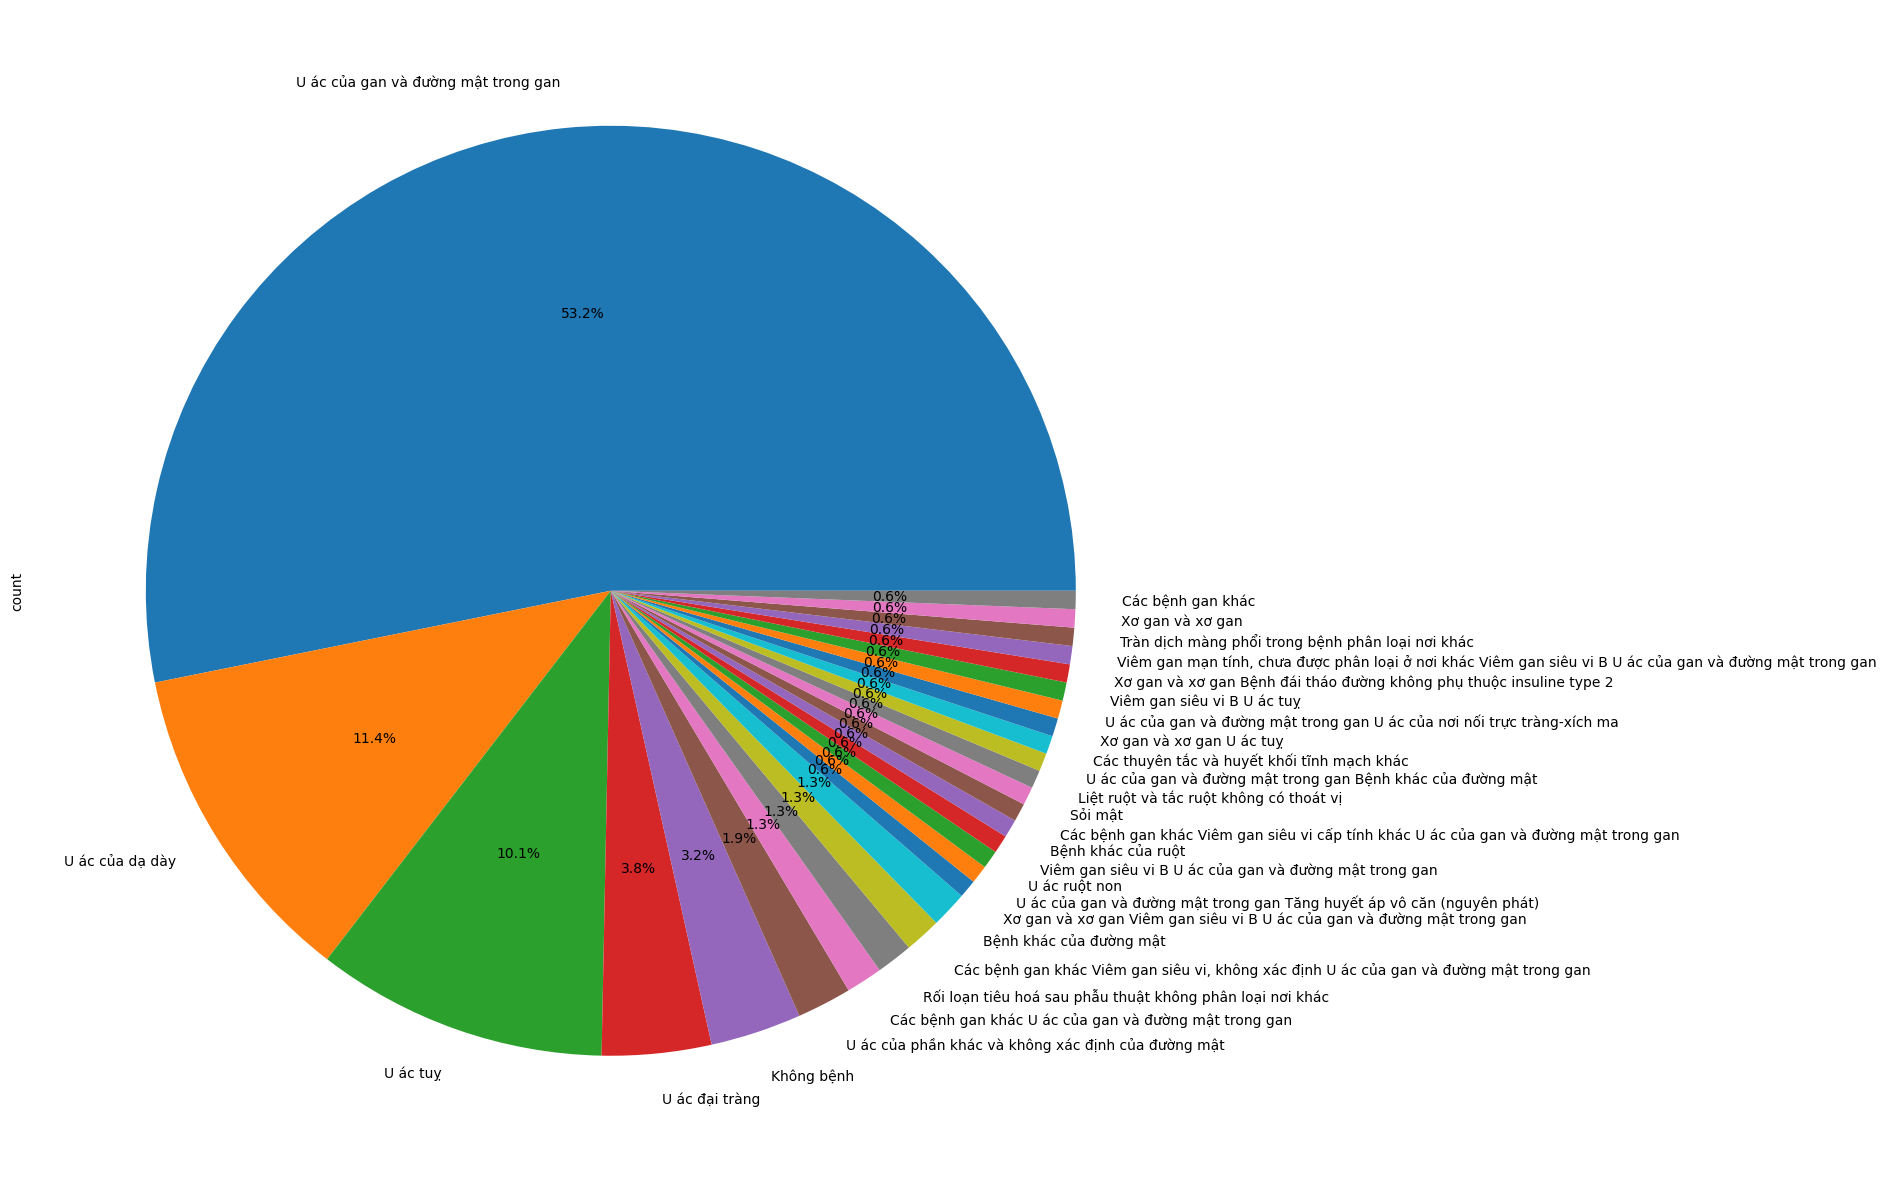

In [ ]:
plt.figure(figsize=(15, 16))

ma_icd['final'].value_counts().plot.pie(
    autopct='%1.1f%%'
)

plt.show()


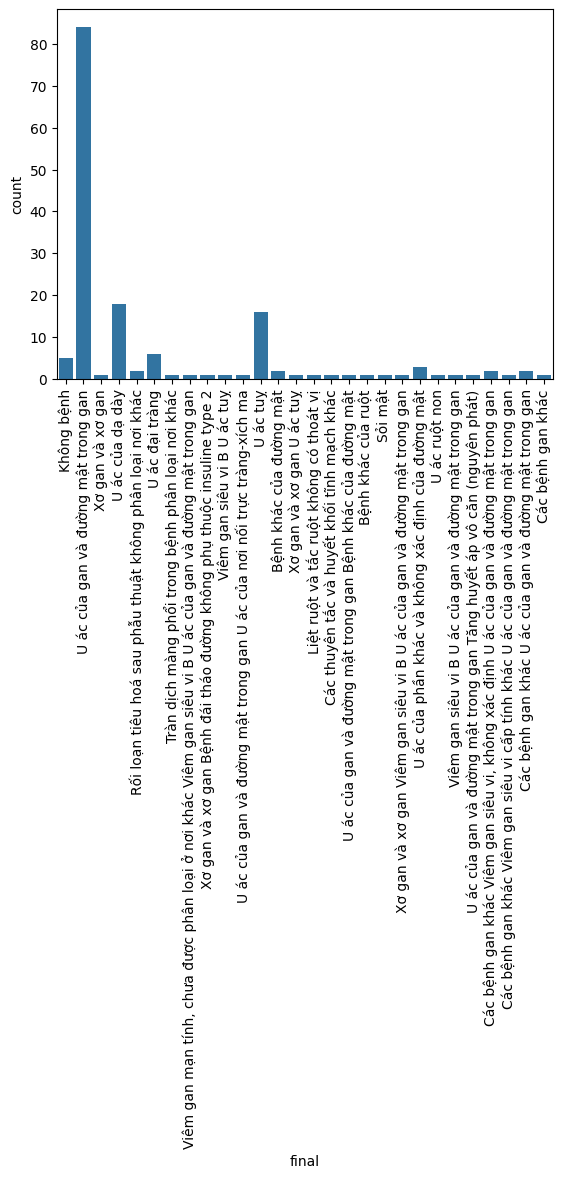

In [ ]:
sns.countplot(
    x='final',
    data=ma_icd,
    orient='h'
)
# Điều chỉnh góc quay của chữ (ví dụ 90 độ)
plt.xticks(rotation=90)

# Hiển thị biểu đồ
plt.show()

In [ ]:
ma_icd

benh_gan viem_gan                          ung_thu_gan icd_khac  \
1                                                                               
2                                U ác của gan và đường mật trong gan            
3                                                                               
4                                                                               
5                                U ác của gan và đường mật trong gan            
..                 ...      ...                                  ...      ...   
187                              U ác của gan và đường mật trong gan            
188  Các bệnh gan khác                                                          
189  Các bệnh gan khác           U ác của gan và đường mật trong gan            
191                                                                             
193                                                                             

                                                 final  
1                                           Không bệnh  
2                  U ác của gan và đường mật trong gan  
3                                           Không bệnh  
4                                           Không bệnh  
5                  U ác của gan và đường mật trong gan  
..                                                 ...  
187                U ác của gan và đường mật trong gan  
188                                  Các bệnh gan khác  
189  Các bệnh gan khác U ác của gan và đường mật tr...  
191                                         Không bệnh  
193                                         Không bệnh  

[158 rows x 5 columns]

In [ ]:
ma_icd['benh_gan(icd)'] =  ma_icd['benh_gan']
replacement_dict = {
    'Bệnh gan do rượu' : 'K70',
    'Bệnh gan độc' : 'K71',
    'Suy gan, chưa được phân loại ở nơi khác' : 'K72',
    'Viêm gan mạn tính, chưa được phân loại ở nơi khác' : 'K73',
    'Xơ gan và xơ gan' : 'K74',
    'Các bệnh viêm gan khác' : 'K75',
    'Các bệnh gan khác' : 'K76',
    'Rối loạn gan trong các bệnh phân loại ở nơi khác' : 'K77'
}
ma_icd['benh_gan(icd)'] = ma_icd['benh_gan(icd)'].replace(replacement_dict)


In [ ]:
ma_icd['benh_gan(icd)'].value_counts()

benh_gan(icd)
       147
K76      6
K74      4
K73      1
Name: count, dtype: int64

In [ ]:
ma_icd['viem_gan(icd)'] = ma_icd['viem_gan']
replacement_dict = {
    'Viêm gan cấp A' : 'B15',
    'Viêm gan siêu vi B' : 'B16',
    'Viêm gan siêu vi cấp tính khác' : 'B17',
    'Viêm gan siêu vi mạn tính' : 'B18',
    'Viêm gan siêu vi, không xác định' : 'B19'
}
ma_icd['viem_gan(icd)'] = ma_icd['viem_gan(icd)'].replace(replacement_dict)

In [ ]:
ma_icd['viem_gan(icd)'].value_counts()

viem_gan(icd)
       151
B16      4
B19      2
B17      1
Name: count, dtype: int64

In [ ]:
ma_icd['ung_thu_gan(icd)'] = ma_icd['ung_thu_gan']
replacement_dict = {
    'U ác của gan và đường mật trong gan' : 'C22'
}
ma_icd['ung_thu_gan(icd)'] = ma_icd['ung_thu_gan(icd)'].replace(replacement_dict)

In [ ]:
ma_icd['ung_thu_gan(icd)'].value_counts()

ung_thu_gan(icd)
       137
C22     21
Name: count, dtype: int64

In [ ]:
ma_icd['icd_khac(icd)'] = ma_icd['icd_khac']
replacement_dict = {
    'U ác của gan và đường mật trong gan' : 'C22',
    'U ác tuỵ' : 'C25',
    'U ác của dạ dày' : 'C16',
    'U ác của phần khác và không xác định của đường mật' : 'C24',
    'U ác đại tràng' : 'C18',
    'Bệnh khác của đường mật' : 'K83',
    'Bệnh khác của ruột' : 'K63',
    'Sỏi mật' : 'K80',
    'U ác ruột non' : 'C17',
    'Tăng huyết áp vô căn (nguyên phát)' : 'I10',
    'Các thuyên tắc và huyết khối tĩnh mạch khác' : 'I82',
    'Liệt ruột và tắc ruột không có thoát vị' : 'K56',
    'U ác của nơi nối trực tràng-xích ma' : 'C19',
    'Bệnh đái tháo đường không phụ thuộc insuline type 2' : 'E11',
    'Tràn dịch màng phổi trong bệnh phân loại nơi khác' : 'J91',
    'Rối loạn tiêu hoá sau phẫu thuật không phân loại nơi khác' : 'K91'
}
ma_icd['icd_khac(icd)'] = ma_icd['icd_khac(icd)'].replace(replacement_dict)

In [ ]:
ma_icd['icd_khac(icd)'].value_counts()

icd_khac(icd)
C22    74
       25
C25    18
C16    18
C18     6
C24     3
K83     3
K91     2
C19     1
E11     1
J91     1
K56     1
I82     1
K63     1
K80     1
C17     1
I10     1
Name: count, dtype: int64

In [ ]:
ma_icd['final(icd)'] = ma_icd['benh_gan(icd)'] + ' ' + ma_icd['viem_gan(icd)'] + ' ' + ma_icd['ung_thu_gan(icd)'] + ' ' + ma_icd['icd_khac(icd)']
ma_icd['final(icd)'] = ma_icd['final(icd)'].str.replace(r'\s+', ' ', regex=True)
ma_icd['final(icd)'] = ma_icd['final(icd)'].str.strip()
ma_icd['final(icd)'] = ma_icd['final(icd)'].replace('', 'Không bệnh')
ma_icd['final(icd)'].value_counts()

final(icd)
C22            84
C16            18
C25            16
C18             6
Không bệnh      5
C24             3
K76 C22         2
K91             2
K76 B19 C22     2
K83             2
K74 B16 C22     1
C22 I10         1
C17             1
B16 C22         1
K63             1
K76 B17 C22     1
K80             1
K56             1
C22 K83         1
I82             1
K74 C25         1
C22 C19         1
B16 C25         1
K74 E11         1
K73 B16 C22     1
J91             1
K74             1
K76             1
Name: count, dtype: int64

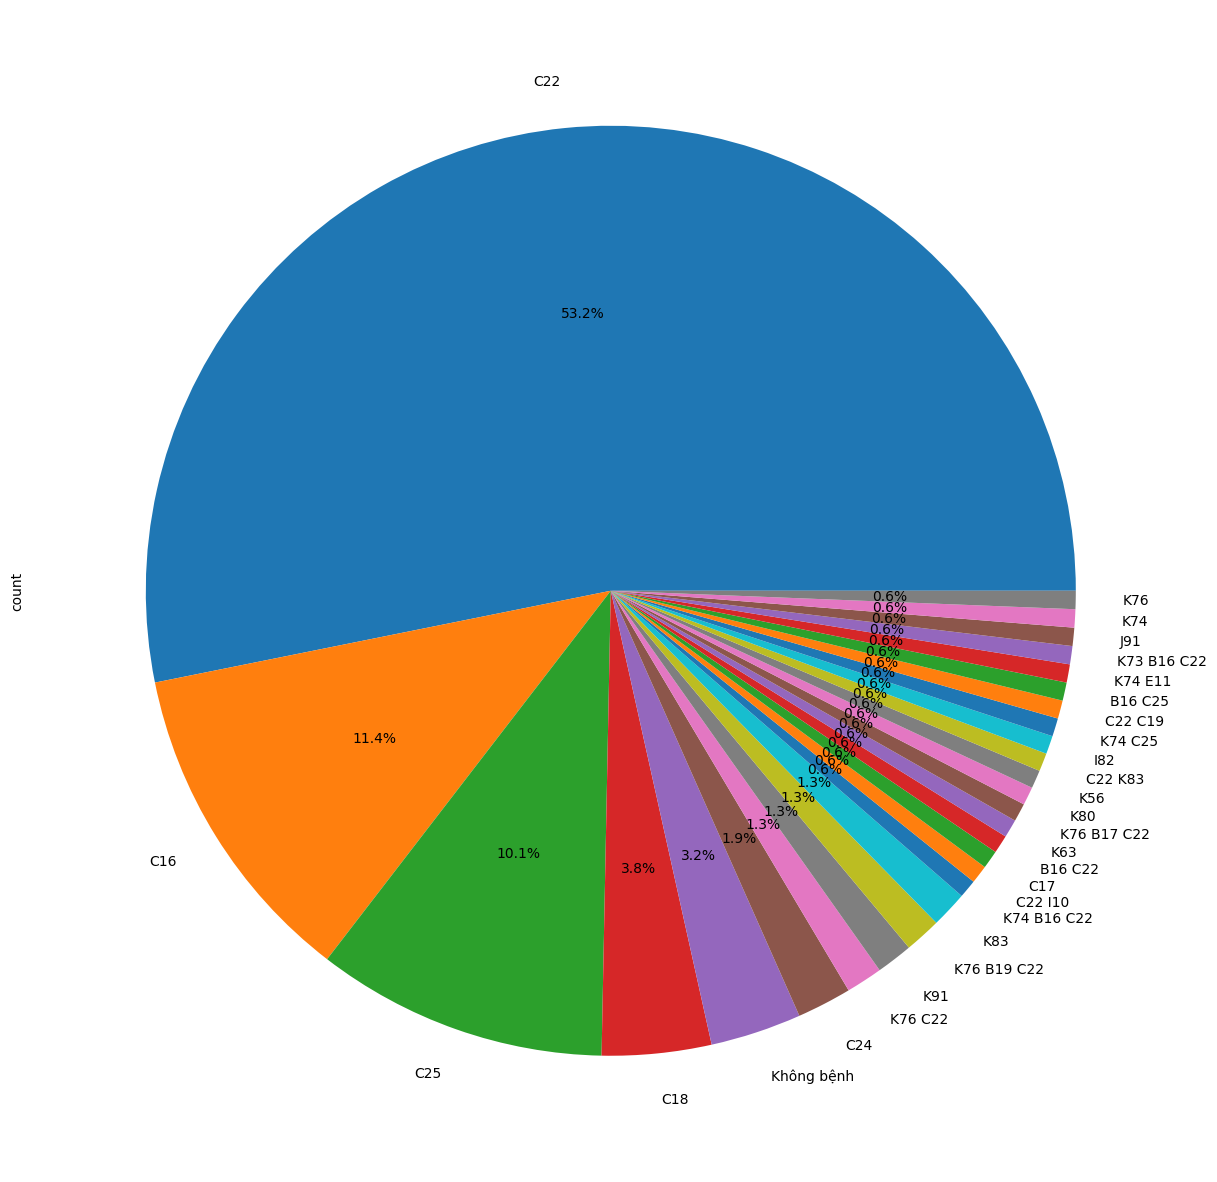

In [ ]:
plt.figure(figsize=(15, 16))

ma_icd['final(icd)'].value_counts().plot.pie(
    autopct='%1.1f%%'
)
plt.show()


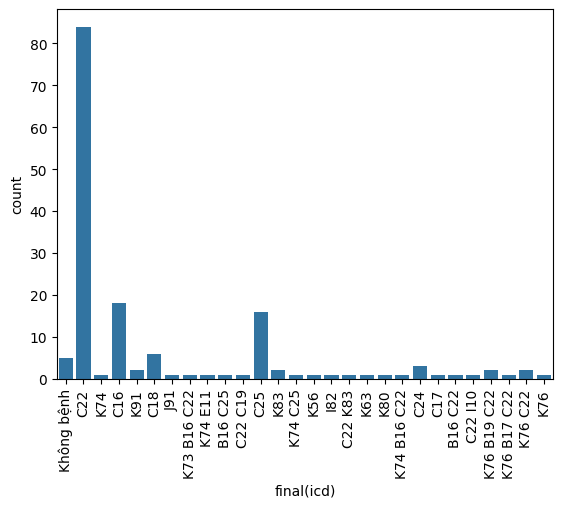

In [ ]:
sns.countplot(
    x='final(icd)',
    data=ma_icd,
    orient='h'
)
# Điều chỉnh góc quay của chữ (ví dụ 90 độ)
plt.xticks(rotation=90)

# Hiển thị biểu đồ
plt.show()

In [ ]:
dataRaw

record_ID age ngay_vao_vien                  name ma_nghien_cuu gender  \
1           4  74    2022-07-19       Nguyễn Hữu Hoàn          0074    Nam   
2           5  74    2022-09-26      Dương Trung Hiệp          0107    Nam   
3           6  56    2022-09-22            Lê Văn Thự          0108    Nam   
4           7  77    2022-09-20         Đỗ Xuân Bường          0109    Nam   
5           8  80           NaN            Lù Văn Đôi          0098    Nam   
..        ...  ..           ...                   ...           ...    ...   
187       596  63    2022-09-07  Nguyễn Thị Tuyết Mai          1102     Nữ   
188       601  71    2022-09-28    Đào Thị Minh Lương          1165     Nữ   
189       604  56    2022-09-27        Trần Đình Trúc          1200    Nam   
191       860  54    2022-08-14       nguyễn kim DOãn        UB0909    Nam   
193       862  76    2022-08-25            Vũ Thị Chụ        UB0911     Nữ   

    height weight   bmi  red_blood_cell  ...  AST/ALT   FIB-4       NFS  BARD  \
1      163     54  20.3            4.86  ...   1.4877  3.5825   -0.4764     2   
2      162     67  25.5            4.22  ...      NaN     NaN      1.77     0   
3      157     57  23.1            5.45  ...      NaN     NaN    0.2414     0   
4      NaN    NaN   NaN            3.36  ...   1.3955  2.0718   -3.2471     2   
5      165     63  23.1            4.52  ...   1.0831  2.6758   -0.3719     2   
..     ...    ...   ...             ...  ...      ...     ...       ...   ...   
187    155     43  17.9            3.36  ...   0.7933  2.1011   -1.1028     0   
188    150     53  23.6            4.89  ...   0.8724  2.9853   -2.3109     3   
189    165     62  22.8            4.92  ...   0.9653  0.9835   -2.4536     2   
191    165     55  20.2            4.30  ...   1.6667  1.2777   -1.6762     2   
193    165     56  20.6            3.80  ...   1.6875  2.8451    -0.419     2   

              benh_gan  viem_gan                          ung_thu_gan  \
1                  NaN       NaN                                  NaN   
2                  NaN       NaN  U ác của gan và đường mật trong gan   
3                  NaN       NaN                                  NaN   
4                  NaN       NaN                                  NaN   
5                  NaN       NaN  U ác của gan và đường mật trong gan   
..                 ...       ...                                  ...   
187                NaN       NaN  U ác của gan và đường mật trong gan   
188  Các bệnh gan khác       NaN                                  NaN   
189  Các bệnh gan khác       NaN  U ác của gan và đường mật trong gan   
191                NaN       NaN                                  NaN   
193                NaN       NaN                                  NaN   

     icd_khac       check  class  
1         NaN  Hoàn thành      0  
2         NaN  Hoàn thành      1  
3         NaN  Hoàn thành      0  
4         NaN  Hoàn thành      0  
5         NaN  Hoàn thành      1  
..        ...         ...    ...  
187       NaN  Hoàn thành      1  
188       NaN  Hoàn thành      1  
189       NaN  Hoàn thành      1  
191       NaN  Hoàn thành      0  
193       NaN  Hoàn thành      0  

[158 rows x 46 columns]

In [ ]:
ma_icd

benh_gan viem_gan                          ung_thu_gan icd_khac  \
1                                                                               
2                                U ác của gan và đường mật trong gan            
3                                                                               
4                                                                               
5                                U ác của gan và đường mật trong gan            
..                 ...      ...                                  ...      ...   
187                              U ác của gan và đường mật trong gan            
188  Các bệnh gan khác                                                          
189  Các bệnh gan khác           U ác của gan và đường mật trong gan            
191                                                                             
193                                                                             

                                                 final benh_gan(icd)  \
1                                           Không bệnh                 
2                  U ác của gan và đường mật trong gan                 
3                                           Không bệnh                 
4                                           Không bệnh                 
5                  U ác của gan và đường mật trong gan                 
..                                                 ...           ...   
187                U ác của gan và đường mật trong gan                 
188                                  Các bệnh gan khác           K76   
189  Các bệnh gan khác U ác của gan và đường mật tr...           K76   
191                                         Không bệnh                 
193                                         Không bệnh                 

    viem_gan(icd) ung_thu_gan(icd) icd_khac(icd)  final(icd)  
1                                                 Không bệnh  
2                              C22                       C22  
3                                                 Không bệnh  
4                                                 Không bệnh  
5                              C22                       C22  
..            ...              ...           ...         ...  
187                            C22                       C22  
188                                                      K76  
189                            C22                   K76 C22  
191                                               Không bệnh  
193                                               Không bệnh  

[158 rows x 10 columns]

##2.3. Copy ICD

In [ ]:
dataRaw['final(icd)'] = ma_icd['final(icd)']

In [ ]:
dataRaw

record_ID age ngay_vao_vien                  name ma_nghien_cuu gender  \
1           4  74    2022-07-19       Nguyễn Hữu Hoàn          0074    Nam   
2           5  74    2022-09-26      Dương Trung Hiệp          0107    Nam   
3           6  56    2022-09-22            Lê Văn Thự          0108    Nam   
4           7  77    2022-09-20         Đỗ Xuân Bường          0109    Nam   
5           8  80           NaN            Lù Văn Đôi          0098    Nam   
..        ...  ..           ...                   ...           ...    ...   
187       596  63    2022-09-07  Nguyễn Thị Tuyết Mai          1102     Nữ   
188       601  71    2022-09-28    Đào Thị Minh Lương          1165     Nữ   
189       604  56    2022-09-27        Trần Đình Trúc          1200    Nam   
191       860  54    2022-08-14       nguyễn kim DOãn        UB0909    Nam   
193       862  76    2022-08-25            Vũ Thị Chụ        UB0911     Nữ   

    height weight   bmi  red_blood_cell  ...   FIB-4       NFS  BARD  \
1      163     54  20.3            4.86  ...  3.5825   -0.4764     2   
2      162     67  25.5            4.22  ...     NaN      1.77     0   
3      157     57  23.1            5.45  ...     NaN    0.2414     0   
4      NaN    NaN   NaN            3.36  ...  2.0718   -3.2471     2   
5      165     63  23.1            4.52  ...  2.6758   -0.3719     2   
..     ...    ...   ...             ...  ...     ...       ...   ...   
187    155     43  17.9            3.36  ...  2.1011   -1.1028     0   
188    150     53  23.6            4.89  ...  2.9853   -2.3109     3   
189    165     62  22.8            4.92  ...  0.9835   -2.4536     2   
191    165     55  20.2            4.30  ...  1.2777   -1.6762     2   
193    165     56  20.6            3.80  ...  2.8451    -0.419     2   

              benh_gan  viem_gan                          ung_thu_gan  \
1                  NaN       NaN                                  NaN   
2                  NaN       NaN  U ác của gan và đường mật trong gan   
3                  NaN       NaN                                  NaN   
4                  NaN       NaN                                  NaN   
5                  NaN       NaN  U ác của gan và đường mật trong gan   
..                 ...       ...                                  ...   
187                NaN       NaN  U ác của gan và đường mật trong gan   
188  Các bệnh gan khác       NaN                                  NaN   
189  Các bệnh gan khác       NaN  U ác của gan và đường mật trong gan   
191                NaN       NaN                                  NaN   
193                NaN       NaN                                  NaN   

     icd_khac       check  class  final(icd)  
1         NaN  Hoàn thành      0  Không bệnh  
2         NaN  Hoàn thành      1         C22  
3         NaN  Hoàn thành      0  Không bệnh  
4         NaN  Hoàn thành      0  Không bệnh  
5         NaN  Hoàn thành      1         C22  
..        ...         ...    ...         ...  
187       NaN  Hoàn thành      1         C22  
188       NaN  Hoàn thành      1         K76  
189       NaN  Hoàn thành      1     K76 C22  
191       NaN  Hoàn thành      0  Không bệnh  
193       NaN  Hoàn thành      0  Không bệnh  

[158 rows x 47 columns]

In [ ]:
icd_major = ['C22','C25','C16','C18','C24','K91','K83','C17','K63','K80','K56','I82','J91','K74','K76']

In [ ]:
dataRaw = dataRaw.loc[dataRaw['final(icd)'].isin(icd_major)].copy()

In [ ]:
dataRaw

record_ID age ngay_vao_vien                  name ma_nghien_cuu gender  \
2           5  74    2022-09-26      Dương Trung Hiệp          0107    Nam   
5           8  80           NaN            Lù Văn Đôi          0098    Nam   
6          13  50    2022-10-21           Đỗ Văn Ngọc          0129    Nam   
7          14  58           NaN      Nguyễn Thanh Đàn           128    Nam   
27        109  60    2022-12-22         Lê Quang Nhân        UB0178    Nam   
..        ...  ..           ...                   ...           ...    ...   
184       507  51    2022-06-22      NGUYỄN THỊ KHANH        UB0462     Nữ   
185       565  70    2022-11-23          Vũ Hồng Mạnh        UB0084    Nam   
186       566  60    2022-11-30        Nguyễn Văn Nam        UB0085    Nam   
187       596  63    2022-09-07  Nguyễn Thị Tuyết Mai          1102     Nữ   
188       601  71    2022-09-28    Đào Thị Minh Lương          1165     Nữ   

    height weight   bmi  red_blood_cell  ...   FIB-4       NFS  BARD  \
2      162     67  25.5            4.22  ...     NaN      1.77     0   
5      165     63  23.1            4.52  ...  2.6758   -0.3719     2   
6      170     65  22.5            4.81  ...  1.3551   -2.1842     2   
7      NaN    NaN   NaN            4.86  ...  8.4799   -2.0595     2   
27     162     50  19.1            1.93  ...  1.3417    -3.084     2   
..     ...    ...   ...             ...  ...     ...       ...   ...   
184    145     40    19            4.85  ...  0.9942   -1.3619     3   
185    170     75    26            4.31  ...  1.9276   -0.6385     2   
186    161     61  23.5            5.04  ...  0.6623    -3.929     0   
187    155     43  17.9            3.36  ...  2.1011   -1.1028     0   
188    150     53  23.6            4.89  ...  2.9853   -2.3109     3   

              benh_gan  viem_gan                          ung_thu_gan  \
2                  NaN       NaN  U ác của gan và đường mật trong gan   
5                  NaN       NaN  U ác của gan và đường mật trong gan   
6     Xơ gan và xơ gan       NaN                                  NaN   
7                  NaN       NaN  U ác của gan và đường mật trong gan   
27                 NaN       NaN                                  NaN   
..                 ...       ...                                  ...   
184                NaN       NaN                                  NaN   
185                NaN       NaN                                  NaN   
186                NaN       NaN                                  NaN   
187                NaN       NaN  U ác của gan và đường mật trong gan   
188  Các bệnh gan khác       NaN                                  NaN   

     icd_khac       check  class  final(icd)  
2         NaN  Hoàn thành      1         C22  
5         NaN  Hoàn thành      1         C22  
6         NaN  Hoàn thành      1         K74  
7         NaN  Hoàn thành      1         C22  
27       C163  Hoàn thành      1         C16  
..        ...         ...    ...         ...  
184      C162  Hoàn thành      1         C16  
185     C16.9  Hoàn thành      1         C16  
186     C16.3  Hoàn thành      1         C16  
187       NaN  Hoàn thành      1         C22  
188       NaN  Hoàn thành      1         K76  

[139 rows x 47 columns]

In [ ]:
dataRaw['class'] = np.where(dataRaw['final(icd)'] == 'C22', 1, 0)

In [ ]:
file_path = 'validate.xlsx'

# Xuất DataFrame sang tệp Excel
dataRaw.to_excel(file_path, index=False)

In [ ]:
columns_to_drop = [
    'ngay_vao_vien',
    'record_ID',
    'name',
    'ma_nghien_cuu',
    'benh_gan',
    'viem_gan',
    'ung_thu_gan',
    'icd_khac',
    'check',
    'final(icd)'
]
data_for_visualize = dataRaw.copy()
data_for_visualize.drop(columns = columns_to_drop, axis = 1, inplace = True)

#3 Visualize

In [ ]:
data_for_visualize.isnull().sum(axis=0)

age                     0
gender                  0
height                  4
weight                  4
bmi                     4
red_blood_cell          1
white_blood_cell        1
platelets               3
INR                     8
prothrombin            55
AST                     1
ALT                     2
GGT                   131
total_bilirubin         7
indirect_bilirubin     17
albumin                21
ure                     4
creatinin               4
blood_type             51
cholesterol           133
triglyceride          135
HDL-C                 135
LDL-C                 136
glucose                13
HbA1C                 137
HbsAg                  70
AntiHCV                75
CEA                    45
Alpha_FP               67
PIVKA-II              133
CA_19_9                21
APRI                    4
AST/ALT                 2
FIB-4                   5
NFS                     0
BARD                    0
class                   0
dtype: int64

Các cột trống nhiều dữ liệu

In [ ]:
columns_nan = [
    'prothrombin',
    'GGT',
    'blood_type',
    'cholesterol',
    'triglyceride',
    'HDL-C',
    'LDL-C',
    'HbA1C',
    'HbsAg',
    'AntiHCV',
    'CEA',
    'Alpha_FP',
    'PIVKA-II'
]

In [ ]:
laboratory_parameter = [
    'APRI',
    'AST/ALT',
    'FIB-4',
    'NFS',
    'BARD'
]

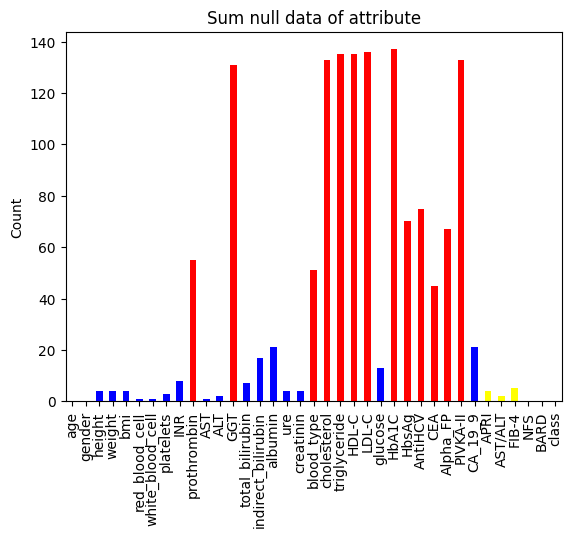

In [ ]:
# Vẽ biểu đồ cột từ Pandas Series
data_for_visualize.isnull().sum(axis=0).plot(kind='bar', color = ['red' if column in columns_nan else 'yellow' if column in laboratory_parameter else 'blue' for column in data_for_visualize.columns])

# Tùy chỉnh biểu đồ
plt.ylabel('Count')
plt.title('Sum null data of attribute')
plt.savefig('sum_null_data.svg', format='eps', dpi=150)
plt.show()

In [ ]:
# data_for_visualize.drop(columns=columns_nan, inplace = True)        # drop columns too many null values
# # data_for_visualize.drop(columns = laboratory_parameter, inplace = True)
# data_for_visualize = data_for_visualize._convert(numeric=True) # converting the data type

In [ ]:
data_for_visualize.drop(columns=columns_nan, inplace=True)  # Drop columns with too many null values
# data_for_visualize.drop(columns=laboratory_parameter, inplace=True)  # Uncomment if needed
data_for_visualize = data_for_visualize.astype('float64', errors='ignore')  # Convert data types to numeric

In [ ]:
data_for_visualize

age gender height weight   bmi  red_blood_cell  white_blood_cell  \
2    74    Nam    162     67  25.5            4.22             13.60   
5    80    Nam    165     63  23.1            4.52              8.33   
6    50    Nam    170     65  22.5            4.81             12.33   
7    58    Nam    NaN    NaN   NaN            4.86              6.92   
27   60    Nam    162     50  19.1            1.93              9.39   
..   ..    ...    ...    ...   ...             ...               ...   
184  51     Nữ    145     40    19            4.85              5.38   
185  70    Nam    170     75    26            4.31              8.89   
186  60    Nam    161     61  23.5            5.04              5.94   
187  63     Nữ    155     43  17.9            3.36              7.16   
188  71     Nữ    150     53  23.6            4.89             11.91   

     platelets   INR     AST  ...   ure  creatinin  glucose   CA_19_9    APRI  \
2        130.0  1.21     NaN  ...   NaN        NaN      NaN     90.61     NaN   
5        214.0  1.17   47.30  ...  4.52      68.43     4.94     57.41  0.5526   
6        237.0  1.02   33.29  ...  5.88      72.30     5.36     32.67  0.3512   
7        117.0  1.11  201.30  ...  8.08      78.82     5.92      1.54  4.3013   
27       373.0   NaN   45.41  ...  4.83      75.57     6.63  25489.00  0.3044   
..         ...   ...     ...  ...   ...        ...      ...       ...     ...   
184      267.0  1.08   18.09  ...  4.30      55.44      NaN       NaN  0.1694   
185      190.0  1.04   26.74  ...  6.07      89.88     5.62     25.43  0.3518   
186      339.0   NaN   23.30  ...  3.95      75.73     5.88      8.12  0.1718   
187      151.0  1.07   31.97  ...   NaN      73.62     5.36      3.46  0.5293   
188      575.0  0.99  670.00  ...  3.39      68.11      NaN   1610.00   2.913   

     AST/ALT   FIB-4       NFS BARD class  
2        NaN     NaN      1.77    0   1.0  
5     1.0831  2.6758   -0.3719    2   1.0  
6     1.2394  1.3551   -2.1842    2   0.0  
7     1.4536  8.4799   -2.0595    2   1.0  
27    1.5321  1.3417    -3.084    2   0.0  
..       ...     ...       ...  ...   ...  
184   1.4975  0.9942   -1.3619    3   0.0  
185   1.0237  1.9276   -0.6385    2   0.0  
186    0.601  0.6623    -3.929    0   0.0  
187   0.7933  2.1011   -1.1028    0   1.0  
188   0.8724  2.9853   -2.3109    3   0.0  

[139 rows x 24 columns]

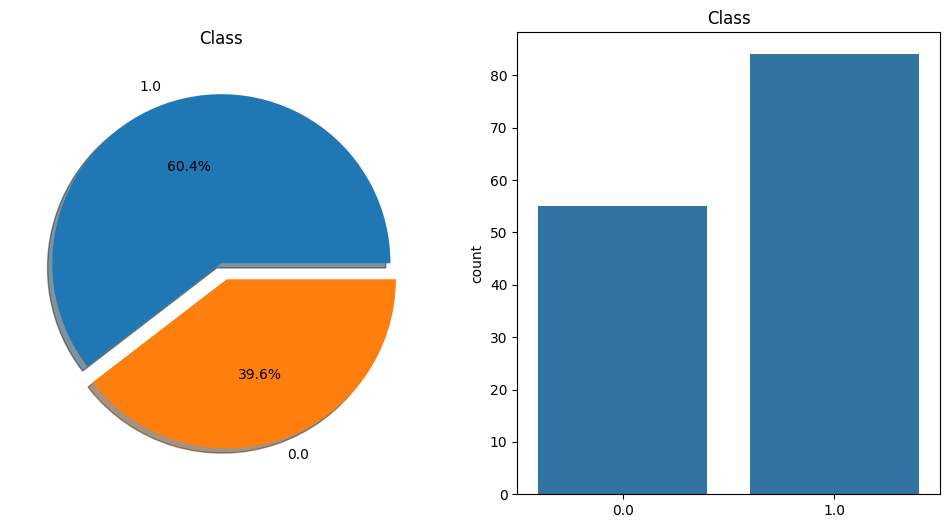

class
1.0    84
0.0    55
Name: count, dtype: int64

In [ ]:
f, ax=plt.subplots(
    1,
    2,
    figsize=(12,6)
)

data_for_visualize['class'].value_counts().plot.pie(
    explode=[0,0.1],
    autopct='%1.1f%%',
    ax=ax[0],
    shadow=True
)

ax[0].set_title('Class')
ax[0].set_ylabel('')

sns.countplot(
    x='class',
    data=data_for_visualize,ax=ax[1]
)

ax[1].set_title('Class')
ax[1].set_xlabel('')

plt.show()
data_for_visualize['class'].value_counts()

##3.1 Age

In [ ]:
data_for_visualize

age gender height weight   bmi  red_blood_cell  white_blood_cell  \
2    74    Nam    162     67  25.5            4.22             13.60   
5    80    Nam    165     63  23.1            4.52              8.33   
6    50    Nam    170     65  22.5            4.81             12.33   
7    58    Nam    NaN    NaN   NaN            4.86              6.92   
27   60    Nam    162     50  19.1            1.93              9.39   
..   ..    ...    ...    ...   ...             ...               ...   
184  51     Nữ    145     40    19            4.85              5.38   
185  70    Nam    170     75    26            4.31              8.89   
186  60    Nam    161     61  23.5            5.04              5.94   
187  63     Nữ    155     43  17.9            3.36              7.16   
188  71     Nữ    150     53  23.6            4.89             11.91   

     platelets   INR     AST  ...   ure  creatinin  glucose   CA_19_9    APRI  \
2        130.0  1.21     NaN  ...   NaN        NaN      NaN     90.61     NaN   
5        214.0  1.17   47.30  ...  4.52      68.43     4.94     57.41  0.5526   
6        237.0  1.02   33.29  ...  5.88      72.30     5.36     32.67  0.3512   
7        117.0  1.11  201.30  ...  8.08      78.82     5.92      1.54  4.3013   
27       373.0   NaN   45.41  ...  4.83      75.57     6.63  25489.00  0.3044   
..         ...   ...     ...  ...   ...        ...      ...       ...     ...   
184      267.0  1.08   18.09  ...  4.30      55.44      NaN       NaN  0.1694   
185      190.0  1.04   26.74  ...  6.07      89.88     5.62     25.43  0.3518   
186      339.0   NaN   23.30  ...  3.95      75.73     5.88      8.12  0.1718   
187      151.0  1.07   31.97  ...   NaN      73.62     5.36      3.46  0.5293   
188      575.0  0.99  670.00  ...  3.39      68.11      NaN   1610.00   2.913   

     AST/ALT   FIB-4       NFS BARD class  
2        NaN     NaN      1.77    0   1.0  
5     1.0831  2.6758   -0.3719    2   1.0  
6     1.2394  1.3551   -2.1842    2   0.0  
7     1.4536  8.4799   -2.0595    2   1.0  
27    1.5321  1.3417    -3.084    2   0.0  
..       ...     ...       ...  ...   ...  
184   1.4975  0.9942   -1.3619    3   0.0  
185   1.0237  1.9276   -0.6385    2   0.0  
186    0.601  0.6623    -3.929    0   0.0  
187   0.7933  2.1011   -1.1028    0   1.0  
188   0.8724  2.9853   -2.3109    3   0.0  

[139 rows x 24 columns]

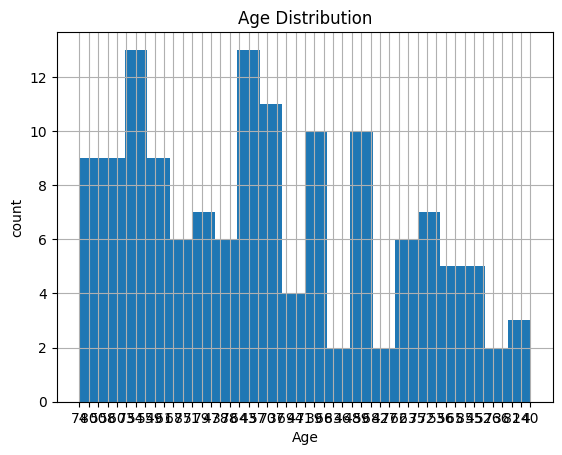

Độ tuổi già nhất: 87
Độ tuổi trẻ nhất: 24
Độ tuổi trung bình: 538165889261543550976341440750482525696799047485292387139967285644882625144122931576307955523072187541427858965982271271317278489737422648098536236465791424597173198418499074769797846441541147097178601682241732200624390134502573757321462608704671462509613540604544870332235776.00
Độ tuổi trung vị: 61.0 


In [ ]:
plt.hist(data_for_visualize['age'], bins=20)
# sns.histplot(data_for_visualize, x="age", element="step", bins=20, kde = True) #cách 2
# Tùy chỉnh biểu đồ
plt.xlabel('Age')
plt.ylabel('count')
plt.title('Age Distribution')
plt.grid(True)
plt.show()
#Độ tuổi của bệnh nhân
print('Độ tuổi già nhất: {}'.format(data_for_visualize['age'].max()))
print('Độ tuổi trẻ nhất: {}'.format(data_for_visualize['age'].min()))
print('Độ tuổi trung bình: {:.2f}'.format(data_for_visualize['age'].mean()))
print('Độ tuổi trung vị: {} '.format(data_for_visualize['age'].median(skipna=True)))

##3.2 Gender

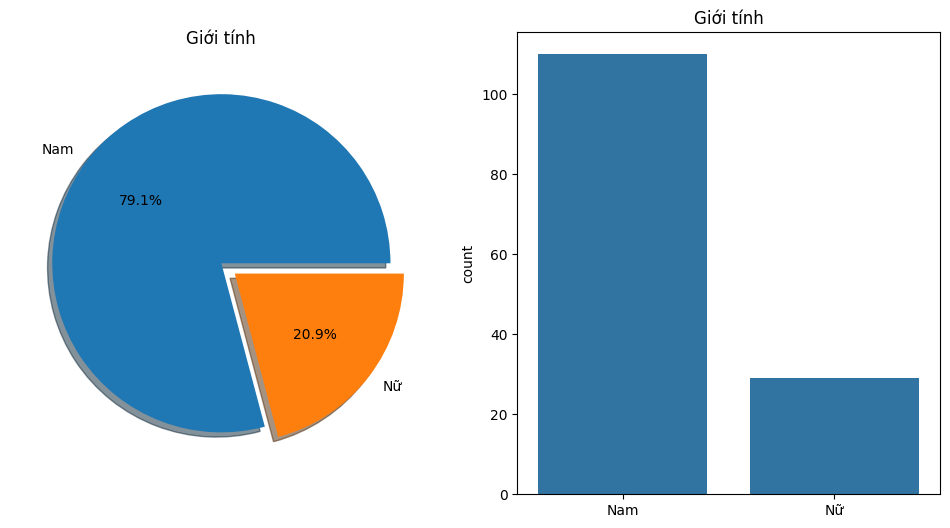

gender
Nam    110
Nữ      29
Name: count, dtype: int64

In [ ]:
f, ax=plt.subplots(
    1,
    2,
    figsize=(12,6)
)

data_for_visualize['gender'].value_counts().plot.pie(
    explode=[0,0.1],
    autopct='%1.1f%%',
    ax=ax[0],
    shadow=True
)

ax[0].set_title('Giới tính')
ax[0].set_ylabel('')

sns.countplot(
    x='gender',
    data=data_for_visualize,ax=ax[1]
)

ax[1].set_title('Giới tính')
ax[1].set_xlabel('')

plt.show()
data_for_visualize['gender'].value_counts()

##3.3 Height

In [ ]:
# plt.hist(data_for_visualize['height'], bins=30)
# # sns.histplot(data_for_visualize, x="age", element="step", bins=20, kde = True) #cách 2
# # Tùy chỉnh biểu đồ
# plt.xlabel('Height')
# plt.ylabel('count')
# plt.title('Height Distribution')
# plt.grid(True)
# plt.show()
# #Độ tuổi của bệnh nhân
# print('Cao nhất nhất: {}'.format(data_for_visualize['height'].max()))
# print('Thấp nhất: {}'.format(data_for_visualize['height'].min()))
# print('Chiều cao trung bình: {:.2f}'.format(data_for_visualize['height'].mean()))
# print('Chiều cao trung vị: {} '.format(data_for_visualize['height'].median(skipna=True)))

In [ ]:
print(data_for_visualize['height'].dtype)

object


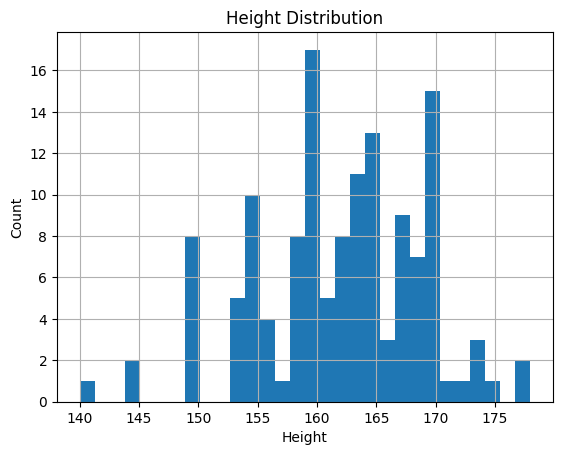

Maximum height: 178.00
Minimum height: 140.00
Average height: 162.03
Median height: 162.00


In [ ]:
# Convert 'height' column to numeric, coercing non-convertible values to NaN
data_for_visualize['height'] = pd.to_numeric(data_for_visualize['height'], errors='coerce')

plt.hist(data_for_visualize['height'], bins=30)
plt.xlabel('Height')
plt.ylabel('Count')
plt.title('Height Distribution')
plt.grid(True)
plt.show()

# Summary statistics for patient heights
print('Maximum height: {:.2f}'.format(data_for_visualize['height'].max()))
print('Minimum height: {:.2f}'.format(data_for_visualize['height'].min()))
print('Average height: {:.2f}'.format(data_for_visualize['height'].mean()))
print('Median height: {:.2f}'.format(data_for_visualize['height'].median(skipna=True)))

##3.4 Weight

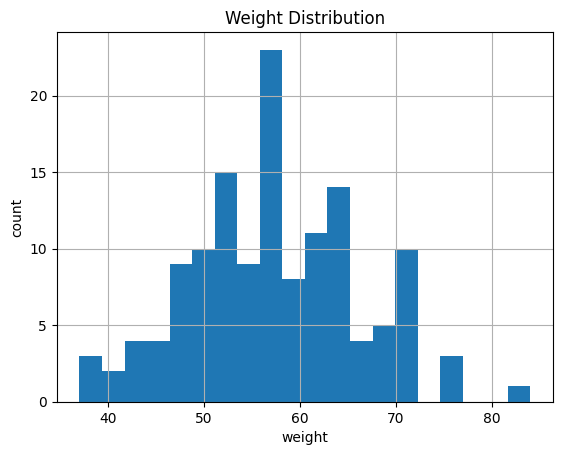

Nặng nhất: 84.0
Nhẹ nhất: 37.0
Cân nặng trung bình: 57.33
Cân nặng trung vị: 57.0 


In [ ]:
data_for_visualize['weight'] = pd.to_numeric(data_for_visualize['weight'], errors='coerce')

plt.hist(data_for_visualize['weight'], bins=20)
# sns.histplot(data_for_visualize, x="age", element="step", bins=20, kde = True) #cách 2
# Tùy chỉnh biểu đồ
plt.xlabel('weight')
plt.ylabel('count')
plt.title('Weight Distribution')
plt.grid(True)
plt.show()
#Độ tuổi của bệnh nhân
print('Nặng nhất: {}'.format(data_for_visualize['weight'].max()))
print('Nhẹ nhất: {}'.format(data_for_visualize['weight'].min()))
print('Cân nặng trung bình: {:.2f}'.format(data_for_visualize['weight'].mean()))
print('Cân nặng trung vị: {} '.format(data_for_visualize['weight'].median(skipna=True)))

##3.5 BMI

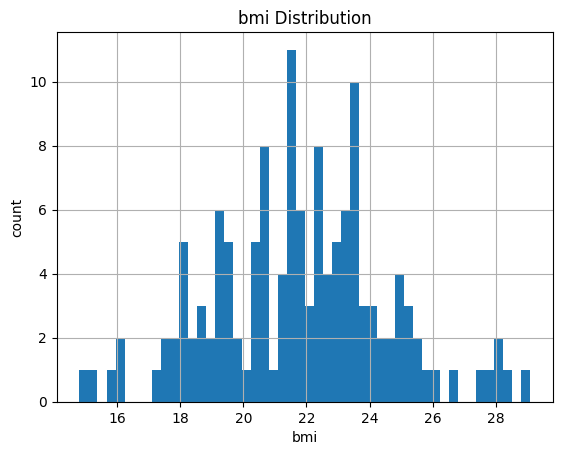

Max: 29.1
Min: 14.8
Mean: 21.80
Median: 21.8 


In [ ]:
data_for_visualize['bmi'] = pd.to_numeric(data_for_visualize['bmi'], errors='coerce')

plt.hist(data_for_visualize['bmi'], bins=50)
# sns.histplot(data_for_visualize, x="age", element="step", bins=20, kde = True) #cách 2
# Tùy chỉnh biểu đồ
plt.xlabel('bmi')
plt.ylabel('count')
plt.title('bmi Distribution')
plt.grid(True)
plt.show()
#Độ tuổi của bệnh nhân
print('Max: {}'.format(data_for_visualize['bmi'].max()))
print('Min: {}'.format(data_for_visualize['bmi'].min()))
print('Mean: {:.2f}'.format(data_for_visualize['bmi'].mean()))
print('Median: {} '.format(data_for_visualize['bmi'].median(skipna=True)))

##3.6 red_blood_cell

4.3-5.8(T/L) là bình thường

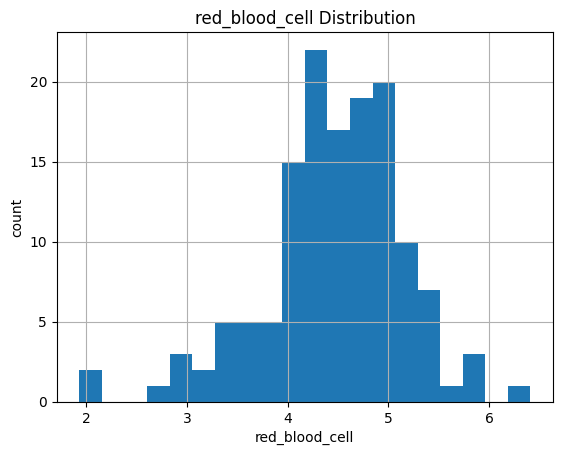

Max: 6.41
Min: 1.93
Mean: 4.46
Median: 4.515 


In [ ]:
plt.hist(data_for_visualize['red_blood_cell'], bins=20)
# sns.histplot(data_for_visualize, x="age", element="step", bins=20, kde = True) #cách 2
# Tùy chỉnh biểu đồ
plt.xlabel('red_blood_cell')
plt.ylabel('count')
plt.title('red_blood_cell Distribution')
plt.grid(True)
plt.show()
#Độ tuổi của bệnh nhân
print('Max: {}'.format(data_for_visualize['red_blood_cell'].max()))
print('Min: {}'.format(data_for_visualize['red_blood_cell'].min()))
print('Mean: {:.2f}'.format(data_for_visualize['red_blood_cell'].mean()))
print('Median: {} '.format(data_for_visualize['red_blood_cell'].median(skipna=True)))

##3.7 white_blood_cell    

4-10(G/L) có giá trị 60

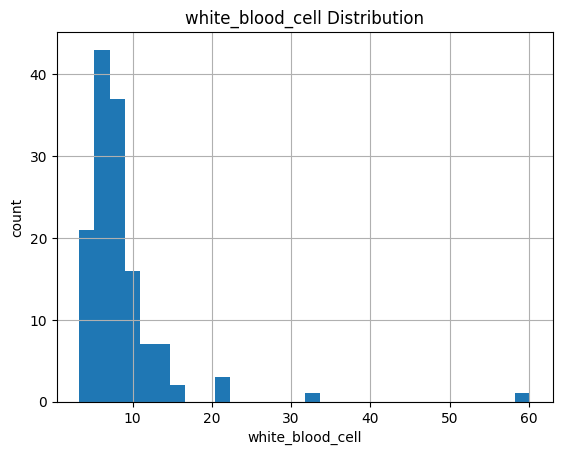

Max: 60.2
Min: 3.28
Mean: 8.55
Median: 7.245 


In [ ]:
plt.hist(data_for_visualize['white_blood_cell'], bins=30)
# sns.histplot(data_for_visualize, x="age", element="step", bins=20, kde = True) #cách 2
# Tùy chỉnh biểu đồ
plt.xlabel('white_blood_cell')
plt.ylabel('count')
plt.title('white_blood_cell Distribution')
plt.grid(True)
plt.show()
#Độ tuổi của bệnh nhân
print('Max: {}'.format(data_for_visualize['white_blood_cell'].max()))
print('Min: {}'.format(data_for_visualize['white_blood_cell'].min()))
print('Mean: {:.2f}'.format(data_for_visualize['white_blood_cell'].mean()))
print('Median: {} '.format(data_for_visualize['white_blood_cell'].median(skipna=True)))

##3.8 platelets           

150-450(G/L)

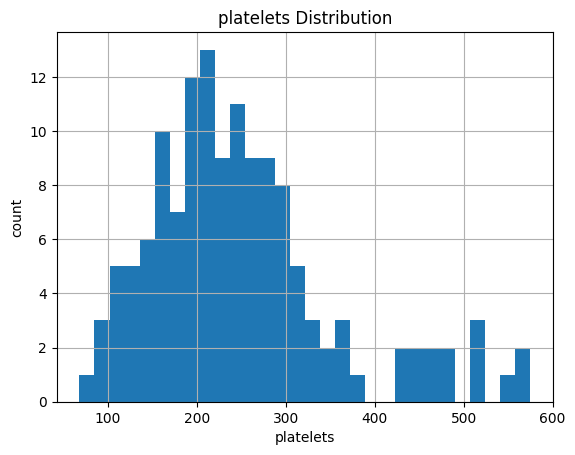

Max: 575.0
Min: 68.0
Mean: 249.84
Median: 233.0 


In [ ]:
plt.hist(data_for_visualize['platelets'], bins=30)
# sns.histplot(data_for_visualize, x="age", element="step", bins=20, kde = True) #cách 2
# Tùy chỉnh biểu đồ
plt.xlabel('platelets')
plt.ylabel('count')
plt.title('platelets Distribution')
plt.grid(True)
plt.show()
#Độ tuổi của bệnh nhân
print('Max: {}'.format(data_for_visualize['platelets'].max()))
print('Min: {}'.format(data_for_visualize['platelets'].min()))
print('Mean: {:.2f}'.format(data_for_visualize['platelets'].mean()))
print('Median: {} '.format(data_for_visualize['platelets'].median(skipna=True)))

##3.9 INR                 

Không có khoảng giá trị nhưng phân phối dưới đẹp

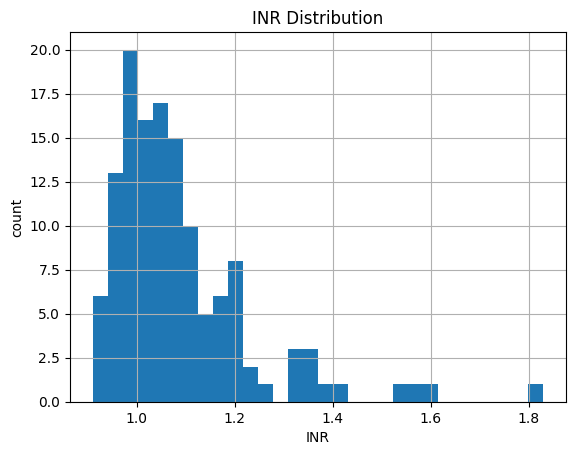

Max: 1.83
Min: 0.91
Mean: 1.09
Median: 1.05 


In [ ]:
plt.hist(data_for_visualize['INR'], bins=30)
# sns.histplot(data_for_visualize, x="age", element="step", bins=20, kde = True) #cách 2
# Tùy chỉnh biểu đồ
plt.xlabel('INR')
plt.ylabel('count')
plt.title('INR Distribution')
plt.grid(True)
plt.show()
#Độ tuổi của bệnh nhân
print('Max: {}'.format(data_for_visualize['INR'].max()))
print('Min: {}'.format(data_for_visualize['INR'].min()))
print('Mean: {:.2f}'.format(data_for_visualize['INR'].mean()))
print('Median: {} '.format(data_for_visualize['INR'].median(skipna=True)))

##3.10 AST                 

<37 (đã gặp giá trị lên tới 359.41)

count    138.000000
mean      57.883551
std       72.960202
min       10.470000
25%       27.150000
50%       41.670000
75%       55.370000
max      670.000000
Name: AST, dtype: float64

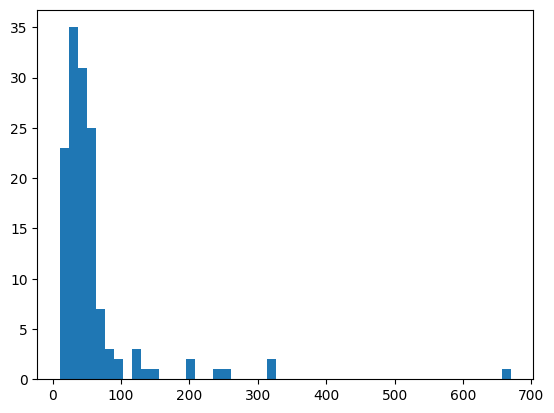

In [ ]:
plt.hist(data_for_visualize['AST'], bins=50)
data_for_visualize.describe().AST

##3.11 ALT                 

<40 (đã gặp 225.51)

một số bệnh nhân không có ALT vì k xét nghiệm???

count    137.000000
mean      64.110803
std      100.266135
min        3.440000
25%       23.970000
50%       39.190000
75%       59.470000
max      768.000000
Name: ALT, dtype: float64

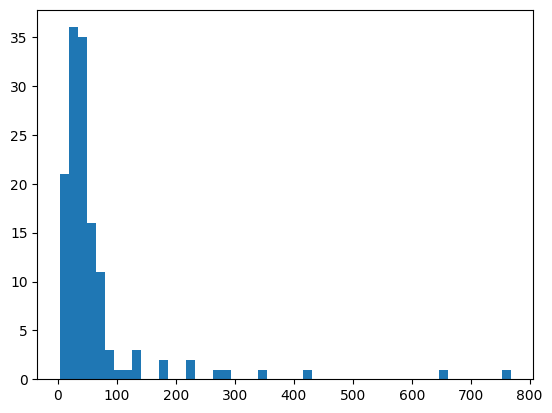

In [ ]:
plt.hist(data_for_visualize['ALT'], bins=50)
data_for_visualize.describe().ALT

In [ ]:
data_for_visualize.loc[data_for_visualize['AST'] == data_for_visualize['AST'].max()]

age gender  height  weight   bmi  red_blood_cell  white_blood_cell  \
188  71     Nữ   150.0    53.0  23.6            4.89             11.91   

     platelets   INR    AST  ...   ure  creatinin  glucose  CA_19_9   APRI  \
188      575.0  0.99  670.0  ...  3.39      68.11      NaN   1610.0  2.913   

     AST/ALT   FIB-4       NFS BARD class  
188   0.8724  2.9853   -2.3109    3   0.0  

[1 rows x 24 columns]

In [ ]:
data_for_visualize.drop(188, axis = 0, inplace = True)

In [ ]:
#có 1 người max là 647 (không tra được vì k có trong server)

##3.12 total_bilirubin     

In [ ]:
# data_for_visualize['total_bilirubin']*88.42

count    131.000000
mean      36.861298
std       68.436135
min        3.900000
25%       10.450000
50%       13.700000
75%       19.900000
max      342.700000
Name: total_bilirubin, dtype: float64

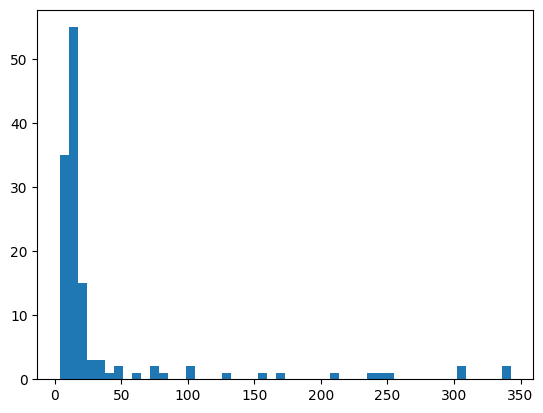

In [ ]:
plt.hist(data_for_visualize['total_bilirubin'], bins=50)
data_for_visualize.describe().total_bilirubin

##3.13 indirect_bilirubin  

<13.9 vì total < 19 và direct < 5.1
trong bài này 233.7 có vẻ vẫn hợp lý vì total lớn nhất từng gặp là 342.7

count    122.000000
mean      19.896066
std       31.116872
min        1.400000
25%        7.100000
50%       10.100000
75%       14.825000
max      233.700000
Name: indirect_bilirubin, dtype: float64

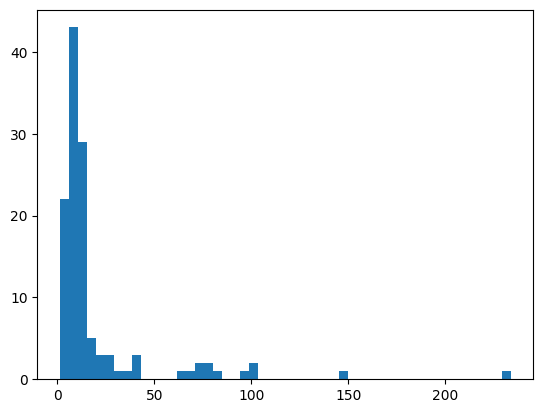

In [ ]:
plt.hist(data_for_visualize['indirect_bilirubin'], bins=50)
data_for_visualize.describe().indirect_bilirubin

##3.14 albumin             

<5.1 (giá trị 3 là đúng)

count    118.000000
mean      38.346186
std        6.204390
min        3.000000
25%       35.375000
50%       39.650000
75%       42.600000
max       47.500000
Name: albumin, dtype: float64

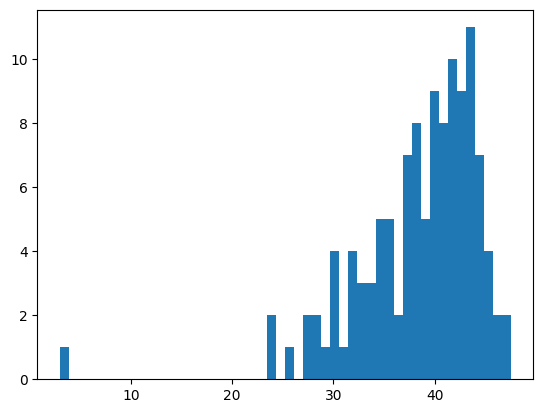

In [ ]:
plt.hist(data_for_visualize['albumin'], bins=50)
data_for_visualize.describe().albumin

##3.15 Ure

1.7-8.3

count    134.000000
mean       5.896642
std        4.065046
min        2.150000
25%        4.205000
50%        5.135000
75%        6.500000
max       45.600000
Name: ure, dtype: float64

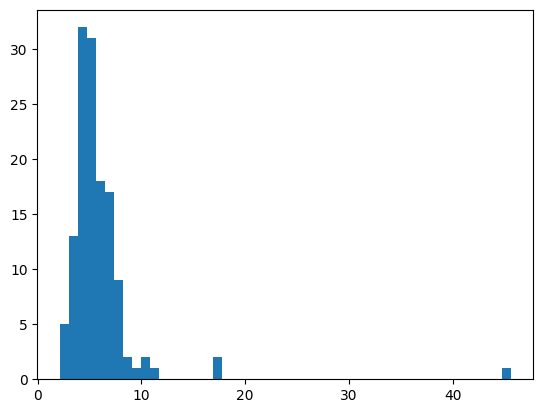

In [ ]:
plt.hist(data_for_visualize['ure'], bins=50)
data_for_visualize.describe().ure

ure max 45.6 chưa check được

##3.16 creatinin

nam<115 nữ<90 (đã xác nhận lại giá trị 338,54 là có trong csdl)

count    134.000000
mean      82.540224
std       31.167829
min        0.250000
25%       67.500000
50%       80.105000
75%       91.215000
max      338.540000
Name: creatinin, dtype: float64

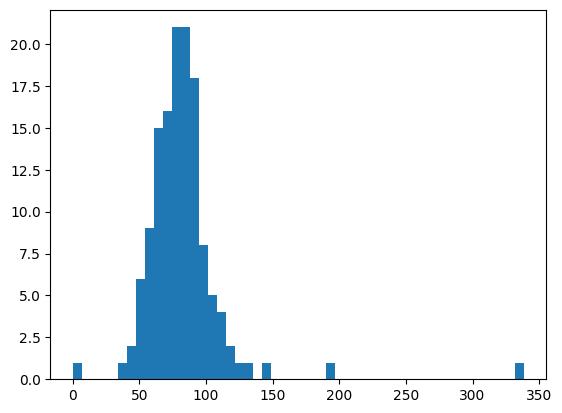

In [ ]:
plt.hist(data_for_visualize['creatinin'], bins=50)
data_for_visualize.describe().creatinin

##3.17 glucose

3.6-6.4
nên 16.7 có thể xảy ra

count    126.000000
mean       6.513095
std        2.290083
min        3.600000
25%        5.305000
50%        5.760000
75%        7.000000
max       16.730000
Name: glucose, dtype: float64

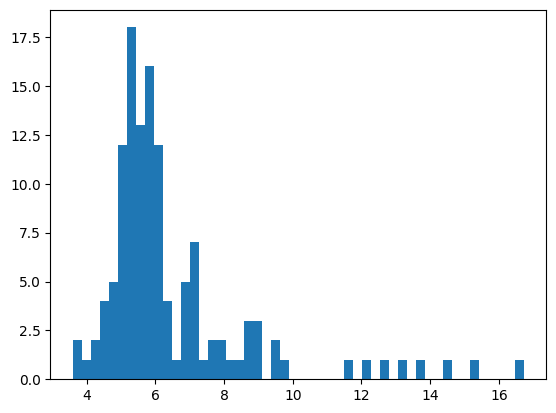

In [ ]:
plt.hist(data_for_visualize['glucose'], bins=50)
data_for_visualize.describe().glucose

##3.18 CA_19_9

<37 đã check giá trị lớn nhất từng gặp là 10320

count      117.000000
mean      1281.615726
std       5474.533595
min          0.600000
25%         10.910000
50%         27.170000
75%         75.650000
max      38545.000000
Name: CA_19_9, dtype: float64

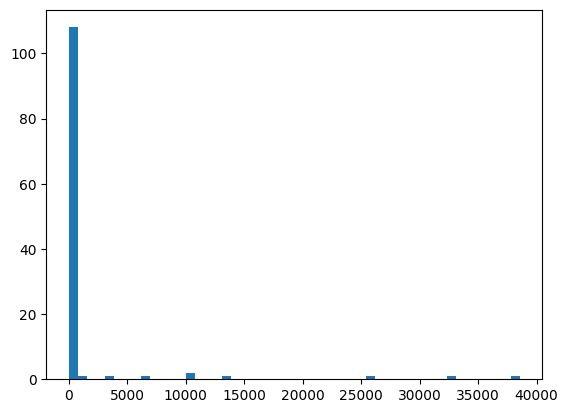

In [ ]:
plt.hist(data_for_visualize['CA_19_9'], bins=50)
data_for_visualize.describe().CA_19_9

In [ ]:
data_for_visualize

age gender  height  weight   bmi  red_blood_cell  white_blood_cell  \
2    74    Nam   162.0    67.0  25.5            4.22             13.60   
5    80    Nam   165.0    63.0  23.1            4.52              8.33   
6    50    Nam   170.0    65.0  22.5            4.81             12.33   
7    58    Nam     NaN     NaN   NaN            4.86              6.92   
27   60    Nam   162.0    50.0  19.1            1.93              9.39   
..   ..    ...     ...     ...   ...             ...               ...   
177  40    Nam   178.0    50.0  15.8            3.89              4.66   
184  51     Nữ   145.0    40.0  19.0            4.85              5.38   
185  70    Nam   170.0    75.0  26.0            4.31              8.89   
186  60    Nam   161.0    61.0  23.5            5.04              5.94   
187  63     Nữ   155.0    43.0  17.9            3.36              7.16   

     platelets   INR     AST  ...   ure  creatinin  glucose   CA_19_9    APRI  \
2        130.0  1.21     NaN  ...   NaN        NaN      NaN     90.61     NaN   
5        214.0  1.17   47.30  ...  4.52      68.43     4.94     57.41  0.5526   
6        237.0  1.02   33.29  ...  5.88      72.30     5.36     32.67  0.3512   
7        117.0  1.11  201.30  ...  8.08      78.82     5.92      1.54  4.3013   
27       373.0   NaN   45.41  ...  4.83      75.57     6.63  25489.00  0.3044   
..         ...   ...     ...  ...   ...        ...      ...       ...     ...   
177      205.0  1.19   17.00  ...  6.50      40.75     7.00       NaN  0.2073   
184      267.0  1.08   18.09  ...  4.30      55.44      NaN       NaN  0.1694   
185      190.0  1.04   26.74  ...  6.07      89.88     5.62     25.43  0.3518   
186      339.0   NaN   23.30  ...  3.95      75.73     5.88      8.12  0.1718   
187      151.0  1.07   31.97  ...   NaN      73.62     5.36      3.46  0.5293   

     AST/ALT   FIB-4       NFS BARD class  
2        NaN     NaN      1.77    0   1.0  
5     1.0831  2.6758   -0.3719    2   1.0  
6     1.2394  1.3551   -2.1842    2   0.0  
7     1.4536  8.4799   -2.0595    2   1.0  
27    1.5321  1.3417    -3.084    2   0.0  
..       ...     ...       ...  ...   ...  
177     0.85  0.7417   -2.5463    2   0.0  
184   1.4975  0.9942   -1.3619    3   0.0  
185   1.0237  1.9276   -0.6385    2   0.0  
186    0.601  0.6623    -3.929    0   0.0  
187   0.7933  2.1011   -1.1028    0   1.0  

[138 rows x 24 columns]

In [ ]:
data_for_visualize.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 2 to 187
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 138 non-null    object 
 1   gender              138 non-null    object 
 2   height              134 non-null    float64
 3   weight              134 non-null    float64
 4   bmi                 134 non-null    float64
 5   red_blood_cell      137 non-null    float64
 6   white_blood_cell    137 non-null    float64
 7   platelets           135 non-null    float64
 8   INR                 130 non-null    float64
 9   AST                 137 non-null    float64
 10  ALT                 136 non-null    float64
 11  total_bilirubin     131 non-null    float64
 12  indirect_bilirubin  122 non-null    float64
 13  albumin             118 non-null    float64
 14  ure                 134 non-null    float64
 15  creatinin           134 non-null    float64
 16  glucose      

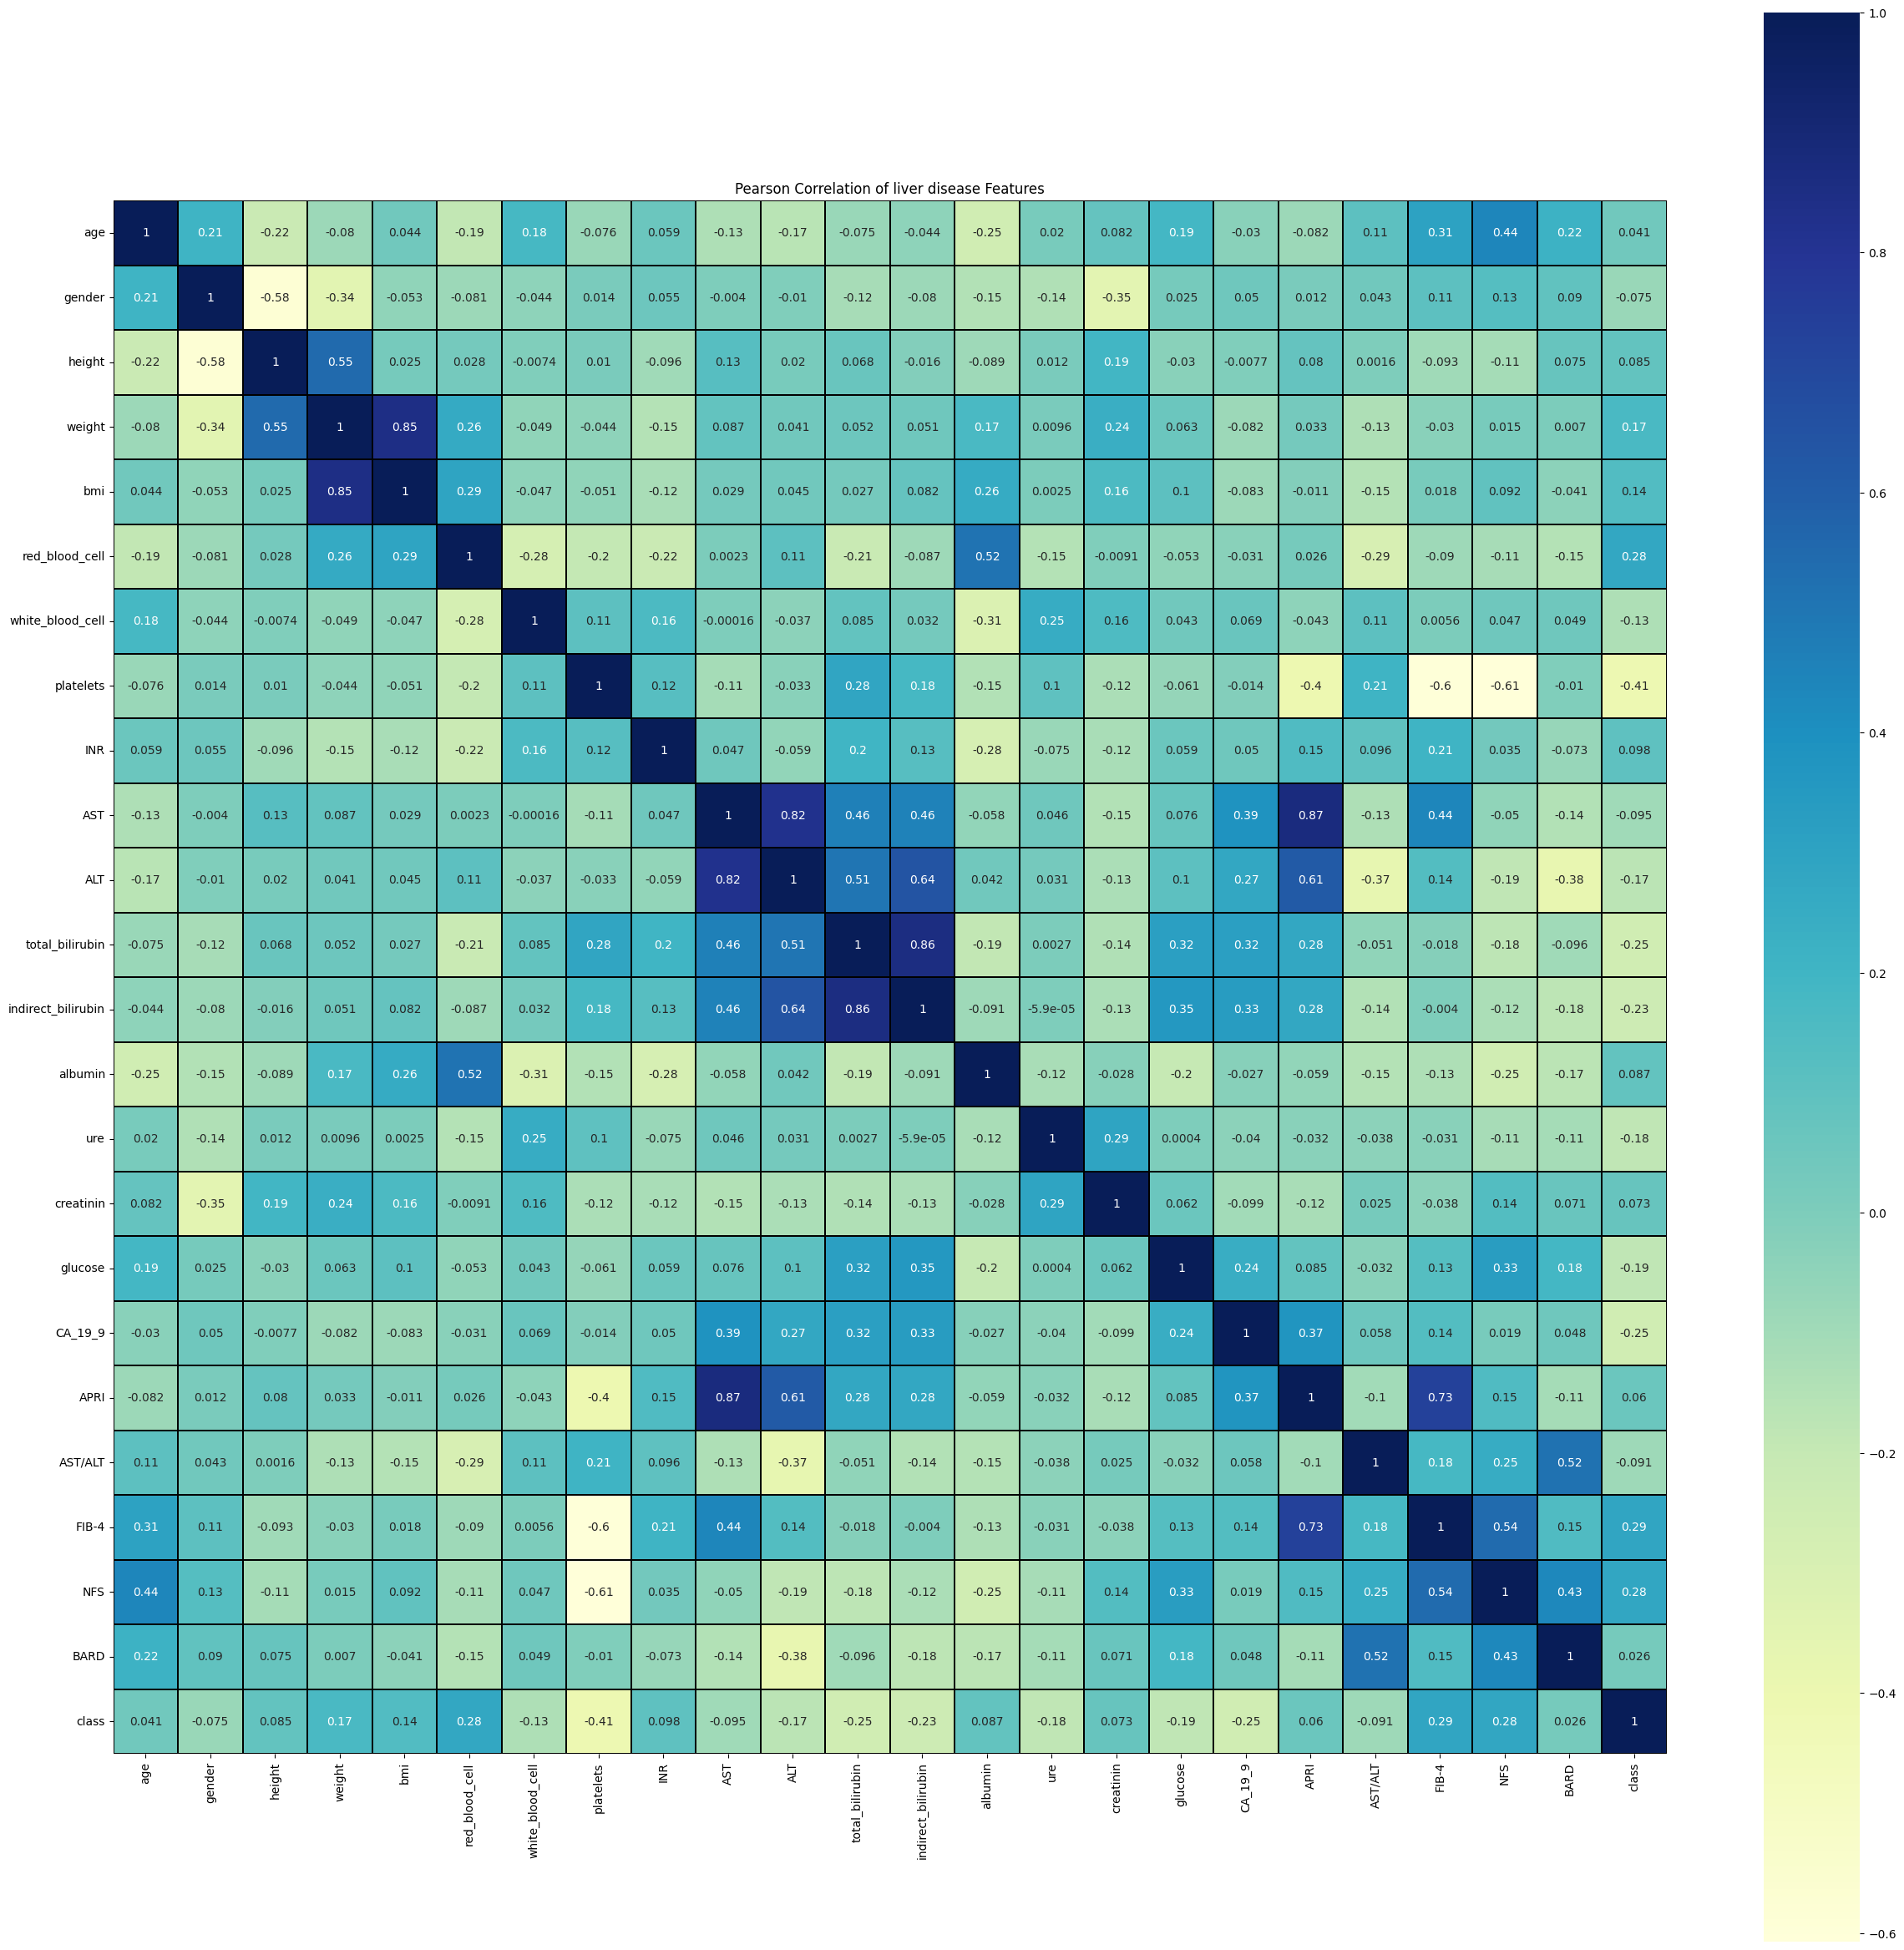

In [ ]:
# Assuming 'gender' is a categorical variable
# Encode 'gender' into numerical values
data_for_visualize['gender'] = data_for_visualize['gender'].map({'Nam': 0, 'Nữ': 1})

# Plot the correlation heatmap
f, ax = plt.subplots(figsize=(30, 30))
plt.title('Pearson Correlation of liver disease Features')
sns.heatmap(data_for_visualize.corr(), linewidths=0.25, vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True)
plt.show()

#4 Prepare Data for training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from numpy import mean
from numpy import std

In [ ]:
data_for_visualize

age  gender  height  weight   bmi  red_blood_cell  white_blood_cell  \
2    74       0   162.0    67.0  25.5            4.22             13.60   
5    80       0   165.0    63.0  23.1            4.52              8.33   
6    50       0   170.0    65.0  22.5            4.81             12.33   
7    58       0     NaN     NaN   NaN            4.86              6.92   
27   60       0   162.0    50.0  19.1            1.93              9.39   
..   ..     ...     ...     ...   ...             ...               ...   
177  40       0   178.0    50.0  15.8            3.89              4.66   
184  51       1   145.0    40.0  19.0            4.85              5.38   
185  70       0   170.0    75.0  26.0            4.31              8.89   
186  60       0   161.0    61.0  23.5            5.04              5.94   
187  63       1   155.0    43.0  17.9            3.36              7.16   

     platelets   INR     AST  ...   ure  creatinin  glucose   CA_19_9    APRI  \
2        130.0  1.21     NaN  ...   NaN        NaN      NaN     90.61     NaN   
5        214.0  1.17   47.30  ...  4.52      68.43     4.94     57.41  0.5526   
6        237.0  1.02   33.29  ...  5.88      72.30     5.36     32.67  0.3512   
7        117.0  1.11  201.30  ...  8.08      78.82     5.92      1.54  4.3013   
27       373.0   NaN   45.41  ...  4.83      75.57     6.63  25489.00  0.3044   
..         ...   ...     ...  ...   ...        ...      ...       ...     ...   
177      205.0  1.19   17.00  ...  6.50      40.75     7.00       NaN  0.2073   
184      267.0  1.08   18.09  ...  4.30      55.44      NaN       NaN  0.1694   
185      190.0  1.04   26.74  ...  6.07      89.88     5.62     25.43  0.3518   
186      339.0   NaN   23.30  ...  3.95      75.73     5.88      8.12  0.1718   
187      151.0  1.07   31.97  ...   NaN      73.62     5.36      3.46  0.5293   

     AST/ALT   FIB-4       NFS BARD class  
2        NaN     NaN      1.77    0   1.0  
5     1.0831  2.6758   -0.3719    2   1.0  
6     1.2394  1.3551   -2.1842    2   0.0  
7     1.4536  8.4799   -2.0595    2   1.0  
27    1.5321  1.3417    -3.084    2   0.0  
..       ...     ...       ...  ...   ...  
177     0.85  0.7417   -2.5463    2   0.0  
184   1.4975  0.9942   -1.3619    3   0.0  
185   1.0237  1.9276   -0.6385    2   0.0  
186    0.601  0.6623    -3.929    0   0.0  
187   0.7933  2.1011   -1.1028    0   1.0  

[138 rows x 24 columns]

In [ ]:
# X = data_for_visualize.drop(['class'], axis=1)
# y = data_for_visualize['class']

# X['gender'] = X['gender'].apply(lambda x: x.replace('Nữ','1'))
# X['gender'] = X['gender'].apply(lambda x: x.replace('Nam','0'))
# X = X._convert(numeric=True)

# knn_imputer = KNNImputer(n_neighbors=3)

# for i in X.columns:
#     X[i] = knn_imputer.fit_transform(X[[i]])

In [ ]:
X = data_for_visualize.drop(['class'], axis=1)
y = data_for_visualize['class']

# Convert integer gender values to string 'Nam' and 'Nữ'
X['gender'] = X['gender'].replace({0: 'Nam', 1: 'Nữ'})

# Convert gender column to string type
X['gender'] = X['gender'].astype(str)

# Convert 'gender' column to binary encoding
X['gender'] = X['gender'].replace({'Nữ': '1', 'Nam': '0'})

# Convert the entire dataframe to numeric type
X = X.apply(pd.to_numeric)

# Impute missing values using KNNImputer
knn_imputer = KNNImputer(n_neighbors=3)
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)


In [ ]:
# Convert gender column to numeric
X['gender'] = X['gender'].replace({'Nữ': 1, 'Nam': 0})

# Convert other columns to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=3)

# Impute missing values using KNNImputer
X_imputed = knn_imputer.fit_transform(X)

# Convert back to DataFrame
X = pd.DataFrame(X_imputed, columns=X.columns)

In [ ]:
X

age  gender  height     weight        bmi  red_blood_cell  \
0    74.0     0.0   162.0  67.000000  25.500000            4.22   
1    80.0     0.0   165.0  63.000000  23.100000            4.52   
2    50.0     0.0   170.0  65.000000  22.500000            4.81   
3    58.0     0.0   168.0  68.333333  24.266667            4.86   
4    60.0     0.0   162.0  50.000000  19.100000            1.93   
..    ...     ...     ...        ...        ...             ...   
133  40.0     0.0   178.0  50.000000  15.800000            3.89   
134  51.0     1.0   145.0  40.000000  19.000000            4.85   
135  70.0     0.0   170.0  75.000000  26.000000            4.31   
136  60.0     0.0   161.0  61.000000  23.500000            5.04   
137  63.0     1.0   155.0  43.000000  17.900000            3.36   

     white_blood_cell  platelets       INR         AST  ...    albumin  \
0               13.60      130.0  1.210000   45.153333  ...  35.366667   
1                8.33      214.0  1.170000   47.300000  ...  32.100000   
2               12.33      237.0  1.020000   33.290000  ...  39.700000   
3                6.92      117.0  1.110000  201.300000  ...  37.100000   
4                9.39      373.0  1.043333   45.410000  ...  31.700000   
..                ...        ...       ...         ...  ...        ...   
133              4.66      205.0  1.190000   17.000000  ...  30.500000   
134              5.38      267.0  1.080000   18.090000  ...  37.900000   
135              8.89      190.0  1.040000   26.740000  ...  38.500000   
136              5.94      339.0  1.073333   23.300000  ...  43.500000   
137              7.16      151.0  1.070000   31.970000  ...  34.300000   

          ure   creatinin   glucose       CA_19_9    APRI   AST/ALT     FIB-4  \
0    9.180000  176.136667  5.673333     90.610000  0.7676  0.909367  2.495567   
1    4.520000   68.430000  4.940000     57.410000  0.5526  1.083100  2.675800   
2    5.880000   72.300000  5.360000     32.670000  0.3512  1.239400  1.355100   
3    8.080000   78.820000  5.920000      1.540000  4.3013  1.453600  8.479900   
4    4.830000   75.570000  6.630000  25489.000000  0.3044  1.532100  1.341700   
..        ...         ...       ...           ...     ...       ...       ...   
133  6.500000   40.750000  7.000000     23.116667  0.2073  0.850000  0.741700   
134  4.300000   55.440000  5.093333     20.253333  0.1694  1.497500  0.994200   
135  6.070000   89.880000  5.620000     25.430000  0.3518  1.023700  1.927600   
136  3.950000   75.730000  5.880000      8.120000  0.1718  0.601000  0.662300   
137  4.346667   73.620000  5.360000      3.460000  0.5293  0.793300  2.101100   

        NFS  BARD  
0    1.7700   0.0  
1   -0.3719   2.0  
2   -2.1842   2.0  
3   -2.0595   2.0  
4   -3.0840   2.0  
..      ...   ...  
133 -2.5463   2.0  
134 -1.3619   3.0  
135 -0.6385   2.0  
136 -3.9290   0.0  
137 -1.1028   0.0  

[138 rows x 23 columns]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(110, 23)
(110,)
(28, 23)
(28,)


In [ ]:
X_train

age  gender  height  weight   bmi  red_blood_cell  white_blood_cell  \
102  44.0     0.0   172.0    60.0  20.3            4.30             10.48   
55   77.0     0.0   165.0    62.0  22.8            4.81              7.85   
98   73.0     0.0   165.0    48.0  17.6            3.28             21.65   
4    60.0     0.0   162.0    50.0  19.1            1.93              9.39   
135  70.0     0.0   170.0    75.0  26.0            4.31              8.89   
..    ...     ...     ...     ...   ...             ...               ...   
129  52.0     0.0   168.0    68.0  24.1            4.69              9.40   
79   48.0     0.0   159.0    46.0  18.2            4.99              3.51   
133  40.0     0.0   178.0    50.0  15.8            3.89              4.66   
72   69.0     0.0   164.0    41.0  15.2            3.71              9.02   
37   70.0     0.0   150.0    48.0  21.3            4.50              5.20   

     platelets       INR     AST  ...  albumin   ure  creatinin  glucose  \
102      165.0  1.340000  317.80  ...     35.0  3.56      63.18     6.77   
55       315.0  1.000000   27.36  ...     41.0  7.67     101.82     7.19   
98       287.0  1.040000   46.08  ...     23.6  4.99      92.44     6.03   
4        373.0  1.043333   45.41  ...     31.7  4.83      75.57     6.63   
135      190.0  1.040000   26.74  ...     38.5  6.07      89.88     5.62   
..         ...       ...     ...  ...      ...   ...        ...      ...   
129      309.0  0.970000   45.74  ...     44.8  6.49      82.41     5.97   
79       202.0  1.190000   61.65  ...     42.8  6.90      82.47     4.99   
133      205.0  1.190000   17.00  ...     30.5  6.50      40.75     7.00   
72       357.0  0.960000   17.07  ...     37.9  8.27      62.09     5.44   
37       183.0  1.200000   25.30  ...     42.6  6.40      82.00     5.48   

          CA_19_9    APRI  AST/ALT   FIB-4     NFS  BARD  
102  38545.000000  4.8152   1.4427  5.7100 -1.1655   2.0  
55      10.490000  0.2171   1.2649  1.4380 -1.1015   3.0  
98     114.200000  0.4014   1.7696  2.2969  0.2737   3.0  
4    25489.000000  0.3044   1.5321  1.3417 -3.0840   2.0  
135     25.430000  0.3518   1.0237  1.9276 -0.6385   2.0  
..            ...     ...      ...     ...     ...   ...  
129     12.720000  0.3701   0.8445  1.0459 -3.6233   2.0  
79       9.500000  0.7630   0.7830  1.6509 -2.8638   0.0  
133     23.116667  0.2073   0.8500  0.7417 -2.5463   2.0  
72      53.280000  0.1195   1.7121  1.0449 -3.1406   2.0  
37      10.910000  0.3456   1.2463  2.1479 -1.0396   2.0  

[110 rows x 23 columns]

In [ ]:
laboratory_parameter = [
    'APRI',
    'AST/ALT',
    'FIB-4',
    'NFS',
    'BARD'
]

scaler=StandardScaler()
X_train[list(X_train.drop(['gender'],axis=1).columns)]=scaler.fit_transform(X_train[list(X_train.drop(['gender'],axis=1).columns)])
X_test[list(X_test.drop(['gender'],axis=1).columns)]=scaler.transform(X_test[list(X_test.drop(['gender'],axis=1).columns)])

In [ ]:
X_train

age  gender    height    weight       bmi  red_blood_cell  \
102 -1.407937     0.0  1.487674  0.336273 -0.484384       -0.173037   
55   1.284799     0.0  0.406665  0.569895  0.422805        0.517552   
98   0.958406     0.0  0.406665 -1.065455 -1.464149       -1.554217   
4   -0.102368     0.0 -0.056624 -0.831834 -0.919835       -3.382248   
135  0.713612     0.0  1.178815  2.088433  1.584008       -0.159496   
..        ...     ...       ...       ...       ...             ...   
129 -0.755153     0.0  0.869955  1.270759  0.894544        0.355061   
79  -1.081545     0.0 -0.519914 -1.299076 -1.246424        0.761290   
133 -1.734330     0.0  2.414254 -0.831834 -2.117326       -0.728217   
72   0.632014     0.0  0.252235 -1.883130 -2.335051       -0.971955   
37   0.713612     0.0 -1.909783 -1.065455 -0.121508        0.097782   

     white_blood_cell  platelets       INR       AST  ...   albumin       ure  \
102          0.310608  -0.812908  1.889969  5.790621  ... -0.514902 -0.564793   
55          -0.106610   0.806711 -0.645658 -0.557335  ...  0.462526  0.369605   
98           2.082596   0.504382 -0.347349 -0.148185  ... -2.372015 -0.239686   
4            0.137693   1.432964 -0.322490 -0.162828  ... -1.052487 -0.276062   
135          0.058374  -0.542972 -0.347349 -0.570886  ...  0.055264  0.005849   
..                ...        ...       ...       ...  ...       ...       ...   
129          0.139279   0.741927 -0.869390 -0.155616  ...  1.081563  0.101335   
79          -0.795099  -0.413402  0.771310  0.192119  ...  0.755754  0.194547   
133         -0.612665  -0.381010  0.771310 -0.783767  ... -1.247973  0.103608   
72           0.078997   1.260205 -0.943967 -0.782237  ... -0.042479  0.506014   
37          -0.527000  -0.618554  0.845887 -0.602359  ...  0.723173  0.080874   

     creatinin   glucose   CA_19_9      APRI   AST/ALT     FIB-4       NFS  \
102  -0.610400  0.054477  6.652663  6.046330  0.428965  2.455019  0.009235   
55    0.507757  0.229827 -0.234758 -0.634141  0.128986 -0.499545  0.041866   
98    0.236320 -0.254472 -0.216222 -0.366376  0.980502  0.094480  0.743033   
4    -0.251861 -0.003973  4.319114 -0.507305  0.579798 -0.566147 -0.968941   
135   0.162239 -0.425646 -0.232088 -0.438439 -0.277960 -0.160932  0.277934   
..         ...       ...       ...       ...       ...       ...       ...   
129  -0.053926 -0.279521 -0.234359 -0.411851 -0.580301 -0.770726 -1.243911   
79   -0.052190 -0.688670 -0.234935  0.158984 -0.684063 -0.352301 -0.856669   
133  -1.259475  0.150502 -0.232501 -0.648380 -0.571022 -0.981114 -0.694787   
72   -0.641942 -0.500796 -0.227110 -0.775942  0.883489 -0.771417 -0.997799   
37   -0.065791 -0.484096 -0.234683 -0.447447  0.097604 -0.008570  0.073427   

         BARD  
102  0.260694  
55   1.284847  
98   1.284847  
4    0.260694  
135  0.260694  
..        ...  
129  0.260694  
79  -1.787613  
133  0.260694  
72   0.260694  
37   0.260694  

[110 rows x 23 columns]

In [ ]:
X_train_recommended1 = X_train[laboratory_parameter]
X_train.drop(laboratory_parameter, axis=1, inplace=True)
X_test_recommended1 = X_test[laboratory_parameter]
X_test.drop(laboratory_parameter, axis=1, inplace=True)

<Axes: title={'center': 'Pearson Correlation of liver disease Features'}>

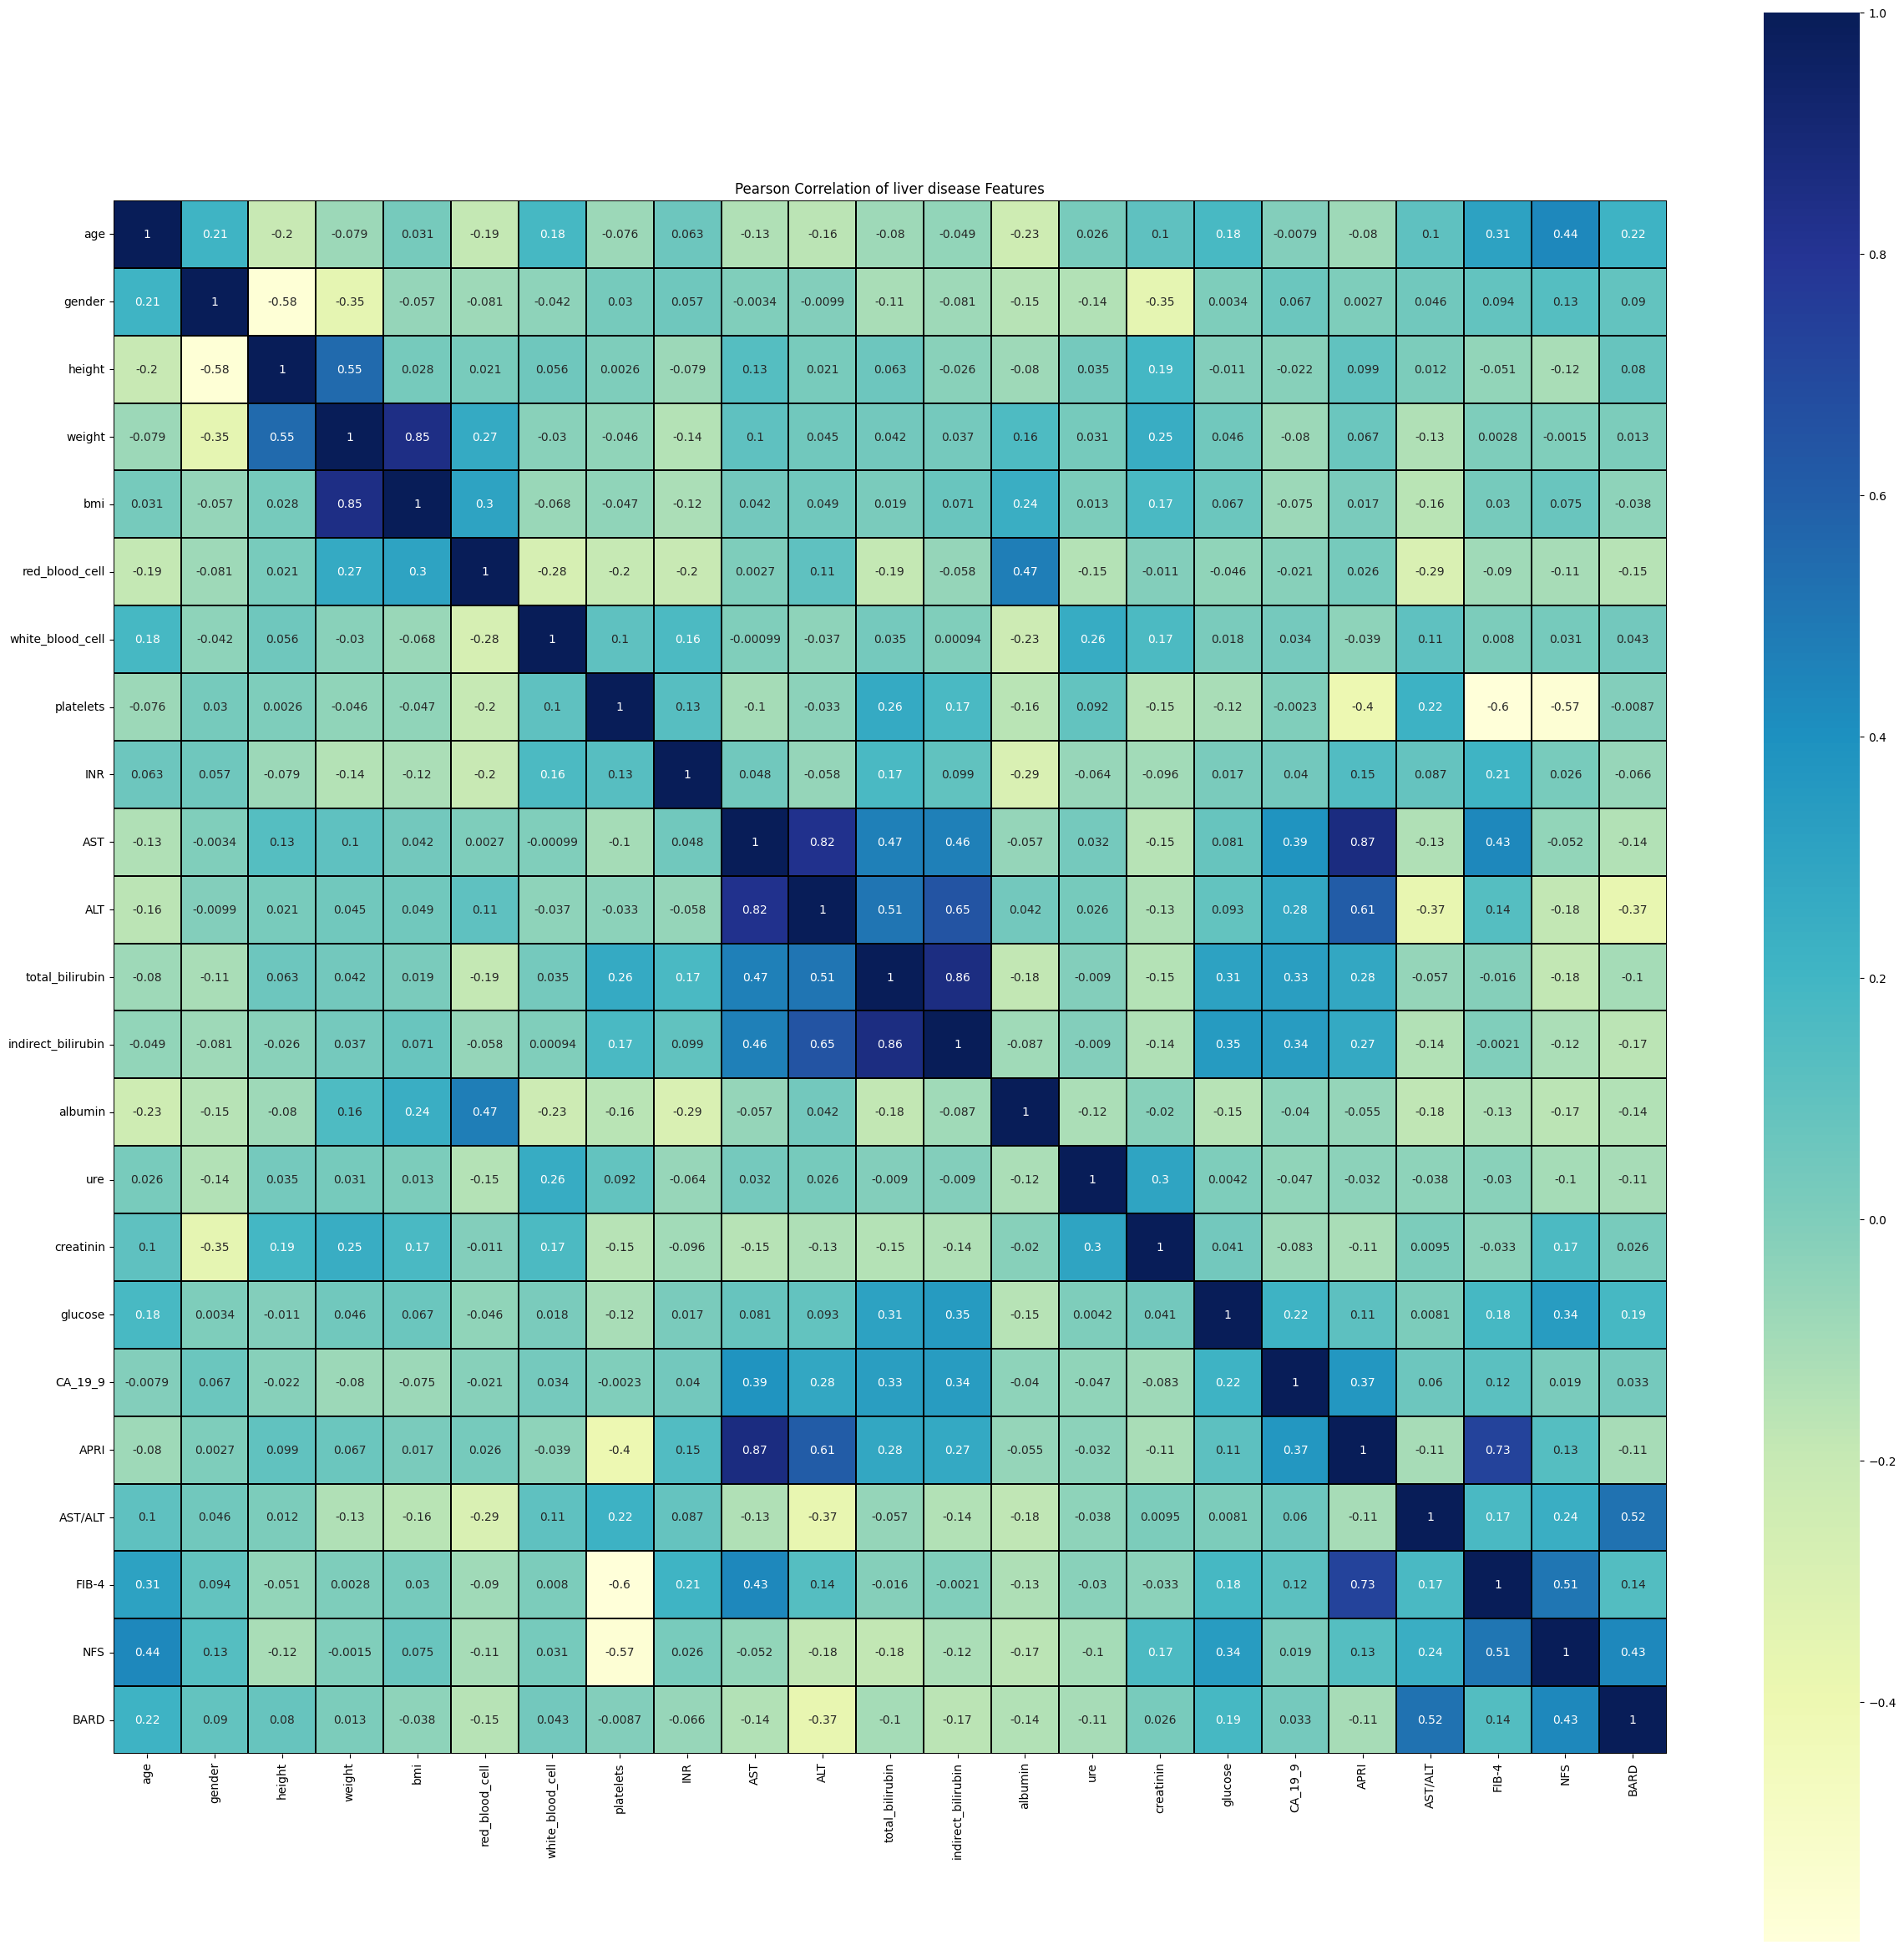

In [ ]:
f, ax = plt.subplots(figsize=(30, 30))
plt.title('Pearson Correlation of liver disease Features')
# Draw the heatmap using seaborn
sns.heatmap(X.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black',annot=True)

#5 Train

##Preparing function

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from xgboost import XGBClassifier

# from sklearn.metrics import classification_report,confusion_matrix
# from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score

# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import KFold
# from numpy import mean
# from numpy import std

In [ ]:
def get_mean_best_feature(models, X, model_name, data_name):
    score_mean = []
    best_feature = X.columns
    for model in models:
        importances = model.feature_importances_
        score = []
        for feature, importance in zip(X.columns, importances):
            score.append(importance)
        score_mean.append(score)
    score_mean = np.array(score_mean)
    score_mean = np.mean(score_mean, axis=0)
    sorted_idx = score_mean.argsort()
#     print(score_mean)
#     print(best_feature)
    plt.barh(best_feature[sorted_idx], score_mean[sorted_idx], color = ['red' if score >=0.0755 else 'blue' for score in score_mean[sorted_idx]])
    plt.xlabel(f"{model_name} Feature Importance")
    plt.savefig(f'get_mean_best_feature{model_name}{data_name}.svg', format='eps', dpi=150)

    plt.show()

In [ ]:
def get_best_feature(model, X_train):
    importances = model.feature_importances_
    best_feature = []
    score = []
    # Liệt kê mức độ quan trọng của từng đặc trưng
    for feature, importance in zip(X_train.columns, importances):
        best_feature.append(feature)
        score.append(importance)
    plt.bar(best_feature, score, color='blue')
    plt.xticks(rotation=90)
    plt.title('')
    plt.show()

In [ ]:
def specificity_score(y_true, y_pred):
  conf_matrix = confusion_matrix(y_true, y_pred, labels = [1,0])

# Lấy giá trị True Negative (TN) và False Positive (FP)
  TN = conf_matrix[1][1]
  FP = conf_matrix[1][0]

  # Tính Specificity
  specificity = TN / (TN + FP)

  return specificity

In [ ]:
def get_metrics(y_test,y_hat):
  acc = accuracy_score(y_test, y_hat)
  recall = recall_score(y_test, y_hat)
  precision = precision_score(y_test, y_hat)
  specificity = specificity_score(y_test, y_hat)
  auc_roc = roc_auc_score(y_test, y_hat)
  return acc, recall, precision, specificity, auc_roc


In [ ]:
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)

##5.1 Random Forest (RF)

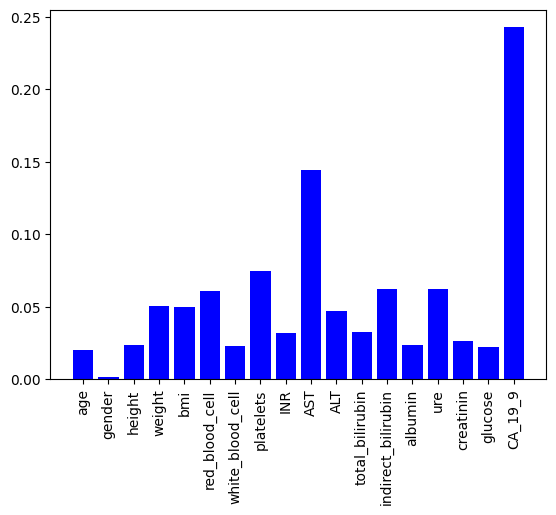

-------------------------------------------------------
[[6 1]
 [1 3]]
-------------------------------------------------------
[[16  1]
 [ 2  9]]
Fold 1: >acc=0.818, recall=0.857, precision=0.857, specificity=0.750, auc_roc=0.804, est=0.788, cfg={'n_estimators': 470, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 11}
Fold 1: >acc=0.893, recall=0.941, precision=0.889, specificity=0.818, auc_roc=0.880, est=0.788, cfg={'n_estimators': 470, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 11}


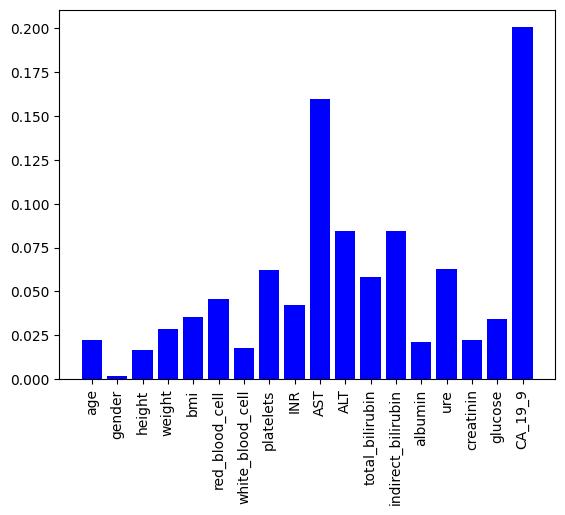

-------------------------------------------------------
[[2 0]
 [3 6]]
-------------------------------------------------------
[[16  1]
 [ 4  7]]
Fold 2: >acc=0.727, recall=1.000, precision=0.400, specificity=0.667, auc_roc=0.833, est=0.677, cfg={'n_estimators': 290, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 7, 'max_depth': 10}
Fold 2: >acc=0.821, recall=0.941, precision=0.800, specificity=0.636, auc_roc=0.789, est=0.677, cfg={'n_estimators': 290, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 7, 'max_depth': 10}


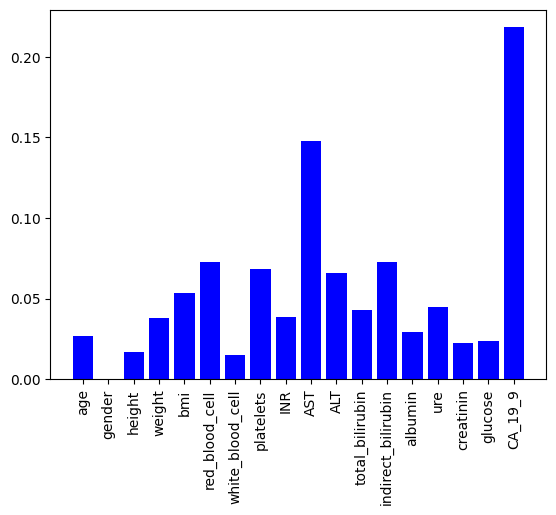

-------------------------------------------------------
[[7 1]
 [1 2]]
-------------------------------------------------------
[[16  1]
 [ 2  9]]
Fold 3: >acc=0.818, recall=0.875, precision=0.875, specificity=0.667, auc_roc=0.771, est=0.676, cfg={'n_estimators': 270, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 5}
Fold 3: >acc=0.893, recall=0.941, precision=0.889, specificity=0.818, auc_roc=0.880, est=0.676, cfg={'n_estimators': 270, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 5}


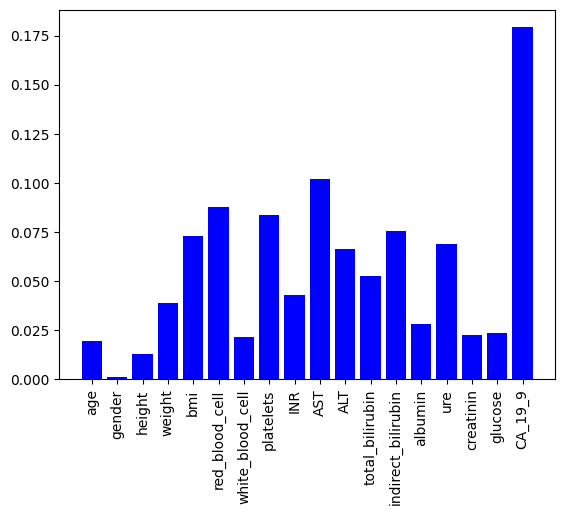

-------------------------------------------------------
[[7 0]
 [3 1]]
-------------------------------------------------------
[[16  1]
 [ 3  8]]
Fold 4: >acc=0.727, recall=1.000, precision=0.700, specificity=0.250, auc_roc=0.625, est=0.715, cfg={'n_estimators': 290, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 7, 'max_depth': 10}
Fold 4: >acc=0.857, recall=0.941, precision=0.842, specificity=0.727, auc_roc=0.834, est=0.715, cfg={'n_estimators': 290, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 7, 'max_depth': 10}


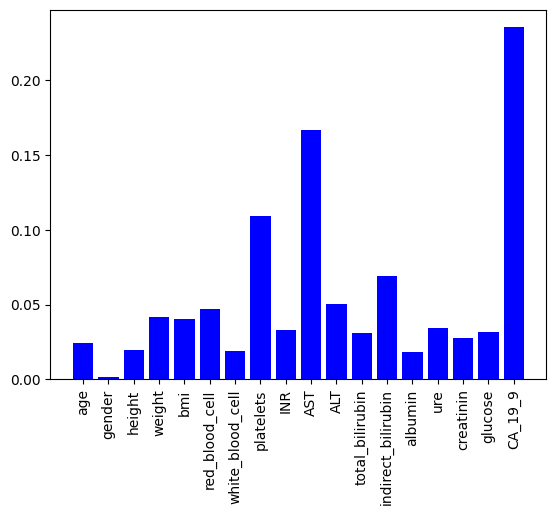

-------------------------------------------------------
[[9 0]
 [2 0]]
-------------------------------------------------------
[[16  1]
 [ 3  8]]
Fold 5: >acc=0.818, recall=1.000, precision=0.818, specificity=0.000, auc_roc=0.500, est=0.767, cfg={'n_estimators': 270, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 5}
Fold 5: >acc=0.857, recall=0.941, precision=0.842, specificity=0.727, auc_roc=0.834, est=0.767, cfg={'n_estimators': 270, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 5}


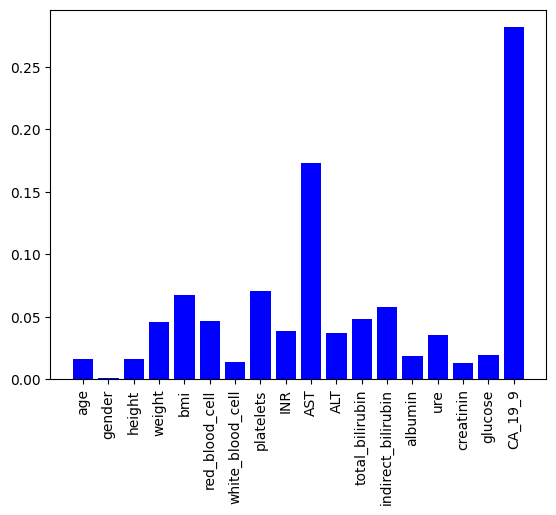

-------------------------------------------------------
[[2 3]
 [3 3]]
-------------------------------------------------------
[[16  1]
 [ 3  8]]
Fold 6: >acc=0.455, recall=0.400, precision=0.400, specificity=0.500, auc_roc=0.450, est=0.848, cfg={'n_estimators': 470, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 11}
Fold 6: >acc=0.857, recall=0.941, precision=0.842, specificity=0.727, auc_roc=0.834, est=0.848, cfg={'n_estimators': 470, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 11}


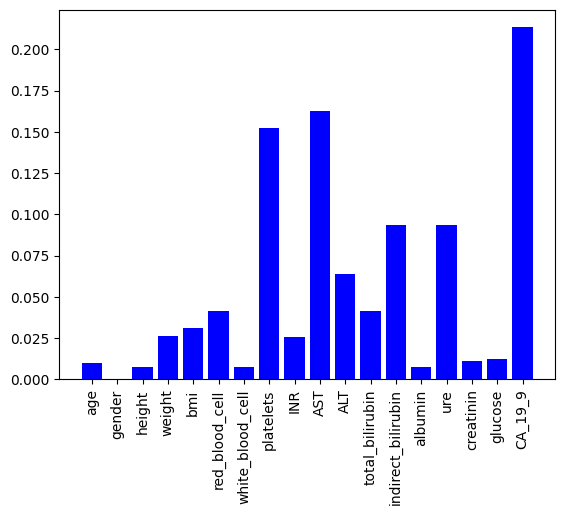

-------------------------------------------------------
[[8 0]
 [0 3]]
-------------------------------------------------------
[[16  1]
 [ 3  8]]
Fold 7: >acc=1.000, recall=1.000, precision=1.000, specificity=1.000, auc_roc=1.000, est=0.788, cfg={'n_estimators': 420, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 7, 'max_depth': 2}
Fold 7: >acc=0.857, recall=0.941, precision=0.842, specificity=0.727, auc_roc=0.834, est=0.788, cfg={'n_estimators': 420, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 7, 'max_depth': 2}


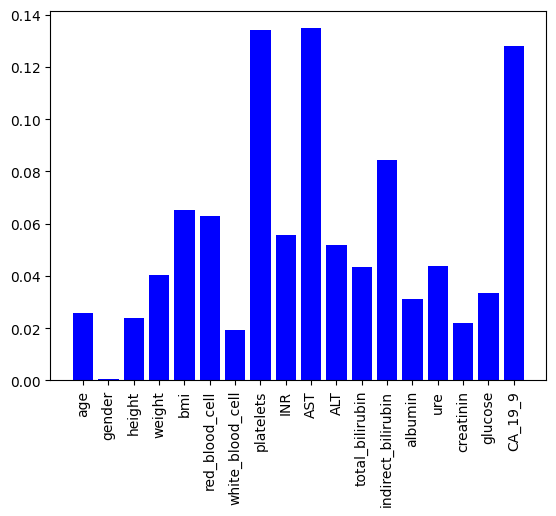

-------------------------------------------------------
[[6 1]
 [1 3]]
-------------------------------------------------------
[[16  1]
 [ 1 10]]
Fold 8: >acc=0.818, recall=0.857, precision=0.857, specificity=0.750, auc_roc=0.804, est=0.816, cfg={'n_estimators': 270, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 5}
Fold 8: >acc=0.929, recall=0.941, precision=0.941, specificity=0.909, auc_roc=0.925, est=0.816, cfg={'n_estimators': 270, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 5}


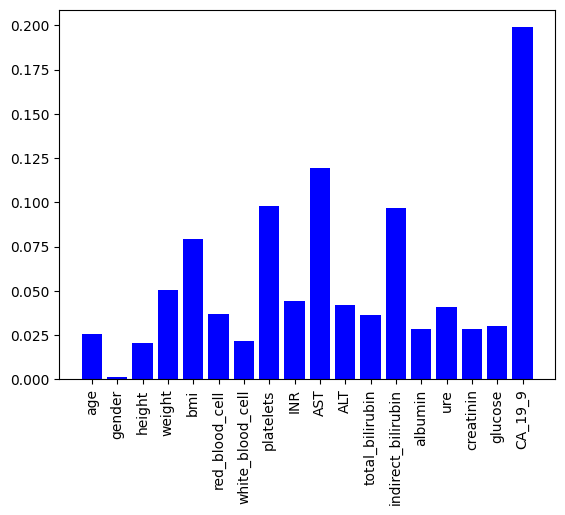

-------------------------------------------------------
[[6 1]
 [2 2]]
-------------------------------------------------------
[[15  2]
 [ 2  9]]
Fold 9: >acc=0.727, recall=0.857, precision=0.750, specificity=0.500, auc_roc=0.679, est=0.786, cfg={'n_estimators': 470, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 11}
Fold 9: >acc=0.857, recall=0.882, precision=0.882, specificity=0.818, auc_roc=0.850, est=0.786, cfg={'n_estimators': 470, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 11}


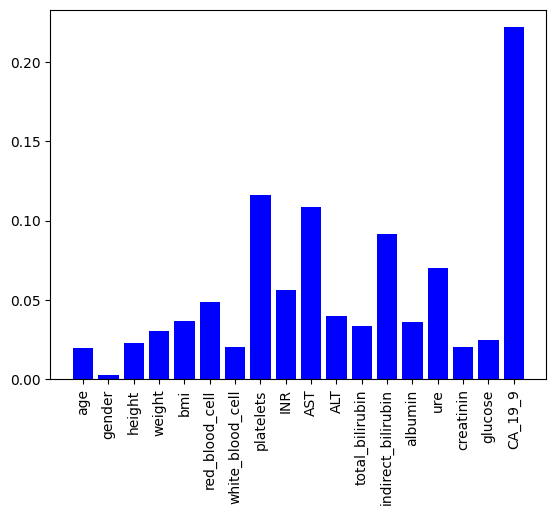

-------------------------------------------------------
[[6 1]
 [2 2]]
-------------------------------------------------------
[[15  2]
 [ 3  8]]
Fold 10: >acc=0.727, recall=0.857, precision=0.750, specificity=0.500, auc_roc=0.679, est=0.788, cfg={'n_estimators': 270, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 5}
Fold 10: >acc=0.821, recall=0.882, precision=0.833, specificity=0.727, auc_roc=0.805, est=0.788, cfg={'n_estimators': 270, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 13, 'max_depth': 5}
Result in Train
Accuracy: 0.764 (0.130)
Recall: 0.870 (0.170)
Precision: 0.741 (0.188)
Specificity: 0.558 (0.266)
AUROC: 0.714 (0.155)
Result in test
Accuracy: 0.864 (0.031)
Recall: 0.929 (0.024)
Precision: 0.860 (0.038)
Specificity: 0.764 (0.073)
AUROC: 0.847 (0.038)


In [ ]:
# enumerate splits
outer_results_acc_f = list()
outer_results_recall_f = list()
outer_results_precision_f = list()
outer_results_specificity_f  = list()
outer_results_auroc_f = list()

outer_results_acc = list()
outer_results_recall = list()
outer_results_precision = list()
outer_results_specificity  = list()
outer_results_auroc = list()


outer_models_RF = list()

i = 1
for train_ix, test_ix in cv_outer.split(X_train):
    # split data
    X_train_f, X_test_f = X_train.iloc[train_ix, :], X_train.iloc[test_ix, :]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]
    # define the model
    model = RandomForestClassifier(random_state=1)
    # define search spaceiii
    search_dict = {
                    'n_estimators': [i for i in range(100,500,10)],
                    'max_features': [i for i in range(2,15)],
                    'max_depth': [i for i in range(2,15)],
                    'min_samples_split': [i for i in range(2,7,1)],
                    'min_samples_leaf': [i for i in range(2,7,1)]
    }
    # define search
    search = HalvingRandomSearchCV(model, search_dict, scoring='precision', refit=True,n_jobs=-1, random_state=1)
    # execute search
    result = search.fit(X_train_f, y_train_f)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    #get best feature
    get_best_feature(best_model,X_train_f)


    # evaluate model on the hold out dataset
    yhat_f = best_model.predict(X_test_f)
    # evaluate the model

    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f)
    # store the result
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)


    yhat = best_model.predict(X_test)
    # evaluate the model
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat)
    # store the result
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)


    outer_models_RF.append(best_model)


    # report progress
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test_f, yhat_f, labels=[1,0]))
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test, yhat, labels=[1,0]))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f, result.best_score_, result.best_params_))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc, recall, precision, specificity, auc_roc, result.best_score_, result.best_params_))


    i = i+1
# summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc_f), std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall_f), std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision_f), std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity_f), std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc_f), std(outer_results_auroc_f)))

print('Result in test')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc), std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity), std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc), std(outer_results_auroc)))

In [ ]:
# Result in Train
# Accuracy: 0.764 (0.130)
# Recall: 0.870 (0.170)
# Precision: 0.741 (0.188)
# Specificity: 0.558 (0.266)
# AUROC: 0.714 (0.155)
# Result in test
# Accuracy: 0.864 (0.031)
# Recall: 0.929 (0.024)
# Precision: 0.860 (0.038)
# Specificity: 0.764 (0.073)
# AUROC: 0.847 (0.038)

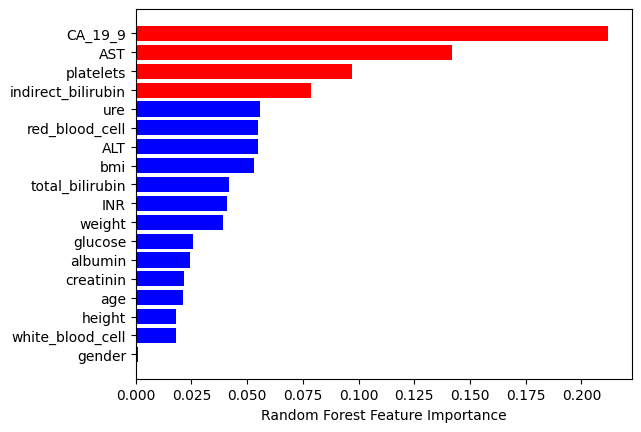

In [ ]:
get_mean_best_feature(outer_models_RF,X,'Random Forest','vdLiver')

##5.2 Extra Trees (ET)

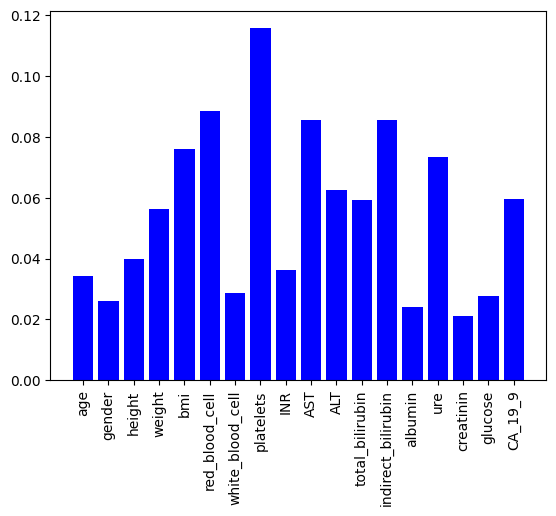

-------------------------------------------------------
[[6 1]
 [1 3]]
-------------------------------------------------------
[[16  1]
 [ 3  8]]
Fold 1: >acc=0.818, recall=0.857, precision=0.857, specificity=0.750, auc_roc=0.804, est=0.780, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}
Fold 1: >acc=0.857, recall=0.941, precision=0.842, specificity=0.727, auc_roc=0.834, est=0.780, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}


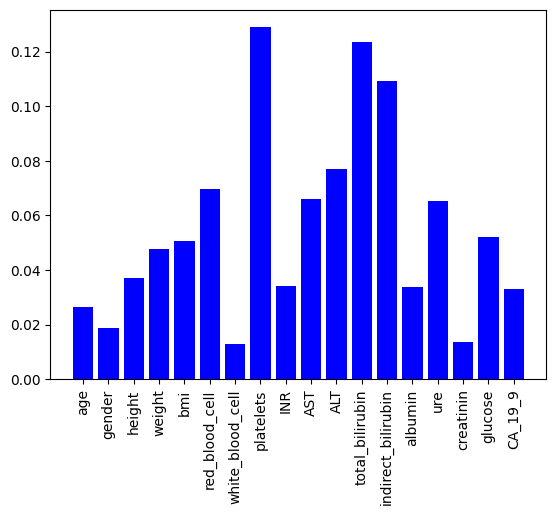

-------------------------------------------------------
[[2 0]
 [8 1]]
-------------------------------------------------------
[[16  1]
 [11  0]]
Fold 2: >acc=0.273, recall=1.000, precision=0.200, specificity=0.111, auc_roc=0.556, est=0.612, cfg={'n_estimators': 190, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': 14}
Fold 2: >acc=0.571, recall=0.941, precision=0.593, specificity=0.000, auc_roc=0.471, est=0.612, cfg={'n_estimators': 190, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': 14}


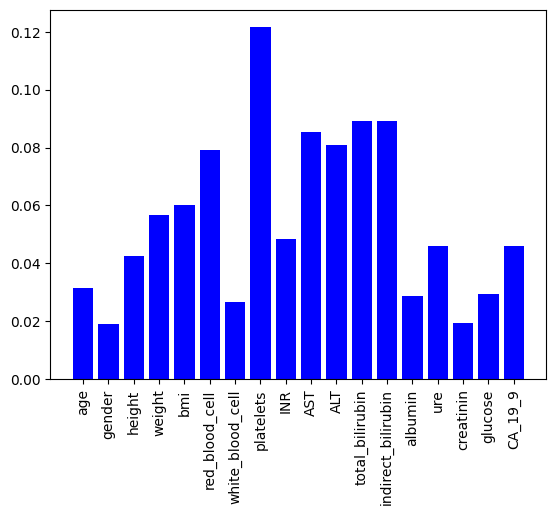

-------------------------------------------------------
[[8 0]
 [2 1]]
-------------------------------------------------------
[[16  1]
 [ 3  8]]
Fold 3: >acc=0.818, recall=1.000, precision=0.800, specificity=0.333, auc_roc=0.667, est=0.597, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}
Fold 3: >acc=0.857, recall=0.941, precision=0.842, specificity=0.727, auc_roc=0.834, est=0.597, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}


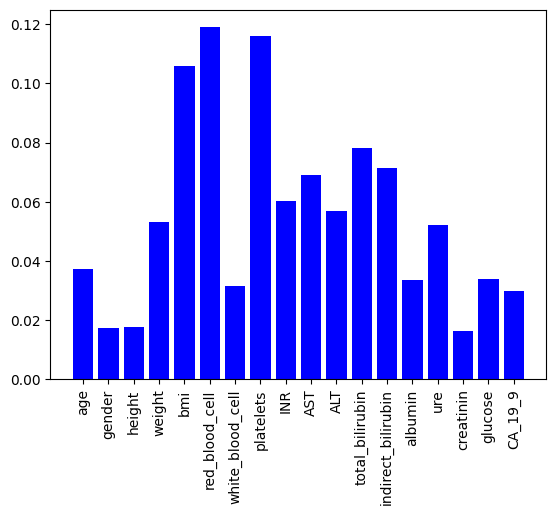

-------------------------------------------------------
[[6 1]
 [3 1]]
-------------------------------------------------------
[[16  1]
 [ 4  7]]
Fold 4: >acc=0.636, recall=0.857, precision=0.667, specificity=0.250, auc_roc=0.554, est=0.680, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}
Fold 4: >acc=0.821, recall=0.941, precision=0.800, specificity=0.636, auc_roc=0.789, est=0.680, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}


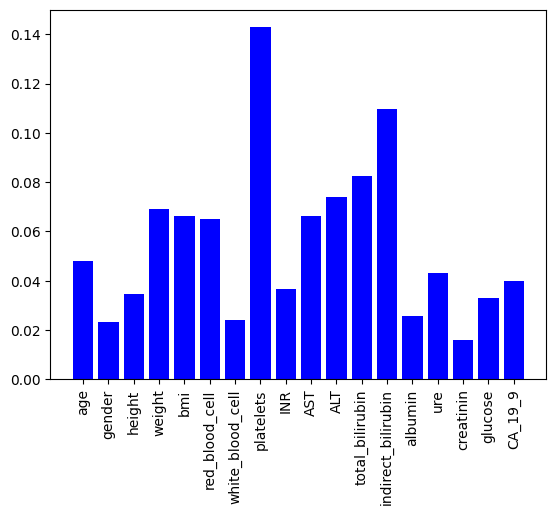

-------------------------------------------------------
[[9 0]
 [2 0]]
-------------------------------------------------------
[[16  1]
 [ 2  9]]
Fold 5: >acc=0.818, recall=1.000, precision=0.818, specificity=0.000, auc_roc=0.500, est=0.765, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}
Fold 5: >acc=0.893, recall=0.941, precision=0.889, specificity=0.818, auc_roc=0.880, est=0.765, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}


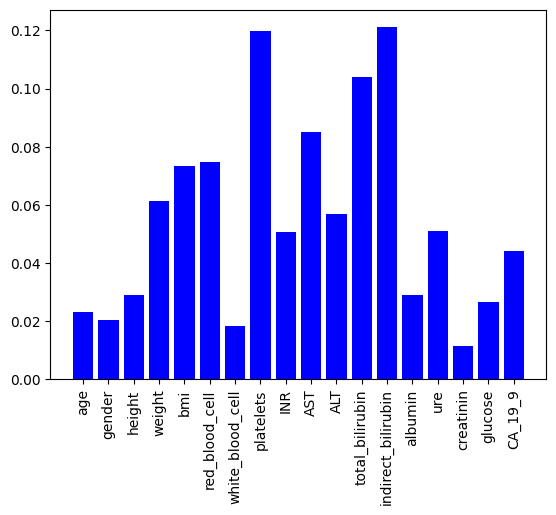

-------------------------------------------------------
[[4 1]
 [4 2]]
-------------------------------------------------------
[[16  1]
 [ 4  7]]
Fold 6: >acc=0.545, recall=0.800, precision=0.500, specificity=0.333, auc_roc=0.567, est=0.765, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}
Fold 6: >acc=0.821, recall=0.941, precision=0.800, specificity=0.636, auc_roc=0.789, est=0.765, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}


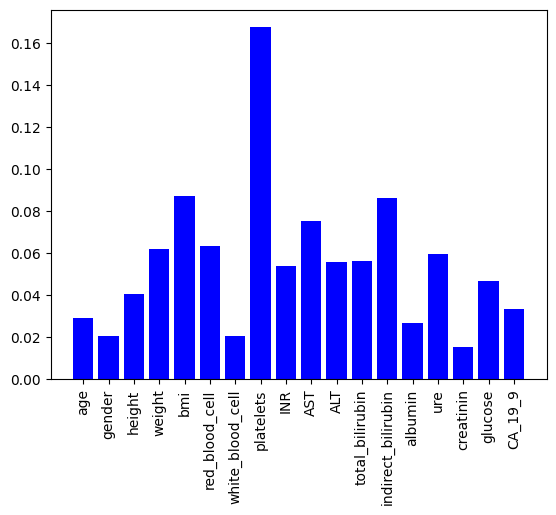

-------------------------------------------------------
[[7 1]
 [0 3]]
-------------------------------------------------------
[[16  1]
 [ 2  9]]
Fold 7: >acc=0.909, recall=0.875, precision=1.000, specificity=1.000, auc_roc=0.938, est=0.748, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}
Fold 7: >acc=0.893, recall=0.941, precision=0.889, specificity=0.818, auc_roc=0.880, est=0.748, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}


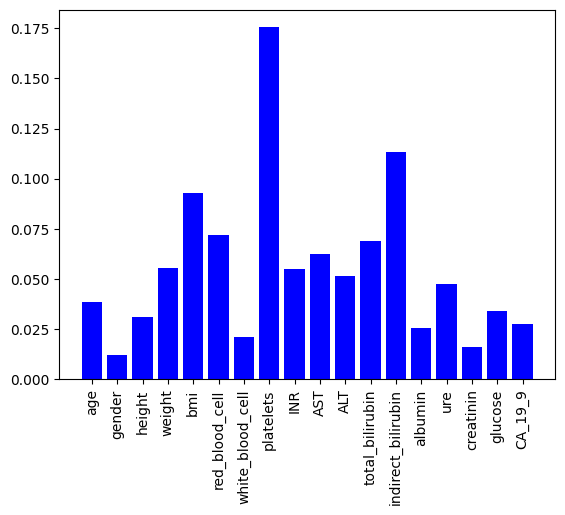

-------------------------------------------------------
[[5 2]
 [1 3]]
-------------------------------------------------------
[[16  1]
 [ 2  9]]
Fold 8: >acc=0.727, recall=0.714, precision=0.833, specificity=0.750, auc_roc=0.732, est=0.765, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}
Fold 8: >acc=0.893, recall=0.941, precision=0.889, specificity=0.818, auc_roc=0.880, est=0.765, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}


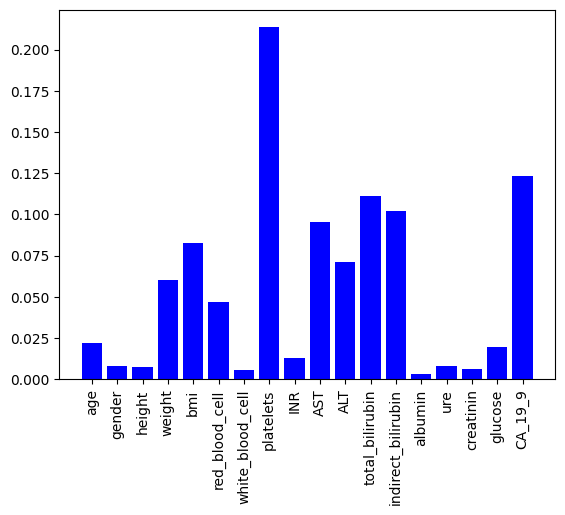

-------------------------------------------------------
[[7 0]
 [2 2]]
-------------------------------------------------------
[[16  1]
 [ 8  3]]
Fold 9: >acc=0.818, recall=1.000, precision=0.778, specificity=0.500, auc_roc=0.750, est=0.714, cfg={'n_estimators': 220, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': 2}
Fold 9: >acc=0.679, recall=0.941, precision=0.667, specificity=0.273, auc_roc=0.607, est=0.714, cfg={'n_estimators': 220, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': 2}


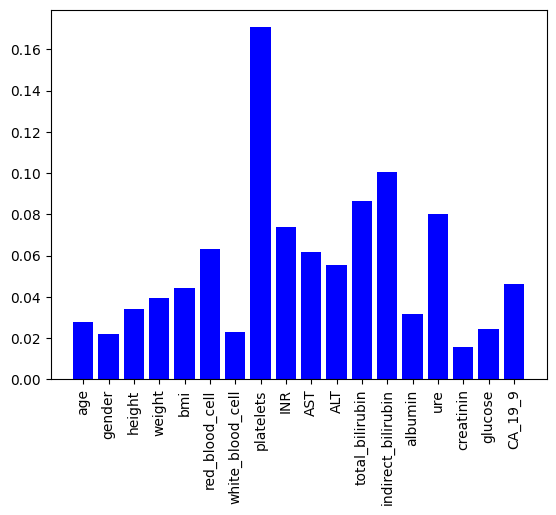

-------------------------------------------------------
[[6 1]
 [2 2]]
-------------------------------------------------------
[[15  2]
 [ 2  9]]
Fold 10: >acc=0.727, recall=0.857, precision=0.750, specificity=0.500, auc_roc=0.679, est=0.797, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}
Fold 10: >acc=0.857, recall=0.882, precision=0.882, specificity=0.818, auc_roc=0.850, est=0.797, cfg={'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 11}
Result in Train
Accuracy: 0.709 (0.176)
Recall: 0.896 (0.095)
Precision: 0.720 (0.213)
Specificity: 0.453 (0.295)
AUROC: 0.674 (0.129)
Result in test
Accuracy: 0.814 (0.101)
Recall: 0.935 (0.018)
Precision: 0.809 (0.097)
Specificity: 0.627 (0.262)
AUROC: 0.781 (0.129)


In [ ]:
# enumerate splits
outer_results_acc_f = list()
outer_results_recall_f = list()
outer_results_precision_f = list()
outer_results_specificity_f  = list()
outer_results_auroc_f = list()

outer_results_acc = list()
outer_results_recall = list()
outer_results_precision = list()
outer_results_specificity  = list()
outer_results_auroc = list()


outer_models_ET = list()

i = 1
for train_ix, test_ix in cv_outer.split(X_train):
    # split data
    X_train_f, X_test_f = X_train.iloc[train_ix, :], X_train.iloc[test_ix, :]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]
    # define the model
    model = ExtraTreesClassifier(random_state=1)
    # define search space
    search_dict = {
                    'n_estimators': [i for i in range(50,300,10)],
                    'max_features': [i for i in range(2,15)],
                    'max_depth': [i for i in range(2,15)],
                    'min_samples_split': [i for i in range(2,7, 1)],
                    'min_samples_leaf': [i for i in range(2,7,1)]
    }
    # define search
    search = HalvingRandomSearchCV(model, search_dict, scoring='accuracy', refit=True, random_state=1)
    # execute search
    result = search.fit(X_train_f, y_train_f)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    #get best feature
    get_best_feature(best_model,X_train_f)


    # evaluate model on the hold out dataset
    yhat_f = best_model.predict(X_test_f)
    # evaluate the model

    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f)
    # store the result
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)


    yhat = best_model.predict(X_test)
    # evaluate the model
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat)
    # store the result
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)


    outer_models_ET.append(best_model)


    # report progress
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test_f, yhat_f, labels=[1,0]))
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test, yhat, labels=[1,0]))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f, result.best_score_, result.best_params_))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc, recall, precision, specificity, auc_roc, result.best_score_, result.best_params_))


    i = i+1
# summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc_f), std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall_f), std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision_f), std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity_f), std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc_f), std(outer_results_auroc_f)))

print('Result in test')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc), std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity), std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc), std(outer_results_auroc)))

In [ ]:
# Result in Train
# Accuracy: 0.709 (0.176)
# Recall: 0.896 (0.095)
# Precision: 0.720 (0.213)
# Specificity: 0.453 (0.295)
# AUROC: 0.674 (0.129)
# Result in test
# Accuracy: 0.814 (0.101)
# Recall: 0.935 (0.018)
# Precision: 0.809 (0.097)
# Specificity: 0.627 (0.262)
# AUROC: 0.781 (0.129)

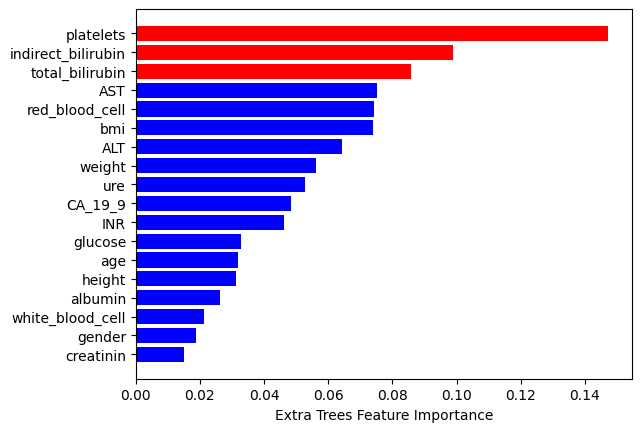

In [ ]:
get_mean_best_feature(outer_models_ET,X,'Extra Trees','vdLiver')

##5.3 Ada Boosts (Ada)

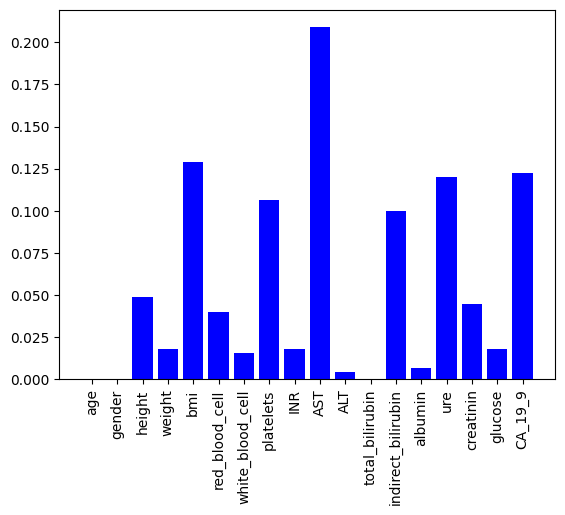

Fold 1: >acc=0.818, recall=0.857, precision=0.857, specificity=0.750, auc_roc=0.804, est=0.714, cfg={'n_estimators': 450, 'learning_rate': 0.05}
Fold 1: >acc=0.893, recall=0.882, precision=0.938, specificity=0.909, auc_roc=0.896, est=0.714, cfg={'n_estimators': 450, 'learning_rate': 0.05}


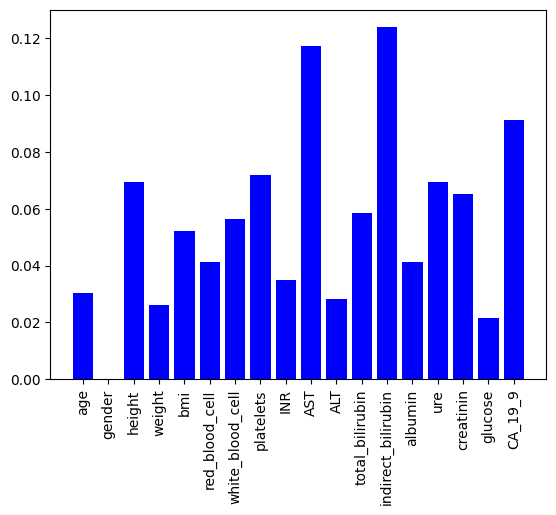

Fold 2: >acc=0.818, recall=1.000, precision=0.500, specificity=0.778, auc_roc=0.889, est=0.715, cfg={'n_estimators': 460, 'learning_rate': 0.19}
Fold 2: >acc=0.750, recall=0.824, precision=0.778, specificity=0.636, auc_roc=0.730, est=0.715, cfg={'n_estimators': 460, 'learning_rate': 0.19}


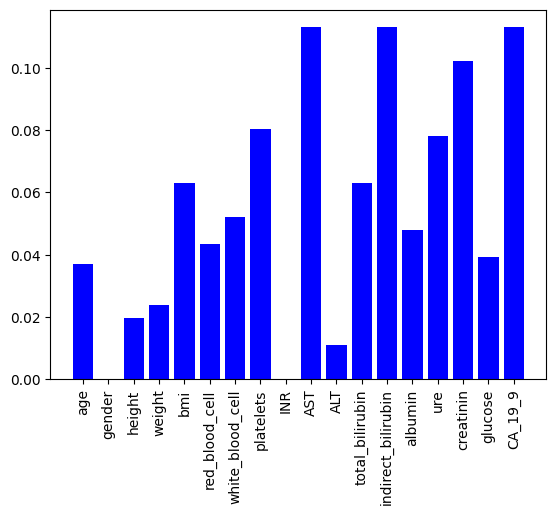

Fold 3: >acc=0.909, recall=0.875, precision=1.000, specificity=1.000, auc_roc=0.938, est=0.715, cfg={'n_estimators': 460, 'learning_rate': 0.19}
Fold 3: >acc=0.821, recall=0.882, precision=0.833, specificity=0.727, auc_roc=0.805, est=0.715, cfg={'n_estimators': 460, 'learning_rate': 0.19}


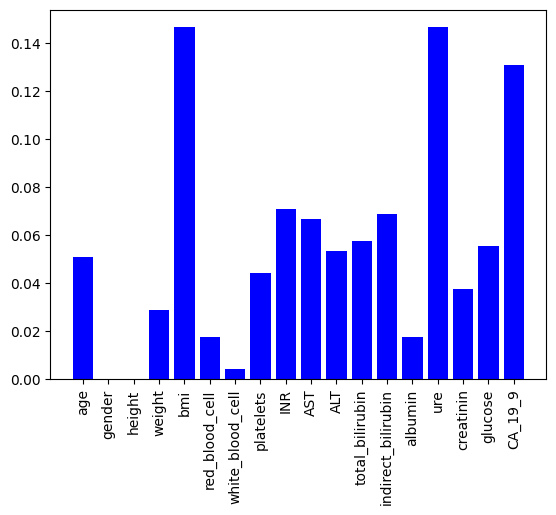

Fold 4: >acc=0.636, recall=0.857, precision=0.667, specificity=0.250, auc_roc=0.554, est=0.748, cfg={'n_estimators': 450, 'learning_rate': 0.05}
Fold 4: >acc=0.750, recall=0.824, precision=0.778, specificity=0.636, auc_roc=0.730, est=0.748, cfg={'n_estimators': 450, 'learning_rate': 0.05}


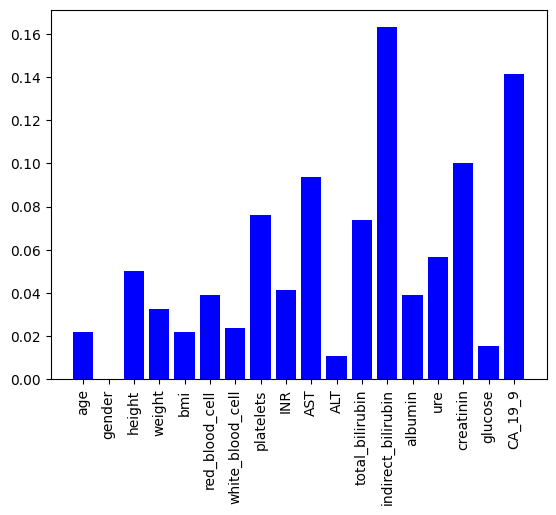

Fold 5: >acc=0.818, recall=1.000, precision=0.818, specificity=0.000, auc_roc=0.500, est=0.697, cfg={'n_estimators': 460, 'learning_rate': 0.19}
Fold 5: >acc=0.821, recall=0.882, precision=0.833, specificity=0.727, auc_roc=0.805, est=0.697, cfg={'n_estimators': 460, 'learning_rate': 0.19}


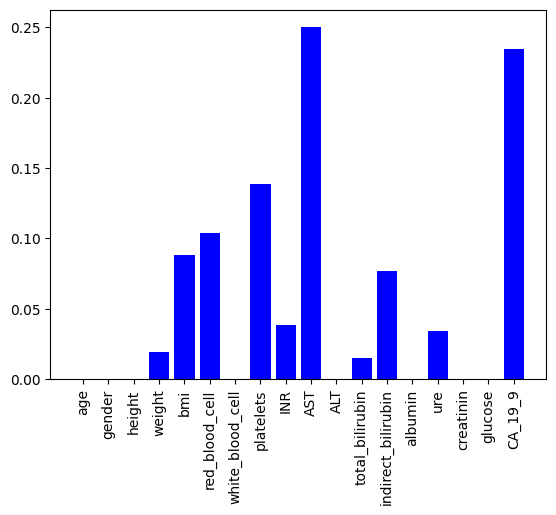

Fold 6: >acc=0.545, recall=0.600, precision=0.500, specificity=0.500, auc_roc=0.550, est=0.798, cfg={'n_estimators': 260, 'learning_rate': 0.02}
Fold 6: >acc=0.857, recall=0.941, precision=0.842, specificity=0.727, auc_roc=0.834, est=0.798, cfg={'n_estimators': 260, 'learning_rate': 0.02}


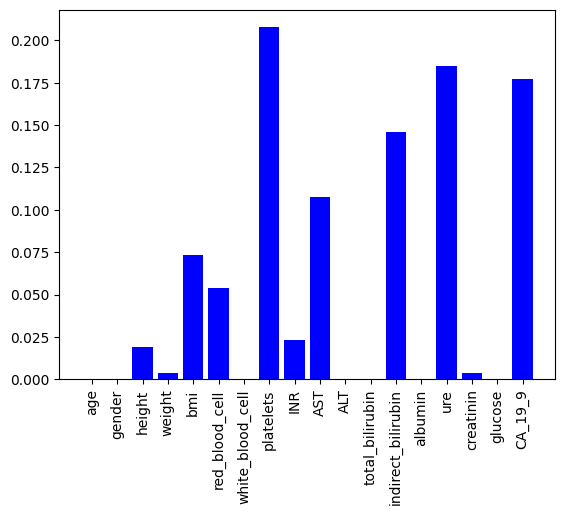

Fold 7: >acc=0.818, recall=0.875, precision=0.875, specificity=0.667, auc_roc=0.771, est=0.782, cfg={'n_estimators': 260, 'learning_rate': 0.02}
Fold 7: >acc=0.857, recall=0.882, precision=0.882, specificity=0.818, auc_roc=0.850, est=0.782, cfg={'n_estimators': 260, 'learning_rate': 0.02}


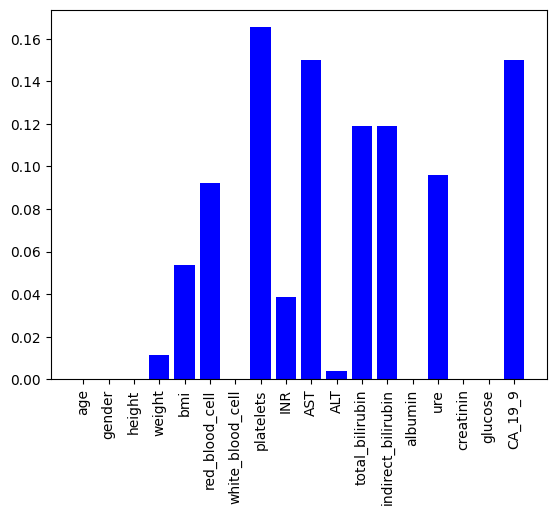

Fold 8: >acc=0.818, recall=0.857, precision=0.857, specificity=0.750, auc_roc=0.804, est=0.765, cfg={'n_estimators': 260, 'learning_rate': 0.02}
Fold 8: >acc=0.821, recall=0.824, precision=0.875, specificity=0.818, auc_roc=0.821, est=0.765, cfg={'n_estimators': 260, 'learning_rate': 0.02}


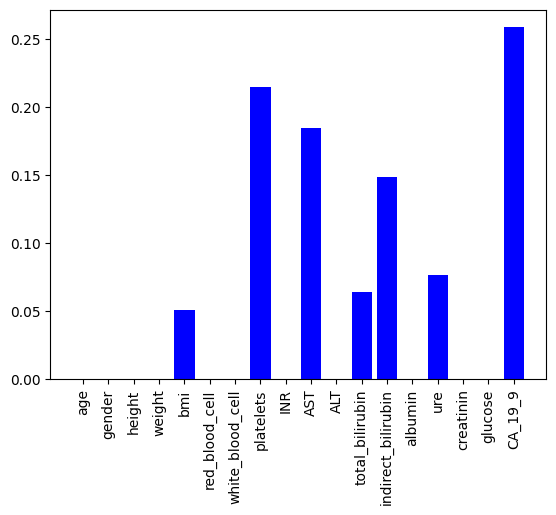

Fold 9: >acc=0.818, recall=0.857, precision=0.857, specificity=0.750, auc_roc=0.804, est=0.697, cfg={'n_estimators': 390, 'learning_rate': 0.01}
Fold 9: >acc=0.857, recall=0.882, precision=0.882, specificity=0.818, auc_roc=0.850, est=0.697, cfg={'n_estimators': 390, 'learning_rate': 0.01}


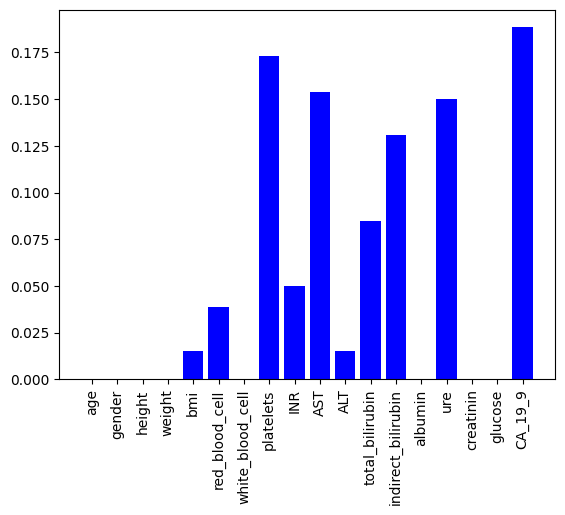

Fold 10: >acc=0.818, recall=1.000, precision=0.778, specificity=0.500, auc_roc=0.750, est=0.747, cfg={'n_estimators': 260, 'learning_rate': 0.02}
Fold 10: >acc=0.821, recall=0.882, precision=0.833, specificity=0.727, auc_roc=0.805, est=0.747, cfg={'n_estimators': 260, 'learning_rate': 0.02}
Result in Train
Accuracy: 0.782 (0.101)
Recall: 0.878 (0.111)
Precision: 0.771 (0.157)
Specificity: 0.594 (0.277)
AUROC: 0.736 (0.142)
Result in test
Accuracy: 0.825 (0.044)
Recall: 0.871 (0.035)
Precision: 0.847 (0.047)
Specificity: 0.755 (0.082)
AUROC: 0.813 (0.049)


In [ ]:
# enumerate splits
outer_results_acc_f = list()
outer_results_recall_f = list()
outer_results_precision_f = list()
outer_results_specificity_f  = list()
outer_results_auroc_f = list()

outer_results_acc = list()
outer_results_recall = list()
outer_results_precision = list()
outer_results_specificity  = list()
outer_results_auroc = list()


outer_models_ADA = list()

i = 1
for train_ix, test_ix in cv_outer.split(X_train):
    # split data
    X_train_f, X_test_f = X_train.iloc[train_ix, :], X_train.iloc[test_ix, :]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]
    # define the model
    model = AdaBoostClassifier(random_state=1)
    # define search space
    search_dict = {'n_estimators': [i for i in range(20, 500,10)],
                   'learning_rate': [i*0.01 for i in range(1,20)]
    }
    # define search
    search = HalvingRandomSearchCV(model, search_dict, scoring='accuracy', refit=True, random_state=1)
    # execute search
    result = search.fit(X_train_f, y_train_f)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    #get best feature
    get_best_feature(best_model,X_train_f)


    # evaluate model on the hold out dataset
    yhat_f = best_model.predict(X_test_f)
    # evaluate the model

    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f)
    # store the result
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)


    yhat = best_model.predict(X_test)
    # evaluate the model
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat)
    # store the result
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)


    outer_models_ADA.append(best_model)


    # report progress
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f, result.best_score_, result.best_params_))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc, recall, precision, specificity, auc_roc, result.best_score_, result.best_params_))


    i = i+1
# summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc_f), std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall_f), std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision_f), std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity_f), std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc_f), std(outer_results_auroc_f)))

print('Result in test')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc), std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity), std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc), std(outer_results_auroc)))

In [ ]:
# Result in Train
# Accuracy: 0.782 (0.101)
# Recall: 0.878 (0.111)
# Precision: 0.771 (0.157)
# Specificity: 0.594 (0.277)
# AUROC: 0.736 (0.142)
# Result in test
# Accuracy: 0.825 (0.044)
# Recall: 0.871 (0.035)
# Precision: 0.847 (0.047)
# Specificity: 0.755 (0.082)
# AUROC: 0.813 (0.049)

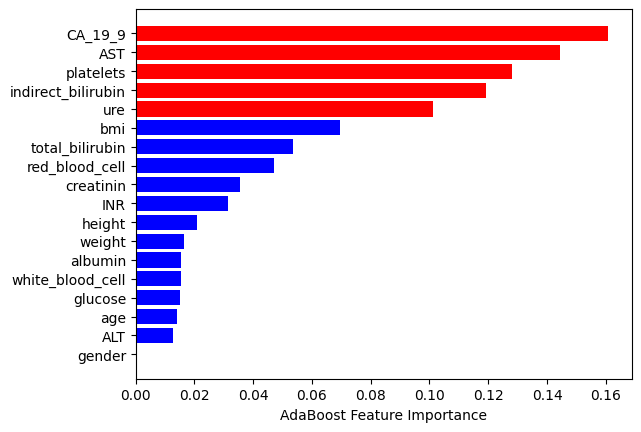

In [ ]:
get_mean_best_feature(outer_models_ADA,X,'AdaBoost','vdLiver')

##5.4 XG Boosts (XG)

In [ ]:
#er

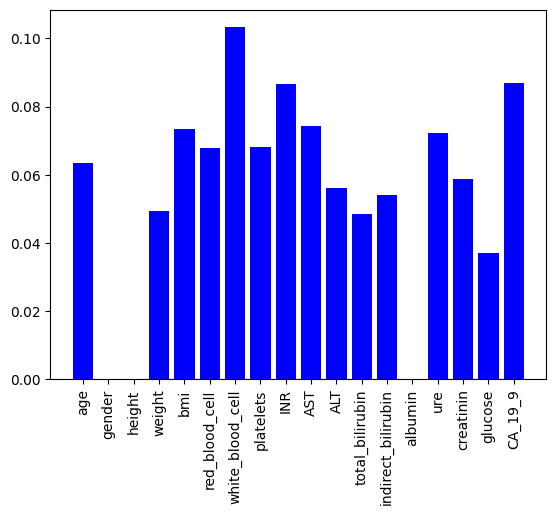

-------------------------------------------------------
[[4 3]
 [1 3]]
-------------------------------------------------------
[[16  1]
 [ 3  8]]
Fold 1: >acc=0.636, recall=0.571, precision=0.800, specificity=0.750, auc_roc=0.661, est=0.558, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 1: >acc=0.857, recall=0.941, precision=0.842, specificity=0.727, auc_roc=0.834, est=0.558, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


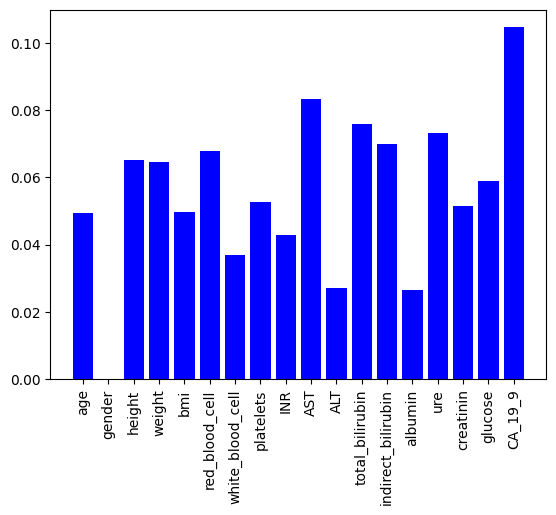

-------------------------------------------------------
[[2 0]
 [4 5]]
-------------------------------------------------------
[[16  1]
 [ 3  8]]
Fold 2: >acc=0.636, recall=1.000, precision=0.333, specificity=0.556, auc_roc=0.778, est=0.662, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 2: >acc=0.857, recall=0.941, precision=0.842, specificity=0.727, auc_roc=0.834, est=0.662, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


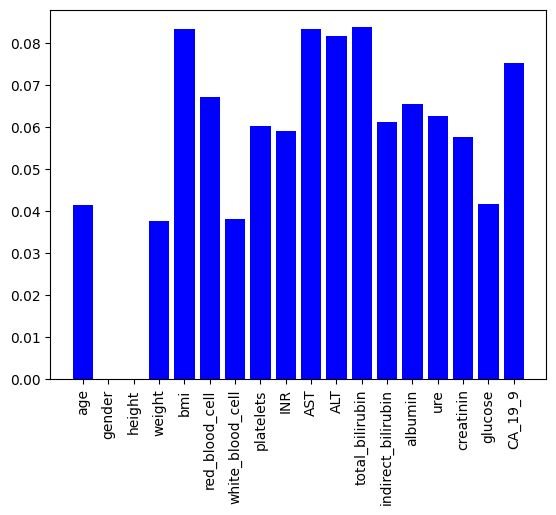

-------------------------------------------------------
[[6 2]
 [0 3]]
-------------------------------------------------------
[[16  1]
 [ 2  9]]
Fold 3: >acc=0.818, recall=0.750, precision=1.000, specificity=1.000, auc_roc=0.875, est=0.524, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 3: >acc=0.893, recall=0.941, precision=0.889, specificity=0.818, auc_roc=0.880, est=0.524, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


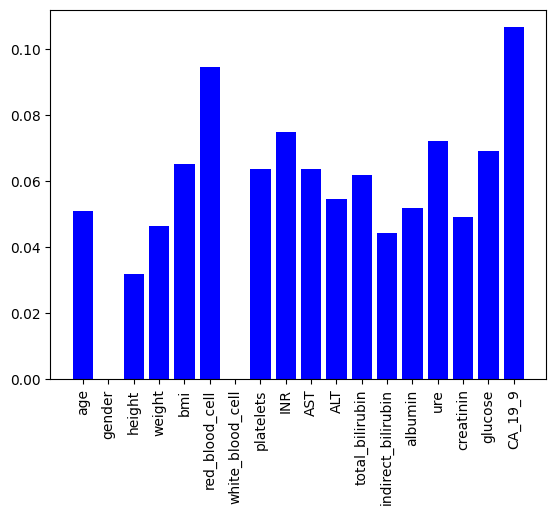

-------------------------------------------------------
[[7 0]
 [3 1]]
-------------------------------------------------------
[[16  1]
 [ 3  8]]
Fold 4: >acc=0.727, recall=1.000, precision=0.700, specificity=0.250, auc_roc=0.625, est=0.592, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 4: >acc=0.857, recall=0.941, precision=0.842, specificity=0.727, auc_roc=0.834, est=0.592, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


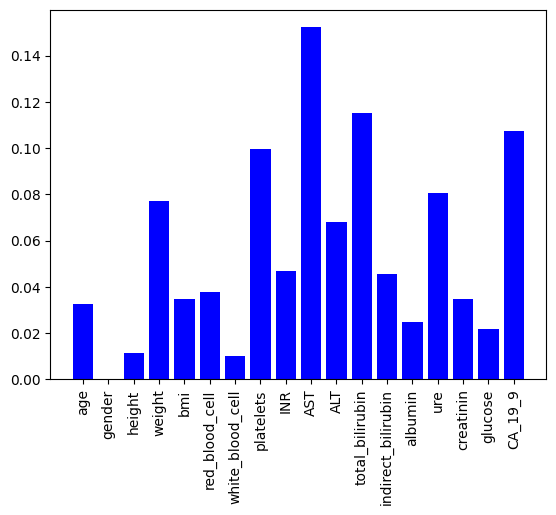

-------------------------------------------------------
[[9 0]
 [2 0]]
-------------------------------------------------------
[[16  1]
 [ 2  9]]
Fold 5: >acc=0.818, recall=1.000, precision=0.818, specificity=0.000, auc_roc=0.500, est=0.714, cfg={'booster': 'dart', 'colsample_bytree': 1.0, 'gamma': 0.07, 'learning_rate': 0.19, 'max_depth': 8, 'n_estimators': 230, 'reg_alpha': 0.37466616820236687, 'reg_lambda': 0.21397285495674168, 'scale_pos_weight': 0.30000000000000004, 'subsample': 0.8}
Fold 5: >acc=0.893, recall=0.941, precision=0.889, specificity=0.818, auc_roc=0.880, est=0.714, cfg={'booster': 'dart', 'colsample_bytree': 1.0, 'gamma': 0.07, 'learning_rate': 0.19, 'max_depth': 8, 'n_estimators': 230, 'reg_alpha': 0.37466616820236687, 'reg_lambda': 0.21397285495674168, 'scale_pos_weight': 0.30000000000000004, 'subsample': 0.8}


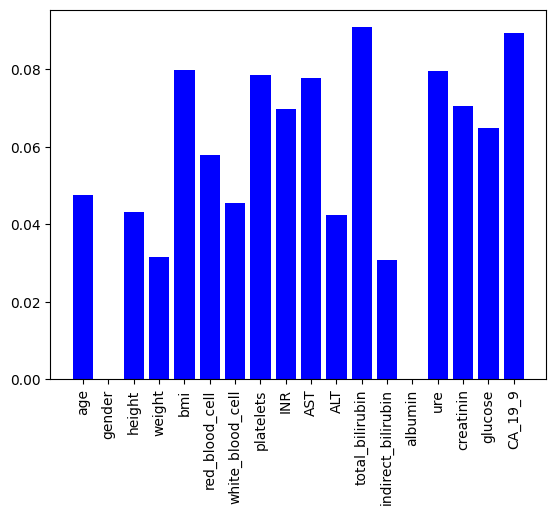

-------------------------------------------------------
[[2 3]
 [2 4]]
-------------------------------------------------------
[[16  1]
 [ 2  9]]
Fold 6: >acc=0.545, recall=0.400, precision=0.500, specificity=0.667, auc_roc=0.533, est=0.624, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 6: >acc=0.893, recall=0.941, precision=0.889, specificity=0.818, auc_roc=0.880, est=0.624, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


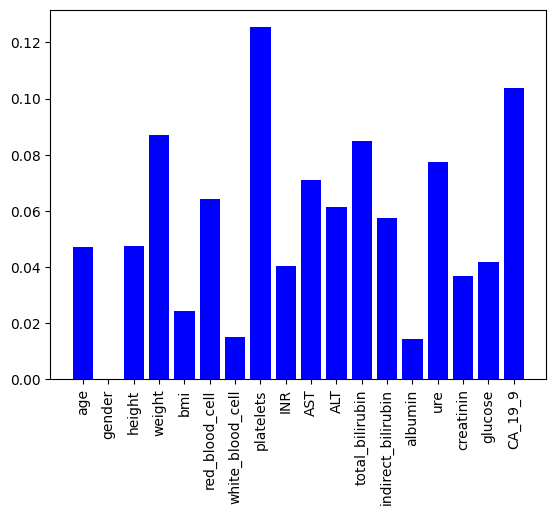

-------------------------------------------------------
[[6 2]
 [1 2]]
-------------------------------------------------------
[[11  6]
 [ 2  9]]
Fold 7: >acc=0.727, recall=0.750, precision=0.857, specificity=0.667, auc_roc=0.708, est=0.612, cfg={'booster': 'dart', 'colsample_bytree': 1.0, 'gamma': 0.07, 'learning_rate': 0.19, 'max_depth': 8, 'n_estimators': 230, 'reg_alpha': 0.37466616820236687, 'reg_lambda': 0.21397285495674168, 'scale_pos_weight': 0.30000000000000004, 'subsample': 0.8}
Fold 7: >acc=0.714, recall=0.647, precision=0.846, specificity=0.818, auc_roc=0.733, est=0.612, cfg={'booster': 'dart', 'colsample_bytree': 1.0, 'gamma': 0.07, 'learning_rate': 0.19, 'max_depth': 8, 'n_estimators': 230, 'reg_alpha': 0.37466616820236687, 'reg_lambda': 0.21397285495674168, 'scale_pos_weight': 0.30000000000000004, 'subsample': 0.8}


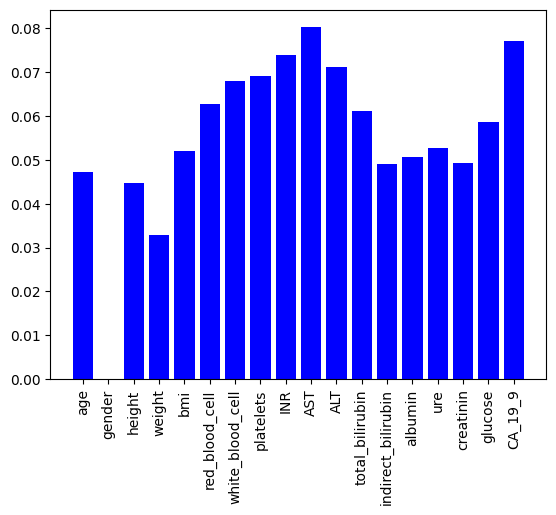

-------------------------------------------------------
[[5 2]
 [0 4]]
-------------------------------------------------------
[[14  3]
 [ 1 10]]
Fold 8: >acc=0.818, recall=0.714, precision=1.000, specificity=1.000, auc_roc=0.857, est=0.647, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 8: >acc=0.857, recall=0.824, precision=0.933, specificity=0.909, auc_roc=0.866, est=0.647, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


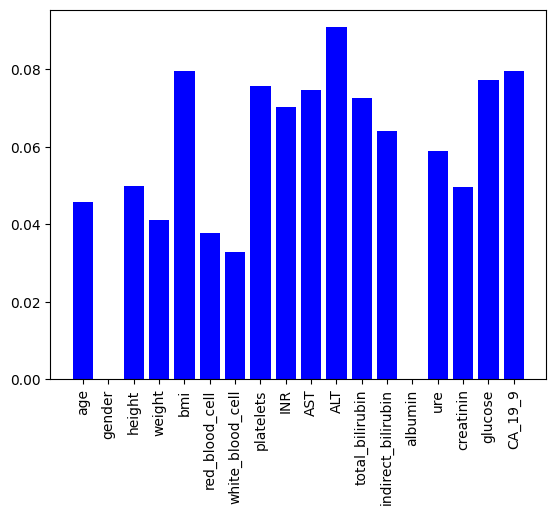

-------------------------------------------------------
[[7 0]
 [1 3]]
-------------------------------------------------------
[[15  2]
 [ 2  9]]
Fold 9: >acc=0.909, recall=1.000, precision=0.875, specificity=0.750, auc_roc=0.875, est=0.505, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 9: >acc=0.857, recall=0.882, precision=0.882, specificity=0.818, auc_roc=0.850, est=0.505, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


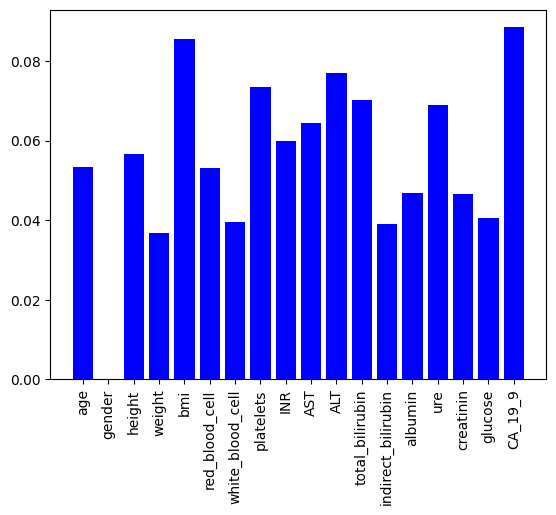

-------------------------------------------------------
[[4 3]
 [0 4]]
-------------------------------------------------------
[[13  4]
 [ 2  9]]
Fold 10: >acc=0.727, recall=0.571, precision=1.000, specificity=1.000, auc_roc=0.786, est=0.509, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 10: >acc=0.786, recall=0.765, precision=0.867, specificity=0.818, auc_roc=0.791, est=0.509, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Result in Train
Accuracy: 0.736 (0.103)
Recall: 0.776 (0.208)
Precision: 0.788 (0.211)
Specificity: 0.

In [ ]:
# enumerate splits
outer_results_acc_f = list()
outer_results_recall_f = list()
outer_results_precision_f = list()
outer_results_specificity_f  = list()
outer_results_auroc_f = list()

outer_results_acc = list()
outer_results_recall = list()
outer_results_precision = list()
outer_results_specificity  = list()
outer_results_auroc = list()


outer_models_XG = list()

i = 1
for train_ix, test_ix in cv_outer.split(X_train):
    # split data
    X_train_f, X_test_f = X_train.iloc[train_ix, :], X_train.iloc[test_ix, :]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]
    # define the model
    model = XGBClassifier(random_state=1)
    # define search space
    search_dict = {
                  'booster': ['gbtree', 'dart'],
                  'max_depth': [i for i in range(3, 20)],
                  'learning_rate': [i*0.01 for i in range(1,26)],
                  'n_estimators': [i for i in range(50,500,10)],
                  'colsample_bytree': [i*0.1 for i in range(5, 11)],
                  'subsample': [i*0.1 for i in range(6, 11)],
                  'gamma': [i*0.01 for i in range(1,20)],
                  'reg_alpha':  loguniform(0.01, 10),
                  'reg_lambda': loguniform(0.01, 10),
                  'scale_pos_weight': [i*0.1 for i in range(3,7)]

    }
    # define search
    search = HalvingRandomSearchCV(model, search_dict, scoring='accuracy', refit=True, random_state=1)
    # execute search
    result = search.fit(X_train_f, y_train_f)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    #get best feature
    get_best_feature(best_model,X_train_f)


    # evaluate model on the hold out dataset
    yhat_f = best_model.predict(X_test_f)
    # evaluate the model

    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f)
    # store the result
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)


    yhat = best_model.predict(X_test)
    # evaluate the model
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat)
    # store the result
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)


    outer_models_XG.append(best_model)


    # report progress
    # print('Confusion matrix')
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test_f, yhat_f, labels=[1,0]))
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test, yhat, labels=[1,0]))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f, result.best_score_, result.best_params_))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc, recall, precision, specificity, auc_roc, result.best_score_, result.best_params_))


    i = i+1
# summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc_f), std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall_f), std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision_f), std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity_f), std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc_f), std(outer_results_auroc_f)))

print('Result in test')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc), std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity), std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc), std(outer_results_auroc)))

In [ ]:
# Result in Train
# Accuracy: 0.736 (0.103)
# Recall: 0.776 (0.208)
# Precision: 0.788 (0.211)
# Specificity: 0.664 (0.313)
# AUROC: 0.720 (0.131)
# Result in test
# Accuracy: 0.846 (0.053)
# Recall: 0.876 (0.096)
# Precision: 0.872 (0.028)
# Specificity: 0.800 (0.055)
# AUROC: 0.838 (0.044)

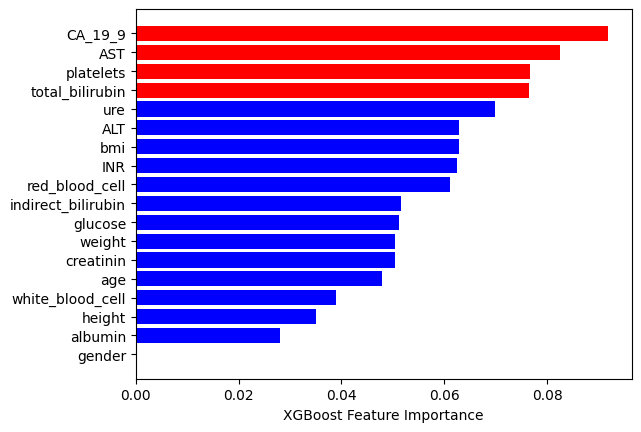

In [ ]:
get_mean_best_feature(outer_models_XG,X,'XGBoost','vdLiver')

##5.5 Convolutional neural networks (CNN)

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input
from sklearn.model_selection import StratifiedKFold

In [ ]:
def create_cnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define input shape based on the number of features
input_shape = X_train.shape[1:]

In [ ]:
# Define cross-validation strategy
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Lists to store evaluation results
outer_results_acc_f = []
outer_results_recall_f = []
outer_results_precision_f = []
outer_results_specificity_f = []
outer_results_auroc_f = []

outer_results_acc = []
outer_results_recall = []
outer_results_precision = []
outer_results_specificity = []
outer_results_auroc = []

outer_models_CNN = []

i = 1
for train_ix, test_ix in cv_outer.split(X_train, y_train):
    X_train_f, X_test_f = X_train.iloc[train_ix], X_train.iloc[test_ix]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]

    # Define and train the CNN model
    model = create_cnn_model(input_shape)
    model.fit(X_train_f, y_train_f, epochs=10, batch_size=32, verbose=0)  # Adjust epochs and batch size as needed

    # Evaluate model on the hold-out dataset
    yhat_f = model.predict(X_test_f)
    yhat_f_binary = np.round(yhat_f).flatten()

    # Evaluate the model
    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f_binary)

    # Store the results
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)

    yhat = model.predict(X_test)
    yhat_binary = np.round(yhat).flatten()

    # Evaluate the model on the test set
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat_binary)

    # Store the results
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)

    outer_models_CNN.append(model)

    # Report progress
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f' % (i, acc, recall, precision, specificity, auc_roc))

    i += 1

# Summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results_acc_f), np.std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (np.mean(outer_results_recall_f), np.std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (np.mean(outer_results_precision_f), np.std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (np.mean(outer_results_specificity_f), np.std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (np.mean(outer_results_auroc_f), np.std(outer_results_auroc_f)))

print('Result in Test')
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results_acc), np.std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (np.mean(outer_results_recall), np.std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (np.mean(outer_results_precision), np.std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (np.mean(outer_results_specificity), np.std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (np.mean(outer_results_auroc), np.std(outer_results_auroc)))


1/1 [==============================] - 0s 21ms/step
Fold 1: >acc=0.818, recall=1.000, precision=0.750, specificity=0.600, auc_roc=0.800
Fold 1: >acc=0.679, recall=0.824, precision=0.700, specificity=0.455, auc_roc=0.639
1/1 [==============================] - 0s 25ms/step
Fold 2: >acc=0.727, recall=1.000, precision=0.667, specificity=0.400, auc_roc=0.700
Fold 2: >acc=0.821, recall=1.000, precision=0.773, specificity=0.545, auc_roc=0.773
1/1 [==============================] - 0s 32ms/step
Fold 3: >acc=0.727, recall=1.000, precision=0.667, specificity=0.400, auc_roc=0.700
Fold 3: >acc=0.643, recall=0.941, precision=0.640, specificity=0.182, auc_roc=0.561
1/1 [==============================] - 0s 34ms/step
Fold 4: >acc=0.818, recall=1.000, precision=0.778, specificity=0.500, auc_roc=0.750
Fold 4: >acc=0.786, recall=0.941, precision=0.762, specificity=0.545, auc_roc=0.743


1/1 [==============================] - 0s 21ms/step
Fold 5: >acc=0.727, recall=0.857, precision=0.750, specificity=0.500, auc_roc=0.679
Fold 5: >acc=0.786, recall=0.941, precision=0.762, specificity=0.545, auc_roc=0.743


1/1 [==============================] - 0s 23ms/step
Fold 6: >acc=1.000, recall=1.000, precision=1.000, specificity=1.000, auc_roc=1.000
Fold 6: >acc=0.714, recall=1.000, precision=0.680, specificity=0.273, auc_roc=0.636
1/1 [==============================] - 0s 26ms/step
Fold 7: >acc=0.636, recall=0.714, precision=0.714, specificity=0.500, auc_roc=0.607
Fold 7: >acc=0.679, recall=0.824, precision=0.700, specificity=0.455, auc_roc=0.639
1/1 [==============================] - 0s 24ms/step
Fold 8: >acc=0.636, recall=0.857, precision=0.667, specificity=0.250, auc_roc=0.554
Fold 8: >acc=0.714, recall=0.882, precision=0.714, specificity=0.455, auc_roc=0.668
1/1 [==============================] - 0s 23ms/step
Fold 9: >acc=0.636, recall=0.714, precision=0.714, specificity=0.500, auc_roc=0.607
Fold 9: >acc=0.821, recall=0.941, precision=0.800, specificity=0.636, auc_roc=0.789
1/1 [==============================] - 0s 22ms/step
Fold 10: >acc=0.636, recall=0.857, precision=0.667, specificity=0.25

In [ ]:
# Result in Train
# Accuracy: 0.736 (0.111)
# Recall: 0.900 (0.112)
# Precision: 0.737 (0.096)
# Specificity: 0.490 (0.201)
# AUROC: 0.695 (0.128)
# Result in Test
# Accuracy: 0.743 (0.061)
# Recall: 0.929 (0.063)
# Precision: 0.727 (0.046)
# Specificity: 0.455 (0.129)
# AUROC: 0.692 (0.070)

In [ ]:
#CNN
# Result in Train
# Accuracy: 0.736 (0.103)
# Recall: 0.776 (0.208)
# Precision: 0.788 (0.211)
# Specificity: 0.664 (0.313)
# AUROC: 0.720 (0.131)
# Result in test
# Accuracy: 0.846 (0.053)
# Recall: 0.876 (0.096)
# Precision: 0.872 (0.028)
# Specificity: 0.800 (0.055)
# AUROC: 0.838 (0.044)

In [ ]:
#CNN 2
# Result in Train
# Accuracy: 0.700 (0.141)
# Recall: 0.900 (0.144)
# Precision: 0.709 (0.127)
# Specificity: 0.400 (0.276)
# AUROC: 0.650 (0.162)
# Result in Test
# Accuracy: 0.711 (0.052)
# Recall: 0.912 (0.054)
# Precision: 0.707 (0.055)
# Specificity: 0.400 (0.169)
# AUROC: 0.656 (0.070)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_mean_best_feature_CNN(models, X, model_name, data_name):
    mean_weights = []
    best_feature = X.columns
    for model in models:
        # Get weights of the first dense layer
        weights = model.layers[0].get_weights()[0]
        mean_weight = np.mean(np.abs(weights), axis=0)  # Calculate mean absolute weight for each feature
        mean_weights.append(mean_weight)
    mean_weights = np.array(mean_weights)
    mean_weights = np.mean(mean_weights, axis=0)
    sorted_idx = mean_weights.argsort()

    print("Shape of mean_weights:", mean_weights.shape)
    print("Content of mean_weights:", mean_weights)
    print("Sorted indices:", sorted_idx)

    # Plotting
    plt.barh(range(len(sorted_idx)), mean_weights[sorted_idx], color=['red' if weight >= 0.755 else 'blue' for weight in mean_weights[sorted_idx]])
    plt.xlabel(f"{model_name} Feature Importance")
    plt.savefig(f'get_mean_best_feature_{model_name}_{data_name}.svg', format='svg', dpi=150)
    plt.show()



Shape of mean_weights: (32,)
Content of mean_weights: [0.15758975 0.17953666 0.1706679  0.17835303 0.16432998 0.17534283
 0.17254774 0.16806285 0.17676078 0.16971251 0.17622235 0.17614402
 0.16135192 0.1606937  0.1720607  0.17051044 0.17270428 0.17768154
 0.18151847 0.18672866 0.18040374 0.17358832 0.17095621 0.16924058
 0.17362759 0.16942008 0.17883645 0.16198035 0.17880024 0.17009625
 0.18270794 0.17876038]
Sorted indices: [ 0 13 12 27  4  7 23 25  9 29 15  2 22 14  6 16 21 24  5 11 10  8 17  3
 31 28 26  1 20 18 30 19]


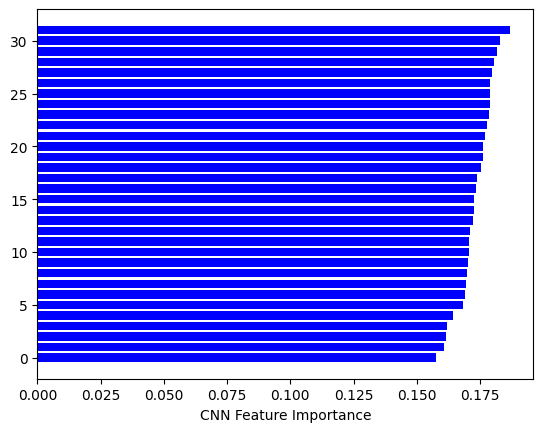

In [ ]:
get_mean_best_feature_CNN(outer_models_CNN, X_train_f, 'CNN', 'vdLiver')

##5.6. FCNN

In [ ]:
from tensorflow.keras.layers import Dropout

In [ ]:
def create_fcnn_model(input_shape):
    model = Sequential()
    model.add(Dense(64, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification, adjust if needed
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Assuming X_train, X_test, y_train, y_test are defined

# Define input shape based on the number of features
input_shape = X_train.shape[1:]
# Define cross-validation strategy
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Lists to store evaluation results
outer_results_acc_f = []
outer_results_recall_f = []
outer_results_precision_f = []
outer_results_specificity_f = []
outer_results_auroc_f = []

outer_results_acc = []
outer_results_recall = []
outer_results_precision = []
outer_results_specificity = []
outer_results_auroc = []

outer_models_FCNN = []

i = 1
for train_ix, test_ix in cv_outer.split(X_train, y_train):
    X_train_f, X_test_f = X_train.iloc[train_ix], X_train.iloc[test_ix]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]

    # Define and train the FCNN model
    model = create_fcnn_model(input_shape)
    model.fit(X_train_f, y_train_f, epochs=10, batch_size=32, verbose=0)  # Adjust epochs and batch size as needed

    # Evaluate model on the hold-out dataset
    yhat_f = model.predict(X_test_f)
    yhat_f_binary = np.round(yhat_f).flatten()

    # Evaluate the model
    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f_binary)

    # Store the results
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)

    yhat = model.predict(X_test)
    yhat_binary = np.round(yhat).flatten()

    # Evaluate the model on the test set
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat_binary)

    # Store the results
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)

    outer_models_FCNN.append(model)

    # Report progress
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f' % (i, acc, recall, precision, specificity, auc_roc))

    i += 1

# Summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results_acc_f), np.std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (np.mean(outer_results_recall_f), np.std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (np.mean(outer_results_precision_f), np.std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (np.mean(outer_results_specificity_f), np.std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (np.mean(outer_results_auroc_f), np.std(outer_results_auroc_f)))

print('Result in Test')
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results_acc), np.std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (np.mean(outer_results_recall), np.std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (np.mean(outer_results_precision), np.std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (np.mean(outer_results_specificity), np.std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (np.mean(outer_results_auroc), np.std(outer_results_auroc)))


In [ ]:
#FCNN
# Result in Train
# Accuracy: 0.709 (0.134)
# Recall: 0.898 (0.182)
# Precision: 0.716 (0.094)
# Specificity: 0.420 (0.257)
# AUROC: 0.659 (0.135)
# Result in Test
# Accuracy: 0.718 (0.063)
# Recall: 0.876 (0.085)
# Precision: 0.724 (0.060)
# Specificity: 0.473 (0.145)
# AUROC: 0.675 (0.071)

##5.6 DenseNet

In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout, concatenate
from tensorflow.keras.models import Model
from keras.optimizers import Adam

In [ ]:
def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = Dense(growth_rate, kernel_initializer='he_uniform', use_bias=False)(block_x)
        each_layer = BatchNormalization()(each_layer)
        each_layer = Activation('relu')(each_layer)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters

def dense_net(input_shape, classes, dense_block_size, layers_in_block, growth_rate):
    input_data = Input(shape=input_shape)
    x = input_data

    for block in range(dense_block_size):
        x, _ = dense_block(x, input_shape[0], growth_rate, layers_in_block)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(classes, activation='softmax')(x)

    return Model(input_data, x)

In [ ]:
# Define cross-validation strategy
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Lists to store evaluation results
outer_results_acc_f = []
outer_results_recall_f = []
outer_results_precision_f = []
outer_results_specificity_f = []
outer_results_auroc_f = []

outer_results_acc = []
outer_results_recall = []
outer_results_precision = []
outer_results_specificity = []
outer_results_auroc = []

outer_models_dense = []

i = 1
for train_ix, test_ix in cv_outer.split(X_train, y_train):
    X_train_f, X_test_f = X_train.iloc[train_ix], X_train.iloc[test_ix]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]

    # Convert integer labels to one-hot encoded labels
    y_train_f_one_hot = tf.keras.utils.to_categorical(y_train_f, 2)
    y_test_f_one_hot = tf.keras.utils.to_categorical(y_test_f, 2)

    # Define and train the DenseNet model
    model = dense_net(X_train_f.shape[1:], classes = 2, dense_block_size = 3, layers_in_block = 4, growth_rate = 32)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the model

    # Assuming you have one-hot encoded labels for y_train_f and y_test_f
    history = model.fit(X_train_f, y_train_f_one_hot, epochs=10, batch_size=32, verbose=0)

    # Evaluate model on the hold-out dataset
    yhat_f = model.predict(X_test_f)
    yhat_f_binary = np.round(yhat_f).argmax(axis=1)
    #yhat_f_binary = np.round(yhat_f).flatten()

    # Evaluate the model
    #acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f.argmax(axis=1), yhat_f_binary)
    #acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f.argmax(), yhat_f_binary)
    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f_binary)

    # Store the results
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)

    # Evaluate the model on the test set
    yhat = model.predict(X_test)
    yhat_binary = np.round(yhat).argmax(axis=1)

    # Evaluate the model on the test set
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat_binary)

    # Store the results
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)

    outer_models_dense.append(model)

    # Report progress
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f' % (i, acc, recall, precision, specificity, auc_roc))

    i += 1

# Summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results_acc_f), np.std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (np.mean(outer_results_recall_f), np.std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (np.mean(outer_results_precision_f), np.std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (np.mean(outer_results_specificity_f), np.std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (np.mean(outer_results_auroc_f), np.std(outer_results_auroc_f)))

print('Result in Test')
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results_acc), np.std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (np.mean(outer_results_recall), np.std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (np.mean(outer_results_precision), np.std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (np.mean(outer_results_specificity), np.std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (np.mean(outer_results_auroc), np.std(outer_results_auroc)))


In [ ]:
#Dense
# Result in Train
# Accuracy: 0.655 (0.127)
# Recall: 0.526 (0.181)
# Precision: 0.846 (0.154)
# Specificity: 0.860 (0.116)
# AUROC: 0.693 (0.108)
# Result in Test
# Accuracy: 0.639 (0.046)
# Recall: 0.476 (0.130)
# Precision: 0.897 (0.086)
# Specificity: 0.891 (0.098)
# AUROC: 0.684 (0.028)

In [ ]:
#Dense 2
# Result in Train
# Accuracy: 0.536 (0.138)
# Recall: 0.429 (0.236)
# Precision: 0.741 (0.223)
# Specificity: 0.735 (0.223)
# AUROC: 0.582 (0.123)
# Result in Test
# Accuracy: 0.600 (0.094)
# Recall: 0.453 (0.215)
# Precision: 0.842 (0.115)
# Specificity: 0.827 (0.138)
# AUROC: 0.640 (0.068)

#6 Feature sets

##6.1 Engineered Feature by XG

In [ ]:
X_train

age  gender    height    weight       bmi  red_blood_cell  \
102 -1.407937     0.0  1.487674  0.336273 -0.484384       -0.173037   
55   1.284799     0.0  0.406665  0.569895  0.422805        0.517552   
98   0.958406     0.0  0.406665 -1.065455 -1.464149       -1.554217   
4   -0.102368     0.0 -0.056624 -0.831834 -0.919835       -3.382248   
135  0.713612     0.0  1.178815  2.088433  1.584008       -0.159496   
..        ...     ...       ...       ...       ...             ...   
129 -0.755153     0.0  0.869955  1.270759  0.894544        0.355061   
79  -1.081545     0.0 -0.519914 -1.299076 -1.246424        0.761290   
133 -1.734330     0.0  2.414254 -0.831834 -2.117326       -0.728217   
72   0.632014     0.0  0.252235 -1.883130 -2.335051       -0.971955   
37   0.713612     0.0 -1.909783 -1.065455 -0.121508        0.097782   

     white_blood_cell  platelets       INR       AST       ALT  \
102          0.310608  -0.812908  1.889969  5.790621  2.003519   
55          -0.106610   0.806711 -0.645658 -0.557335 -0.473184   
98           2.082596   0.504382 -0.347349 -0.148185 -0.418201   
4            0.137693   1.432964 -0.322490 -0.162828 -0.373318   
135          0.058374  -0.542972 -0.347349 -0.570886 -0.417204   
..                ...        ...       ...       ...       ...   
129          0.139279   0.741927 -0.869390 -0.155616 -0.067610   
79          -0.795099  -0.413402  0.771310  0.192119  0.238845   
133         -0.612665  -0.381010  0.771310 -0.783767 -0.493506   
72           0.078997   1.260205 -0.943967 -0.782237 -0.618557   
37          -0.527000  -0.618554  0.845887 -0.602359 -0.489766   

     total_bilirubin  indirect_bilirubin   albumin       ure  creatinin  \
102         1.901451            1.354371 -0.514902 -0.564793  -0.610400   
55         -0.297829           -0.210266  0.462526  0.369605   0.507757   
98         -0.417254           -0.532115 -2.372015 -0.239686   0.236320   
4           3.187208            2.641770 -1.052487 -0.276062  -0.251861   
135        -0.324195           -0.259127  0.055264  0.005849   0.162239   
..               ...                 ...       ...       ...        ...   
129        -0.356766           -0.350477  1.081563  0.101335  -0.053926   
79         -0.316440           -0.232572  0.755754  0.194547  -0.052190   
133        -0.376928           -0.375970 -1.247973  0.103608  -1.259475   
72         -0.460681           -0.532115 -0.042479  0.506014  -0.641942   
37         -0.465334           -0.538489  0.723173  0.080874  -0.065791   

      glucose   CA_19_9  
102  0.054477  6.652663  
55   0.229827 -0.234758  
98  -0.254472 -0.216222  
4   -0.003973  4.319114  
135 -0.425646 -0.232088  
..        ...       ...  
129 -0.279521 -0.234359  
79  -0.688670 -0.234935  
133  0.150502 -0.232501  
72  -0.500796 -0.227110  
37  -0.484096 -0.234683  

[110 rows x 18 columns]

In [ ]:
strong_feature = ['platelets', 'total_bilirubin', 'indirect_bilirubin', 'AST','red_blood_cell']

In [ ]:
X_feature1 = X_train[strong_feature].copy()
X_test_feature1 = X_test[strong_feature].copy()

In [ ]:
# Ensure X_feature1 and y_train have the same number of samples
assert len(X_feature1) == len(y_train), "Number of samples in X_feature1 and y_train must match"

# Define the cross-validation strategy
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

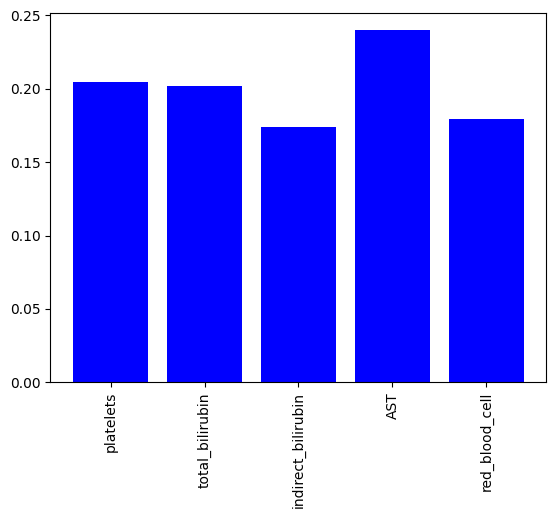

-------------------------------------------------------
[[10  3]
 [ 4  5]]
-------------------------------------------------------
[[13  4]
 [ 2  9]]
Fold 1: >acc=0.682, recall=0.769, precision=0.714, specificity=0.556, auc_roc=0.662, est=0.589, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 1: >acc=0.786, recall=0.765, precision=0.867, specificity=0.818, auc_roc=0.791, est=0.589, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


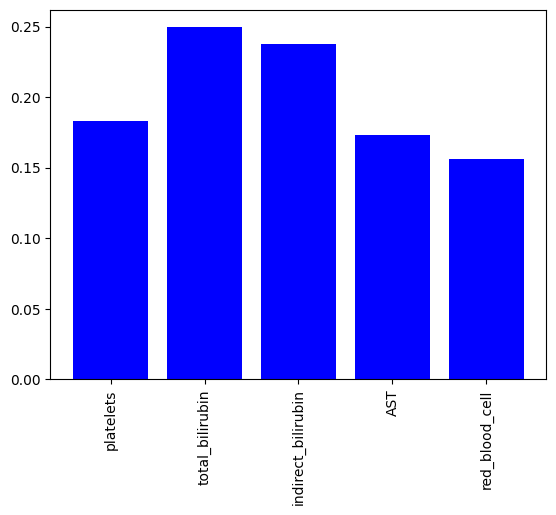

-------------------------------------------------------
[[10  3]
 [ 1  8]]
-------------------------------------------------------
[[13  4]
 [ 2  9]]
Fold 2: >acc=0.818, recall=0.769, precision=0.909, specificity=0.889, auc_roc=0.829, est=0.530, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 2: >acc=0.786, recall=0.765, precision=0.867, specificity=0.818, auc_roc=0.791, est=0.530, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


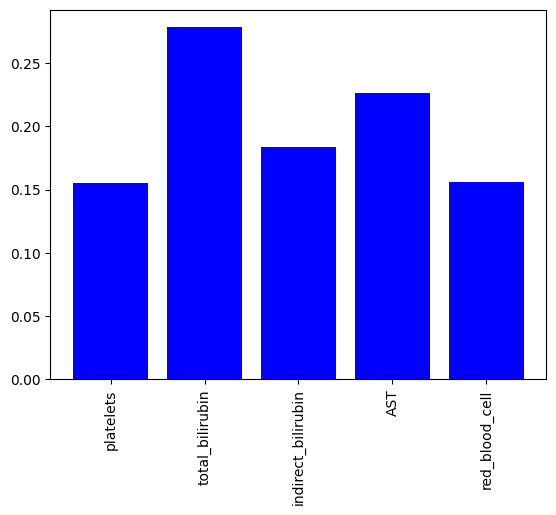

-------------------------------------------------------
[[11  2]
 [ 4  5]]
-------------------------------------------------------
[[14  3]
 [ 2  9]]
Fold 3: >acc=0.727, recall=0.846, precision=0.733, specificity=0.556, auc_roc=0.701, est=0.553, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 3: >acc=0.821, recall=0.824, precision=0.875, specificity=0.818, auc_roc=0.821, est=0.553, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


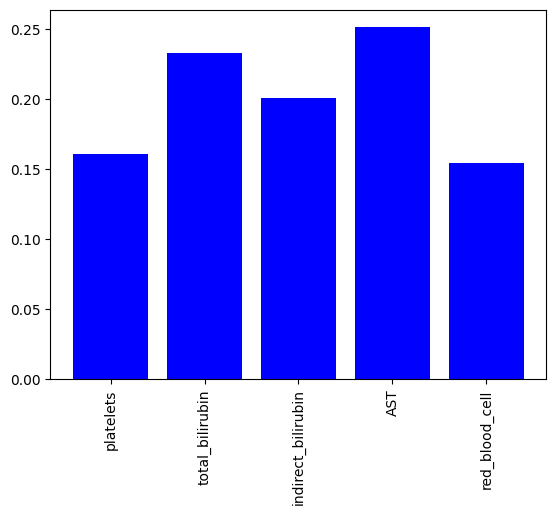

-------------------------------------------------------
[[ 4 10]
 [ 4  4]]
-------------------------------------------------------
[[10  7]
 [ 2  9]]
Fold 4: >acc=0.364, recall=0.286, precision=0.500, specificity=0.500, auc_roc=0.393, est=0.536, cfg={'booster': 'dart', 'colsample_bytree': 0.5, 'gamma': 0.18, 'learning_rate': 0.09, 'max_depth': 16, 'n_estimators': 470, 'reg_alpha': 4.3095062042610826, 'reg_lambda': 0.019726066891840952, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 4: >acc=0.679, recall=0.588, precision=0.833, specificity=0.818, auc_roc=0.703, est=0.536, cfg={'booster': 'dart', 'colsample_bytree': 0.5, 'gamma': 0.18, 'learning_rate': 0.09, 'max_depth': 16, 'n_estimators': 470, 'reg_alpha': 4.3095062042610826, 'reg_lambda': 0.019726066891840952, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


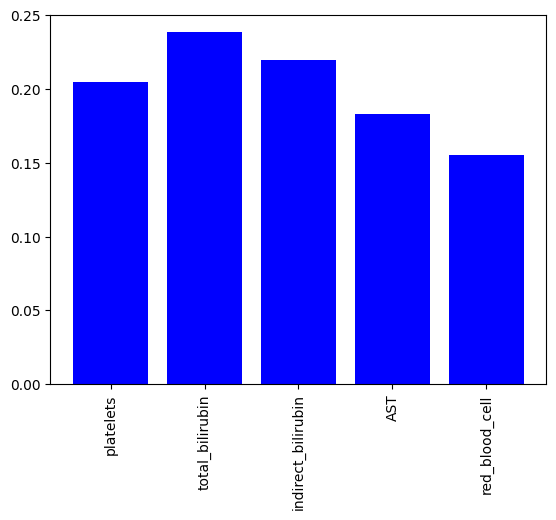

-------------------------------------------------------
[[10  4]
 [ 4  4]]
-------------------------------------------------------
[[14  3]
 [ 1 10]]
Fold 5: >acc=0.636, recall=0.714, precision=0.714, specificity=0.500, auc_roc=0.607, est=0.636, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 5: >acc=0.857, recall=0.824, precision=0.933, specificity=0.909, auc_roc=0.866, est=0.636, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Result in Train
Accuracy: 0.645 (0.153)
Recall: 0.677 (0.200)
Precision: 0.714 (0.130)
Specificity: 

In [ ]:
# enumerate splits
outer_results_acc_f = list()
outer_results_recall_f = list()
outer_results_precision_f = list()
outer_results_specificity_f  = list()
outer_results_auroc_f = list()

outer_results_acc = list()
outer_results_recall = list()
outer_results_precision = list()
outer_results_specificity  = list()
outer_results_auroc = list()


outer_models_XG_IF = list()

i = 1
for train_ix, test_ix in cv_outer.split(X_feature1, y_train):
    # split data
    X_train_f, X_test_f = X_feature1.iloc[train_ix, :], X_feature1.iloc[test_ix, :]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]
    # define the model
    model = XGBClassifier(random_state=1)
    # define search space
    search_dict = {
                  'booster': ['gbtree', 'dart'],
                  'max_depth': [i for i in range(3, 20)],
                  'learning_rate': [i*0.01 for i in range(1,26)],
                  'n_estimators': [i for i in range(50,500,10)],
                  'colsample_bytree': [i*0.1 for i in range(5, 11)],
                  'subsample': [i*0.1 for i in range(6, 11)],
                  'gamma': [i*0.01 for i in range(1,20)],
                  'reg_alpha':  loguniform(0.01, 10),
                  'reg_lambda': loguniform(0.01, 10),
                  'scale_pos_weight': [i*0.1 for i in range(3,7)]

    }
    # define search
    search = HalvingRandomSearchCV(model, search_dict, scoring='accuracy', refit=True, random_state=1)
    # execute search
    result = search.fit(X_train_f, y_train_f)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    #get best feature
    get_best_feature(best_model,X_train_f)


    # evaluate model on the hold out dataset
    yhat_f = best_model.predict(X_test_f)
    # evaluate the model

    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f)
    # store the result
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)


    yhat = best_model.predict(X_test_feature1)
    # evaluate the model
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat)
    # store the result
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)


    outer_models_XG_IF.append(best_model)


    # report progress
    # print('Confusion matrix')
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test_f, yhat_f, labels=[1,0]))
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test, yhat, labels=[1,0]))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f, result.best_score_, result.best_params_))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc, recall, precision, specificity, auc_roc, result.best_score_, result.best_params_))


    i = i+1
# summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc_f), std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall_f), std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision_f), std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity_f), std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc_f), std(outer_results_auroc_f)))

print('Result in test')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc), std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity), std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc), std(outer_results_auroc)))

In [ ]:
# Result in Train
# Accuracy: 0.645 (0.153)
# Recall: 0.677 (0.200)
# Precision: 0.714 (0.130)
# Specificity: 0.600 (0.147)
# AUROC: 0.638 (0.143)
# Result in test
# Accuracy: 0.786 (0.060)
# Recall: 0.753 (0.086)
# Precision: 0.875 (0.032)
# Specificity: 0.836 (0.036)
# AUROC: 0.795 (0.053)

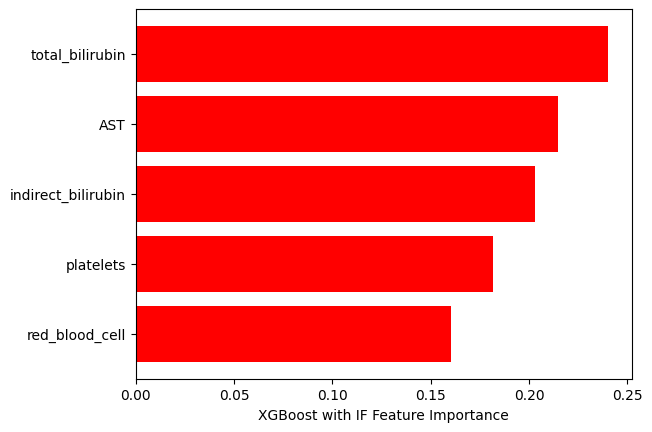

In [ ]:
get_mean_best_feature(outer_models_XG_IF,X_feature1,'XGBoost with IF','vdLiver')

In [ ]:
X_train

age  gender    height    weight       bmi  red_blood_cell  \
102 -1.407937     0.0  1.487674  0.336273 -0.484384       -0.173037   
55   1.284799     0.0  0.406665  0.569895  0.422805        0.517552   
98   0.958406     0.0  0.406665 -1.065455 -1.464149       -1.554217   
4   -0.102368     0.0 -0.056624 -0.831834 -0.919835       -3.382248   
135  0.713612     0.0  1.178815  2.088433  1.584008       -0.159496   
..        ...     ...       ...       ...       ...             ...   
129 -0.755153     0.0  0.869955  1.270759  0.894544        0.355061   
79  -1.081545     0.0 -0.519914 -1.299076 -1.246424        0.761290   
133 -1.734330     0.0  2.414254 -0.831834 -2.117326       -0.728217   
72   0.632014     0.0  0.252235 -1.883130 -2.335051       -0.971955   
37   0.713612     0.0 -1.909783 -1.065455 -0.121508        0.097782   

     white_blood_cell  platelets       INR       AST       ALT  \
102          0.310608  -0.812908  1.889969  5.790621  2.003519   
55          -0.106610   0.806711 -0.645658 -0.557335 -0.473184   
98           2.082596   0.504382 -0.347349 -0.148185 -0.418201   
4            0.137693   1.432964 -0.322490 -0.162828 -0.373318   
135          0.058374  -0.542972 -0.347349 -0.570886 -0.417204   
..                ...        ...       ...       ...       ...   
129          0.139279   0.741927 -0.869390 -0.155616 -0.067610   
79          -0.795099  -0.413402  0.771310  0.192119  0.238845   
133         -0.612665  -0.381010  0.771310 -0.783767 -0.493506   
72           0.078997   1.260205 -0.943967 -0.782237 -0.618557   
37          -0.527000  -0.618554  0.845887 -0.602359 -0.489766   

     total_bilirubin  indirect_bilirubin   albumin       ure  creatinin  \
102         1.901451            1.354371 -0.514902 -0.564793  -0.610400   
55         -0.297829           -0.210266  0.462526  0.369605   0.507757   
98         -0.417254           -0.532115 -2.372015 -0.239686   0.236320   
4           3.187208            2.641770 -1.052487 -0.276062  -0.251861   
135        -0.324195           -0.259127  0.055264  0.005849   0.162239   
..               ...                 ...       ...       ...        ...   
129        -0.356766           -0.350477  1.081563  0.101335  -0.053926   
79         -0.316440           -0.232572  0.755754  0.194547  -0.052190   
133        -0.376928           -0.375970 -1.247973  0.103608  -1.259475   
72         -0.460681           -0.532115 -0.042479  0.506014  -0.641942   
37         -0.465334           -0.538489  0.723173  0.080874  -0.065791   

      glucose   CA_19_9  
102  0.054477  6.652663  
55   0.229827 -0.234758  
98  -0.254472 -0.216222  
4   -0.003973  4.319114  
135 -0.425646 -0.232088  
..        ...       ...  
129 -0.279521 -0.234359  
79  -0.688670 -0.234935  
133  0.150502 -0.232501  
72  -0.500796 -0.227110  
37  -0.484096 -0.234683  

[110 rows x 18 columns]

##6.2 Recommended Feature

In [ ]:
feat2 = ['age', 'bmi', 'platelets','AST','ALT','albumin']

In [ ]:
X_train_recommended = X_train[feat2].copy()
X_test_recommended = X_test[feat2].copy()

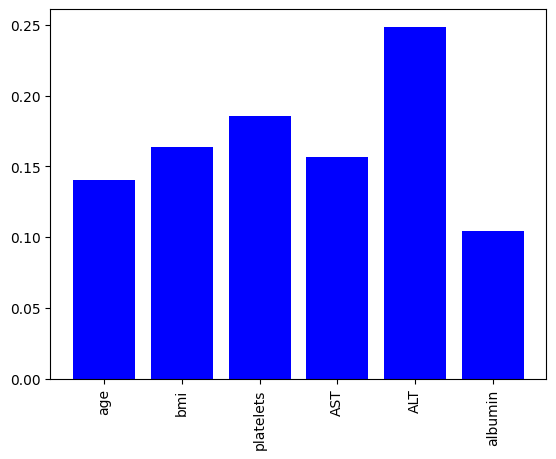

-------------------------------------------------------
[[7 6]
 [4 5]]
-------------------------------------------------------
[[13  4]
 [ 3  8]]
Fold 1: >acc=0.545, recall=0.538, precision=0.636, specificity=0.556, auc_roc=0.547, est=0.606, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 1: >acc=0.750, recall=0.765, precision=0.812, specificity=0.727, auc_roc=0.746, est=0.606, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


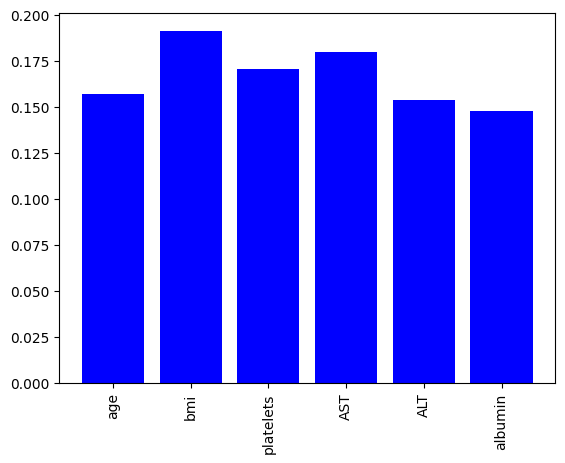

-------------------------------------------------------
[[9 4]
 [3 6]]
-------------------------------------------------------
[[13  4]
 [ 2  9]]
Fold 2: >acc=0.682, recall=0.692, precision=0.750, specificity=0.667, auc_roc=0.679, est=0.667, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 2: >acc=0.786, recall=0.765, precision=0.867, specificity=0.818, auc_roc=0.791, est=0.667, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


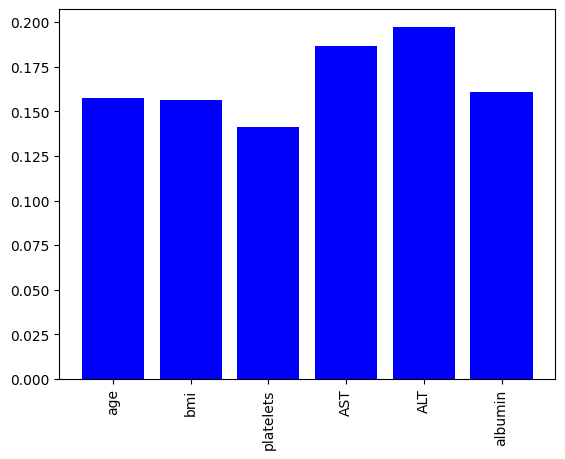

-------------------------------------------------------
[[11  2]
 [ 4  5]]
-------------------------------------------------------
[[14  3]
 [ 2  9]]
Fold 3: >acc=0.727, recall=0.846, precision=0.733, specificity=0.556, auc_roc=0.701, est=0.605, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 3: >acc=0.821, recall=0.824, precision=0.875, specificity=0.818, auc_roc=0.821, est=0.605, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


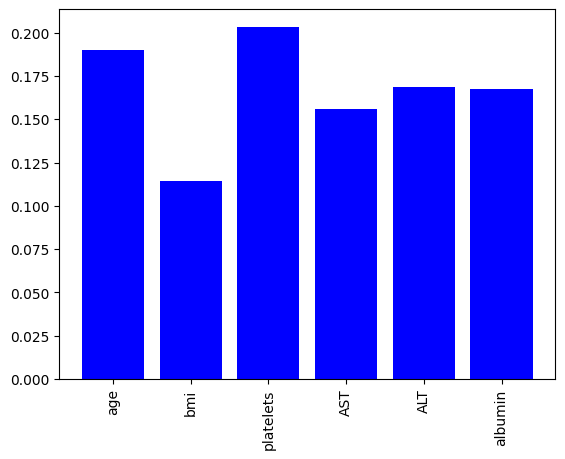

-------------------------------------------------------
[[8 6]
 [5 3]]
-------------------------------------------------------
[[12  5]
 [ 2  9]]
Fold 4: >acc=0.500, recall=0.571, precision=0.615, specificity=0.375, auc_roc=0.473, est=0.498, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 4: >acc=0.750, recall=0.706, precision=0.857, specificity=0.818, auc_roc=0.762, est=0.498, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


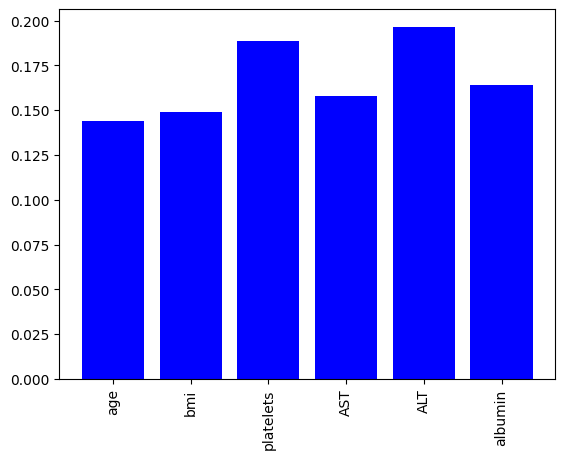

-------------------------------------------------------
[[8 6]
 [4 4]]
-------------------------------------------------------
[[12  5]
 [ 2  9]]
Fold 5: >acc=0.545, recall=0.571, precision=0.667, specificity=0.500, auc_roc=0.536, est=0.653, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 5: >acc=0.750, recall=0.706, precision=0.857, specificity=0.818, auc_roc=0.762, est=0.653, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Result in Train
Accuracy: 0.600 (0.088)
Recall: 0.644 (0.114)
Precision: 0.680 (0.053)
Specificity: 0.53

In [ ]:
# enumerate splits
outer_results_acc_f = list()
outer_results_recall_f = list()
outer_results_precision_f = list()
outer_results_specificity_f  = list()
outer_results_auroc_f = list()

outer_results_acc = list()
outer_results_recall = list()
outer_results_precision = list()
outer_results_specificity  = list()
outer_results_auroc = list()


outer_models_XG_IF = list()

i = 1
for train_ix, test_ix in cv_outer.split(X_train_recommended, y_train):
    # split data
    X_train_f, X_test_f = X_train_recommended.iloc[train_ix, :], X_train_recommended.iloc[test_ix, :]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]
    # define the model
    model = XGBClassifier(random_state=1)
    # define search space
    search_dict = {
                  'booster': ['gbtree', 'dart'],
                  'max_depth': [i for i in range(3, 20)],
                  'learning_rate': [i*0.01 for i in range(1,26)],
                  'n_estimators': [i for i in range(50,500,10)],
                  'colsample_bytree': [i*0.1 for i in range(5, 11)],
                  'subsample': [i*0.1 for i in range(6, 11)],
                  'gamma': [i*0.01 for i in range(1,20)],
                  'reg_alpha':  loguniform(0.01, 10),
                  'reg_lambda': loguniform(0.01, 10),
                  'scale_pos_weight': [i*0.1 for i in range(3,7)]

    }
    # define search
    search = HalvingRandomSearchCV(model, search_dict, scoring='accuracy', refit=True, random_state=1)
    # execute search
    result = search.fit(X_train_f, y_train_f)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    #get best feature
    get_best_feature(best_model,X_train_f)


    # evaluate model on the hold out dataset
    yhat_f = best_model.predict(X_test_f)
    # evaluate the model

    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f)
    # store the result
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)


    yhat = best_model.predict(X_test_recommended)
    # evaluate the model
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat)
    # store the result
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)


    outer_models_XG_IF.append(best_model)


    # report progress
    # print('Confusion matrix')
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test_f, yhat_f, labels=[1,0]))
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test, yhat, labels=[1,0]))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f, result.best_score_, result.best_params_))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc, recall, precision, specificity, auc_roc, result.best_score_, result.best_params_))


    i = i+1
# summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc_f), std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall_f), std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision_f), std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity_f), std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc_f), std(outer_results_auroc_f)))

print('Result in test')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc), std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity), std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc), std(outer_results_auroc)))

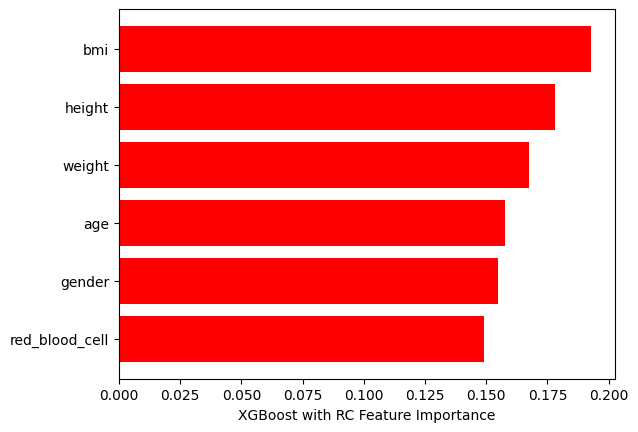

In [ ]:
get_mean_best_feature(outer_models_XG_IF,X,'XGBoost with RC','vdLiver')

##### RC 5 BALT

In [ ]:
X_train_recommended1.head(5)

APRI   AST/ALT     FIB-4       NFS      BARD
102  6.046330  0.428965  2.455019  0.009235  0.260694
55  -0.634141  0.128986 -0.499545  0.041866  1.284847
98  -0.366376  0.980502  0.094480  0.743033  1.284847
4   -0.507305  0.579798 -0.566147 -0.968941  0.260694
135 -0.438439 -0.277960 -0.160932  0.277934  0.260694

In [ ]:
X_test_recommended1.head(5)

APRI   AST/ALT     FIB-4       NFS      BARD
35  0.542107  0.042265  0.350169 -0.024569  0.260694
33 -0.433935 -0.746825 -0.629637 -0.541929 -1.787613
77 -0.005918  0.702793  0.347402  0.088213  0.260694
5  -0.713904  0.631426 -0.562966 -0.046136  0.260694
19  3.196077 -0.086297  1.363172 -0.443729  0.260694

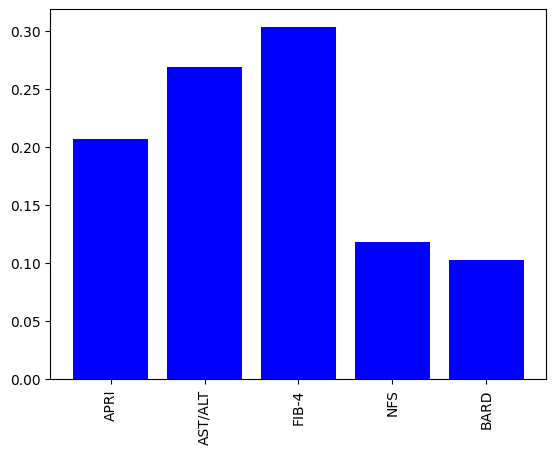

-------------------------------------------------------
[[9 4]
 [5 4]]
-------------------------------------------------------
[[9 8]
 [2 9]]
Fold 1: >acc=0.591, recall=0.692, precision=0.643, specificity=0.444, auc_roc=0.568, est=0.588, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 1: >acc=0.643, recall=0.529, precision=0.818, specificity=0.818, auc_roc=0.674, est=0.588, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


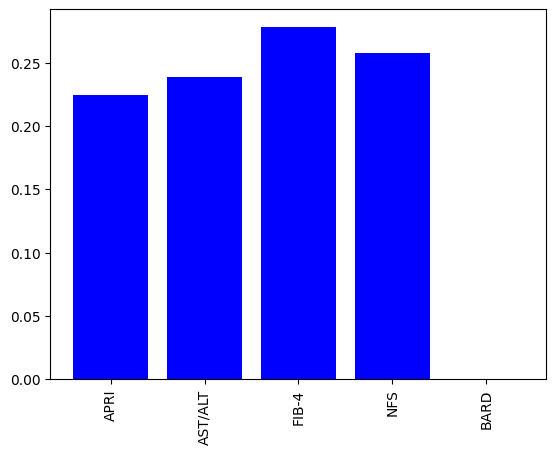

-------------------------------------------------------
[[10  3]
 [ 3  6]]
-------------------------------------------------------
[[11  6]
 [ 2  9]]
Fold 2: >acc=0.727, recall=0.769, precision=0.769, specificity=0.667, auc_roc=0.718, est=0.570, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 2: >acc=0.714, recall=0.647, precision=0.846, specificity=0.818, auc_roc=0.733, est=0.570, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


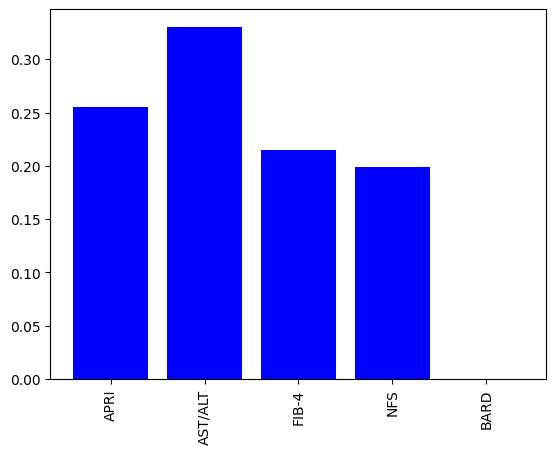

-------------------------------------------------------
[[9 4]
 [0 9]]
-------------------------------------------------------
[[9 8]
 [2 9]]
Fold 3: >acc=0.818, recall=0.692, precision=1.000, specificity=1.000, auc_roc=0.846, est=0.589, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 3: >acc=0.643, recall=0.529, precision=0.818, specificity=0.818, auc_roc=0.674, est=0.589, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


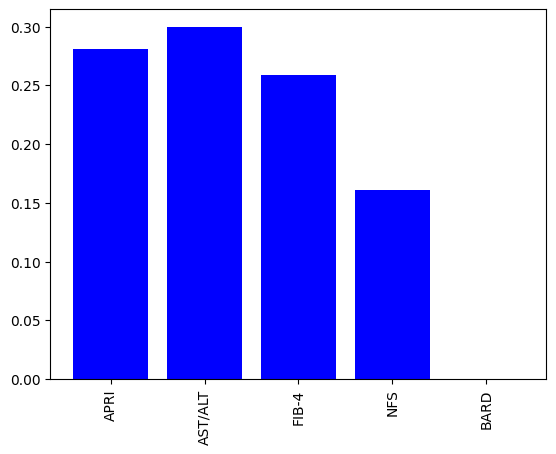

-------------------------------------------------------
[[9 5]
 [4 4]]
-------------------------------------------------------
[[10  7]
 [ 2  9]]
Fold 4: >acc=0.591, recall=0.643, precision=0.692, specificity=0.500, auc_roc=0.571, est=0.655, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 4: >acc=0.679, recall=0.588, precision=0.833, specificity=0.818, auc_roc=0.703, est=0.655, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


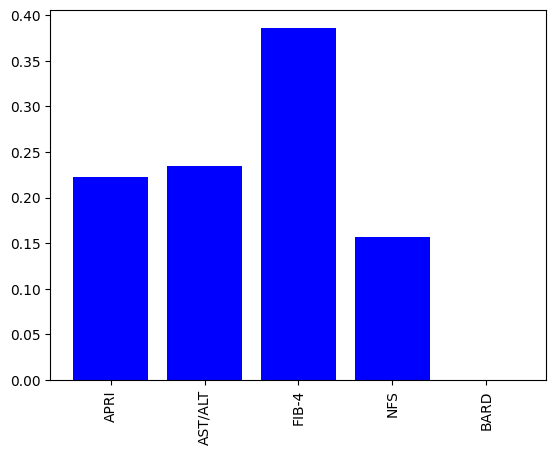

-------------------------------------------------------
[[7 7]
 [4 4]]
-------------------------------------------------------
[[8 9]
 [2 9]]
Fold 5: >acc=0.500, recall=0.500, precision=0.636, specificity=0.500, auc_roc=0.500, est=0.583, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 5: >acc=0.607, recall=0.471, precision=0.800, specificity=0.818, auc_roc=0.644, est=0.583, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Result in Train
Accuracy: 0.645 (0.113)
Recall: 0.659 (0.089)
Precision: 0.748 (0.135)
Specificity: 0.622 (0

In [ ]:
# enumerate splits
outer_results_acc_f = list()
outer_results_recall_f = list()
outer_results_precision_f = list()
outer_results_specificity_f  = list()
outer_results_auroc_f = list()

outer_results_acc = list()
outer_results_recall = list()
outer_results_precision = list()
outer_results_specificity  = list()
outer_results_auroc = list()


outer_models_XG_IF = list()

i = 1
for train_ix, test_ix in cv_outer.split(X_train_recommended1, y_train):
    # split data
    X_train_f, X_test_f = X_train_recommended1.iloc[train_ix, :], X_train_recommended1.iloc[test_ix, :]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]
    # define the model
    model = XGBClassifier(random_state=1)
    # define search space
    search_dict = {
                  'booster': ['gbtree', 'dart'],
                  'max_depth': [i for i in range(3, 20)],
                  'learning_rate': [i*0.01 for i in range(1,26)],
                  'n_estimators': [i for i in range(50,500,10)],
                  'colsample_bytree': [i*0.1 for i in range(5, 11)],
                  'subsample': [i*0.1 for i in range(6, 11)],
                  'gamma': [i*0.01 for i in range(1,20)],
                  'reg_alpha':  loguniform(0.01, 10),
                  'reg_lambda': loguniform(0.01, 10),
                  'scale_pos_weight': [i*0.1 for i in range(3,7)]

    }
    # define search
    search = HalvingRandomSearchCV(model, search_dict, scoring='accuracy', refit=True, random_state=1)
    # execute search
    result = search.fit(X_train_f, y_train_f)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    #get best feature
    get_best_feature(best_model,X_train_f)


    # evaluate model on the hold out dataset
    yhat_f = best_model.predict(X_test_f)
    # evaluate the model

    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f)
    # store the result
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)


    yhat = best_model.predict(X_test_recommended1)
    # evaluate the model
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat)
    # store the result
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)


    outer_models_XG_IF.append(best_model)


    # report progress
    # print('Confusion matrix')
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test_f, yhat_f, labels=[1,0]))
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test, yhat, labels=[1,0]))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f, result.best_score_, result.best_params_))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc, recall, precision, specificity, auc_roc, result.best_score_, result.best_params_))


    i = i+1
# summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc_f), std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall_f), std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision_f), std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity_f), std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc_f), std(outer_results_auroc_f)))

print('Result in test')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc), std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity), std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc), std(outer_results_auroc)))

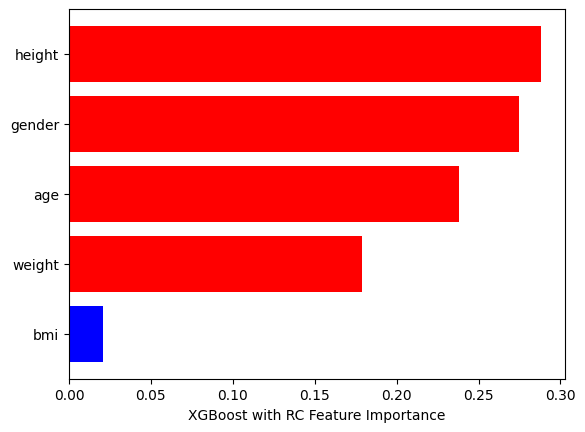

In [ ]:
get_mean_best_feature(outer_models_XG_IF,X,'XGBoost with RC','vdLiver')

##6.3 Combine Feature

In [ ]:
strong_feature

['platelets', 'total_bilirubin', 'indirect_bilirubin', 'AST', 'red_blood_cell']

In [ ]:
feat2

['age', 'bmi', 'platelets', 'AST', 'ALT', 'albumin']

In [ ]:
feat3 = ['platelets', 'total_bilirubin', 'indirect_bilirubin', 'AST', 'red_blood_cell', 'age', 'bmi','ALT', 'albumin']
X_train_combine = X_train[feat3].copy()
X_test_combine = X_test[feat3].copy()

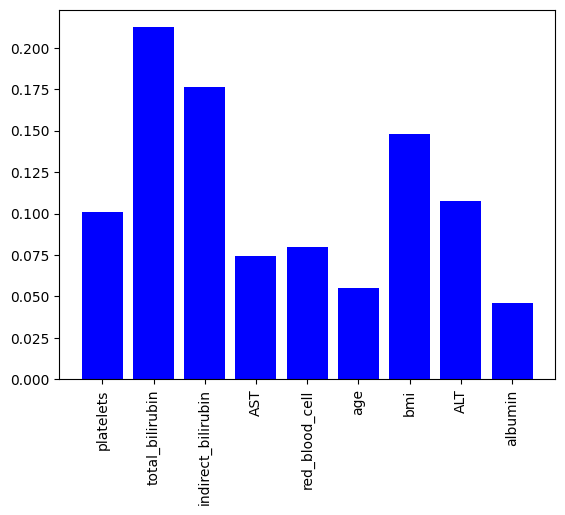

-------------------------------------------------------
[[7 6]
 [4 5]]
-------------------------------------------------------
[[12  5]
 [ 2  9]]
Fold 1: >acc=0.545, recall=0.538, precision=0.636, specificity=0.556, auc_roc=0.547, est=0.556, cfg={'booster': 'dart', 'colsample_bytree': 0.5, 'gamma': 0.18, 'learning_rate': 0.09, 'max_depth': 16, 'n_estimators': 470, 'reg_alpha': 4.3095062042610826, 'reg_lambda': 0.019726066891840952, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 1: >acc=0.750, recall=0.706, precision=0.857, specificity=0.818, auc_roc=0.762, est=0.556, cfg={'booster': 'dart', 'colsample_bytree': 0.5, 'gamma': 0.18, 'learning_rate': 0.09, 'max_depth': 16, 'n_estimators': 470, 'reg_alpha': 4.3095062042610826, 'reg_lambda': 0.019726066891840952, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


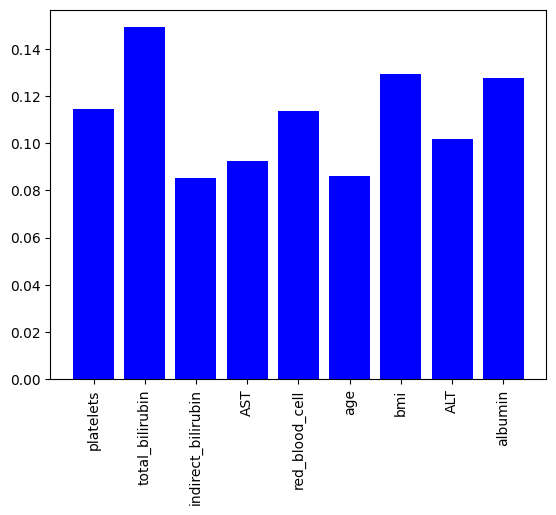

-------------------------------------------------------
[[10  3]
 [ 1  8]]
-------------------------------------------------------
[[12  5]
 [ 2  9]]
Fold 2: >acc=0.818, recall=0.769, precision=0.909, specificity=0.889, auc_roc=0.829, est=0.670, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 2: >acc=0.750, recall=0.706, precision=0.857, specificity=0.818, auc_roc=0.762, est=0.670, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


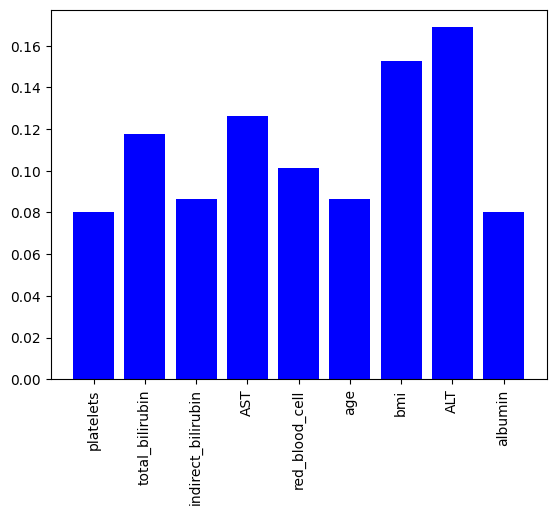

-------------------------------------------------------
[[12  1]
 [ 3  6]]
-------------------------------------------------------
[[13  4]
 [ 2  9]]
Fold 3: >acc=0.818, recall=0.923, precision=0.800, specificity=0.667, auc_roc=0.795, est=0.623, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 3: >acc=0.786, recall=0.765, precision=0.867, specificity=0.818, auc_roc=0.791, est=0.623, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


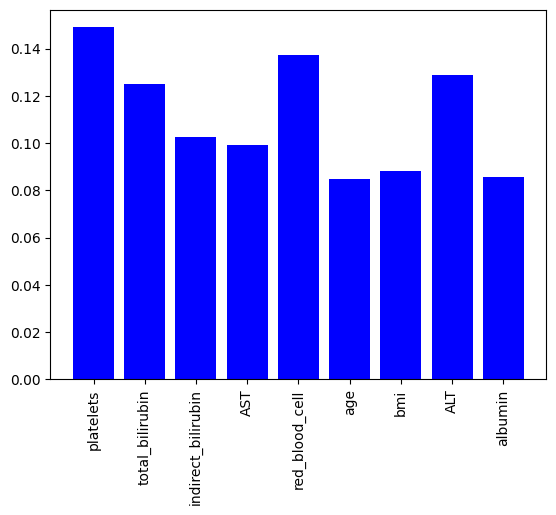

-------------------------------------------------------
[[9 5]
 [4 4]]
-------------------------------------------------------
[[14  3]
 [ 1 10]]
Fold 4: >acc=0.591, recall=0.643, precision=0.692, specificity=0.500, auc_roc=0.571, est=0.565, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 4: >acc=0.857, recall=0.824, precision=0.933, specificity=0.909, auc_roc=0.866, est=0.565, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


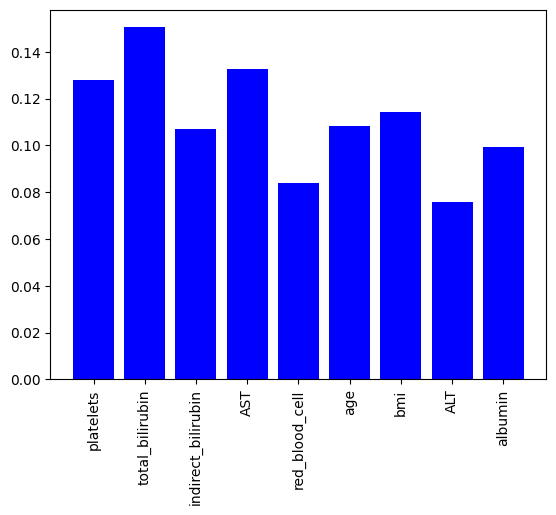

-------------------------------------------------------
[[11  3]
 [ 4  4]]
-------------------------------------------------------
[[12  5]
 [ 2  9]]
Fold 5: >acc=0.682, recall=0.786, precision=0.733, specificity=0.500, auc_roc=0.643, est=0.602, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 5: >acc=0.750, recall=0.706, precision=0.857, specificity=0.818, auc_roc=0.762, est=0.602, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Result in Train
Accuracy: 0.691 (0.113)
Recall: 0.732 (0.131)
Precision: 0.754 (0.094)
Specificity: 

In [ ]:
# enumerate splits
outer_results_acc_f = list()
outer_results_recall_f = list()
outer_results_precision_f = list()
outer_results_specificity_f  = list()
outer_results_auroc_f = list()

outer_results_acc = list()
outer_results_recall = list()
outer_results_precision = list()
outer_results_specificity  = list()
outer_results_auroc = list()


outer_models_XG_IF = list()

i = 1
for train_ix, test_ix in cv_outer.split(X_train_combine, y_train):
    # split data
    X_train_f, X_test_f = X_train_combine.iloc[train_ix, :], X_train_combine.iloc[test_ix, :]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]
    # define the model
    model = XGBClassifier(random_state=1)
    # define search space
    search_dict = {
                  'booster': ['gbtree', 'dart'],
                  'max_depth': [i for i in range(3, 20)],
                  'learning_rate': [i*0.01 for i in range(1,26)],
                  'n_estimators': [i for i in range(50,500,10)],
                  'colsample_bytree': [i*0.1 for i in range(5, 11)],
                  'subsample': [i*0.1 for i in range(6, 11)],
                  'gamma': [i*0.01 for i in range(1,20)],
                  'reg_alpha':  loguniform(0.01, 10),
                  'reg_lambda': loguniform(0.01, 10),
                  'scale_pos_weight': [i*0.1 for i in range(3,7)]

    }
    # define search
    search = HalvingRandomSearchCV(model, search_dict, scoring='accuracy', refit=True, random_state=1)
    # execute search
    result = search.fit(X_train_f, y_train_f)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    #get best feature
    get_best_feature(best_model,X_train_f)


    # evaluate model on the hold out dataset
    yhat_f = best_model.predict(X_test_f)
    # evaluate the model

    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f)
    # store the result
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)


    yhat = best_model.predict(X_test_combine)
    # evaluate the model
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat)
    # store the result
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)


    outer_models_XG_IF.append(best_model)


    # report progress
    # print('Confusion matrix')
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test_f, yhat_f, labels=[1,0]))
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test, yhat, labels=[1,0]))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f, result.best_score_, result.best_params_))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc, recall, precision, specificity, auc_roc, result.best_score_, result.best_params_))


    i = i+1
# summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc_f), std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall_f), std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision_f), std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity_f), std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc_f), std(outer_results_auroc_f)))

print('Result in test')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc), std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity), std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc), std(outer_results_auroc)))

In [ ]:
feat3 = ['total_bilirubin','indirect_bilirubin', 'red_blood_cell']

In [ ]:
 X_train_combine1 = pd.concat([X_train[feat3], X_train_recommended1], axis=1)
 X_test_combine1 = pd.concat([X_test[feat3], X_test_recommended1], axis=1)

In [ ]:
X_train_combine1.head(5)

total_bilirubin  indirect_bilirubin  red_blood_cell      APRI   AST/ALT  \
102         1.901451            1.354371       -0.173037  6.046330  0.428965   
55         -0.297829           -0.210266        0.517552 -0.634141  0.128986   
98         -0.417254           -0.532115       -1.554217 -0.366376  0.980502   
4           3.187208            2.641770       -3.382248 -0.507305  0.579798   
135        -0.324195           -0.259127       -0.159496 -0.438439 -0.277960   

        FIB-4       NFS      BARD  
102  2.455019  0.009235  0.260694  
55  -0.499545  0.041866  1.284847  
98   0.094480  0.743033  1.284847  
4   -0.566147 -0.968941  0.260694  
135 -0.160932  0.277934  0.260694

In [ ]:
X_test_combine1.head(5)

total_bilirubin  indirect_bilirubin  red_blood_cell      APRI   AST/ALT  \
35        -0.375377           -0.433330        1.397716  0.542107  0.042265   
33        -0.234239           -0.272936        0.151946 -0.433935 -0.746825   
77        -0.372275           -0.417397        0.395684 -0.005918  0.702793   
5         -0.397091           -0.433330       -1.703167 -0.713904  0.631426   
19         1.481137            0.229490       -0.267824  3.196077 -0.086297   

       FIB-4       NFS      BARD  
35  0.350169 -0.024569  0.260694  
33 -0.629637 -0.541929 -1.787613  
77  0.347402  0.088213  0.260694  
5  -0.562966 -0.046136  0.260694  
19  1.363172 -0.443729  0.260694

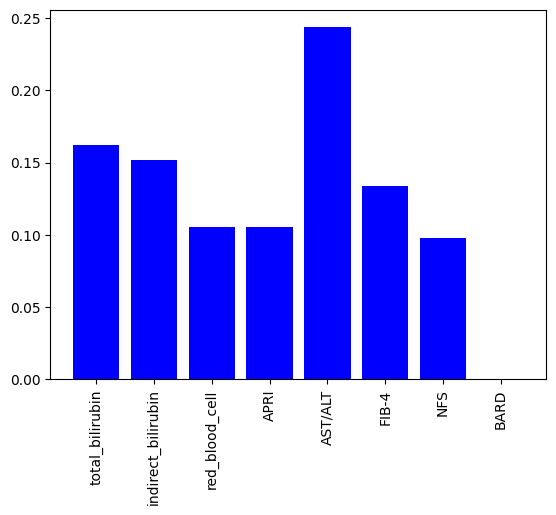

-------------------------------------------------------
[[10  3]
 [ 5  4]]
-------------------------------------------------------
[[11  6]
 [ 2  9]]
Fold 1: >acc=0.636, recall=0.769, precision=0.667, specificity=0.444, auc_roc=0.607, est=0.641, cfg={'booster': 'dart', 'colsample_bytree': 0.5, 'gamma': 0.18, 'learning_rate': 0.09, 'max_depth': 16, 'n_estimators': 470, 'reg_alpha': 4.3095062042610826, 'reg_lambda': 0.019726066891840952, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 1: >acc=0.714, recall=0.647, precision=0.846, specificity=0.818, auc_roc=0.733, est=0.641, cfg={'booster': 'dart', 'colsample_bytree': 0.5, 'gamma': 0.18, 'learning_rate': 0.09, 'max_depth': 16, 'n_estimators': 470, 'reg_alpha': 4.3095062042610826, 'reg_lambda': 0.019726066891840952, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


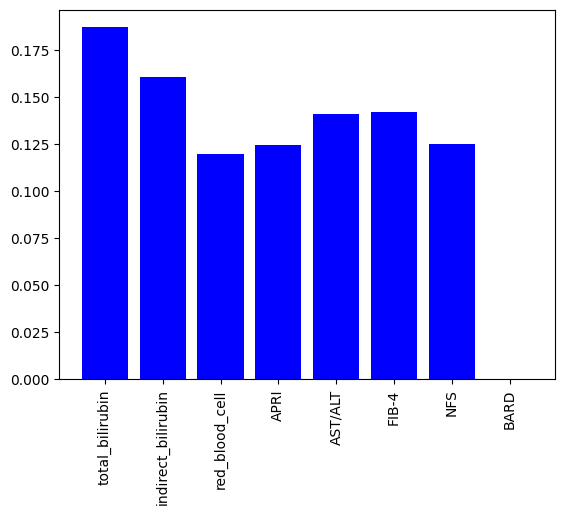

-------------------------------------------------------
[[10  3]
 [ 3  6]]
-------------------------------------------------------
[[11  6]
 [ 2  9]]
Fold 2: >acc=0.727, recall=0.769, precision=0.769, specificity=0.667, auc_roc=0.718, est=0.570, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 2: >acc=0.714, recall=0.647, precision=0.846, specificity=0.818, auc_roc=0.733, est=0.570, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


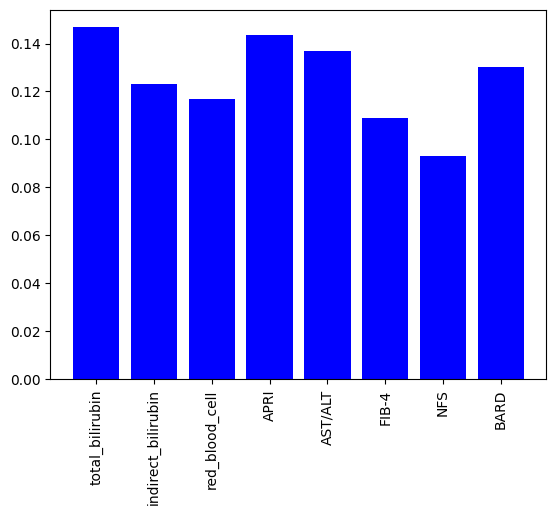

-------------------------------------------------------
[[11  2]
 [ 1  8]]
-------------------------------------------------------
[[12  5]
 [ 4  7]]
Fold 3: >acc=0.864, recall=0.846, precision=0.917, specificity=0.889, auc_roc=0.868, est=0.589, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 3: >acc=0.679, recall=0.706, precision=0.750, specificity=0.636, auc_roc=0.671, est=0.589, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


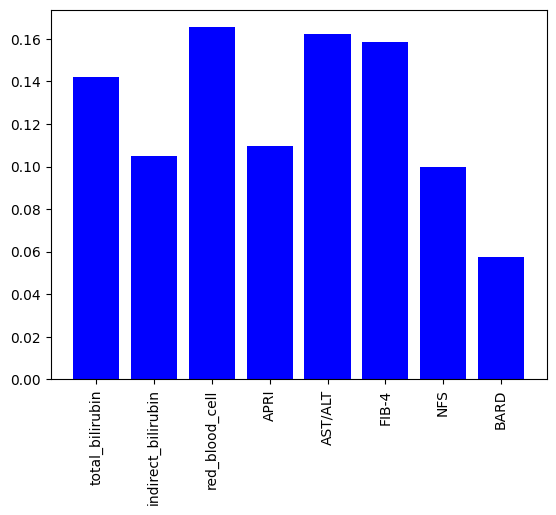

-------------------------------------------------------
[[9 5]
 [5 3]]
-------------------------------------------------------
[[11  6]
 [ 3  8]]
Fold 4: >acc=0.545, recall=0.643, precision=0.643, specificity=0.375, auc_roc=0.509, est=0.671, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 4: >acc=0.679, recall=0.647, precision=0.786, specificity=0.727, auc_roc=0.687, est=0.671, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}


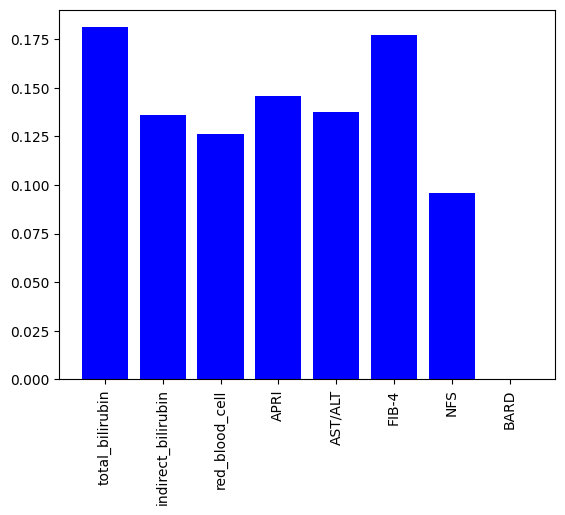

-------------------------------------------------------
[[9 5]
 [4 4]]
-------------------------------------------------------
[[10  7]
 [ 3  8]]
Fold 5: >acc=0.591, recall=0.643, precision=0.692, specificity=0.500, auc_roc=0.571, est=0.605, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 5: >acc=0.643, recall=0.588, precision=0.769, specificity=0.727, auc_roc=0.658, est=0.605, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Result in Train
Accuracy: 0.673 (0.113)
Recall: 0.734 (0.080)
Precision: 0.738 (0.099)
Specificity: 0.57

In [ ]:
# enumerate splits
outer_results_acc_f = list()
outer_results_recall_f = list()
outer_results_precision_f = list()
outer_results_specificity_f  = list()
outer_results_auroc_f = list()

outer_results_acc = list()
outer_results_recall = list()
outer_results_precision = list()
outer_results_specificity  = list()
outer_results_auroc = list()


outer_models_XG_IF = list()

i = 1
for train_ix, test_ix in cv_outer.split(X_train_combine1, y_train):
    # split data
    X_train_f, X_test_f = X_train_combine1.iloc[train_ix, :], X_train_combine1.iloc[test_ix, :]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]
    # define the model
    model = XGBClassifier(random_state=1)
    # define search space
    search_dict = {
                  'booster': ['gbtree', 'dart'],
                  'max_depth': [i for i in range(3, 20)],
                  'learning_rate': [i*0.01 for i in range(1,26)],
                  'n_estimators': [i for i in range(50,500,10)],
                  'colsample_bytree': [i*0.1 for i in range(5, 11)],
                  'subsample': [i*0.1 for i in range(6, 11)],
                  'gamma': [i*0.01 for i in range(1,20)],
                  'reg_alpha':  loguniform(0.01, 10),
                  'reg_lambda': loguniform(0.01, 10),
                  'scale_pos_weight': [i*0.1 for i in range(3,7)]

    }
    # define search
    search = HalvingRandomSearchCV(model, search_dict, scoring='accuracy', refit=True, random_state=1)
    # execute search
    result = search.fit(X_train_f, y_train_f)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    #get best feature
    get_best_feature(best_model,X_train_f)


    # evaluate model on the hold out dataset
    yhat_f = best_model.predict(X_test_f)
    # evaluate the model

    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f)
    # store the result
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)


    yhat = best_model.predict(X_test_combine1)
    # evaluate the model
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat)
    # store the result
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)


    outer_models_XG_IF.append(best_model)


    # report progress
    # print('Confusion matrix')
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test_f, yhat_f, labels=[1,0]))
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test, yhat, labels=[1,0]))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f, result.best_score_, result.best_params_))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc, recall, precision, specificity, auc_roc, result.best_score_, result.best_params_))


    i = i+1
# summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc_f), std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall_f), std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision_f), std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity_f), std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc_f), std(outer_results_auroc_f)))

print('Result in test')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc), std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity), std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc), std(outer_results_auroc)))

In [ ]:
!pip install scikit-optimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
from numpy import mean, std
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
# from skopt import HalvingRandomSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import loguniform
from sklearn.model_selection import StratifiedKFold

# Define cross-validation strategy
cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Lists to store evaluation results
outer_results_acc_f = []
outer_results_recall_f = []
outer_results_precision_f = []
outer_results_specificity_f = []
outer_results_auroc_f = []

outer_results_acc = []
outer_results_recall = []
outer_results_precision = []
outer_results_specificity = []
outer_results_auroc = []

outer_models_XG_IF = []

i = 1
for train_ix, test_ix in cv_outer.split(X_feature1, y_train):
    # split data
    X_train_f, X_test_f = X_feature1.iloc[train_ix, :], X_feature1.iloc[test_ix, :]
    y_train_f, y_test_f = y_train.iloc[train_ix], y_train.iloc[test_ix]
    # define the model
    model = XGBClassifier(random_state=1)
    # define search space
    search_dict = {
        'booster': ['gbtree', 'dart'],
        'max_depth': [i for i in range(3, 20)],
        'learning_rate': [i*0.01 for i in range(1, 26)],
        'n_estimators': [i for i in range(50, 500, 10)],
        'colsample_bytree': [i*0.1 for i in range(5, 11)],
        'subsample': [i*0.1 for i in range(6, 11)],
        'gamma': [i*0.01 for i in range(1, 20)],
        'reg_alpha': loguniform(0.01, 10),
        'reg_lambda': loguniform(0.01, 10),
        'scale_pos_weight': [i*0.1 for i in range(3, 7)]
    }
    # define search
    search = HalvingRandomSearchCV(model, search_dict, scoring='accuracy', refit=True, random_state=1)
    # execute search
    result = search.fit(X_train_f, y_train_f)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_

    # evaluate model on the hold out dataset
    yhat_f = best_model.predict(X_test_f)
    # evaluate the model
    acc_f, recall_f, precision_f, specificity_f, auc_roc_f = get_metrics(y_test_f, yhat_f)
    # store the result
    outer_results_acc_f.append(acc_f)
    outer_results_recall_f.append(recall_f)
    outer_results_precision_f.append(precision_f)
    outer_results_specificity_f.append(specificity_f)
    outer_results_auroc_f.append(auc_roc_f)

    yhat = best_model.predict(X_test_feature1)
    # evaluate the model
    acc, recall, precision, specificity, auc_roc = get_metrics(y_test, yhat)
    # store the result
    outer_results_acc.append(acc)
    outer_results_recall.append(recall)
    outer_results_precision.append(precision)
    outer_results_specificity.append(specificity)
    outer_results_auroc.append(auc_roc)

    outer_models_XG_IF.append(best_model)

    # report progress
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test_f, yhat_f, labels=[1,0]))
    print('-------------------------------------------------------')
    print(confusion_matrix(y_test, yhat, labels=[1,0]))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc_f, recall_f, precision_f, specificity_f, auc_roc_f, result.best_score_, result.best_params_))
    print('Fold %d: >acc=%.3f, recall=%.3f, precision=%.3f, specificity=%.3f, auc_roc=%.3f, est=%.3f, cfg=%s' % (i, acc, recall, precision, specificity, auc_roc, result.best_score_, result.best_params_))

    i = i + 1

# summarize the estimated performance of the model
print('Result in Train')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc_f), std(outer_results_acc_f)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall_f), std(outer_results_recall_f)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision_f), std(outer_results_precision_f)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity_f), std(outer_results_specificity_f)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc_f), std(outer_results_auroc_f)))

print('Result in Test')
print('Accuracy: %.3f (%.3f)' % (mean(outer_results_acc), std(outer_results_acc)))
print('Recall: %.3f (%.3f)' % (mean(outer_results_recall), std(outer_results_recall)))
print('Precision: %.3f (%.3f)' % (mean(outer_results_precision), std(outer_results_precision)))
print('Specificity: %.3f (%.3f)' % (mean(outer_results_specificity), std(outer_results_specificity)))
print('AUROC: %.3f (%.3f)' % (mean(outer_results_auroc), std(outer_results_auroc)))


-------------------------------------------------------
[[6 0]
 [2 3]]
-------------------------------------------------------
[[12  5]
 [ 2  9]]
Fold 1: >acc=0.818, recall=1.000, precision=0.750, specificity=0.600, auc_roc=0.800, est=0.608, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
Fold 1: >acc=0.750, recall=0.706, precision=0.857, specificity=0.818, auc_roc=0.762, est=0.608, cfg={'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'gamma': 0.18, 'learning_rate': 0.24, 'max_depth': 3, 'n_estimators': 270, 'reg_alpha': 2.5248390936171003, 'reg_lambda': 8.03127925811908, 'scale_pos_weight': 0.6000000000000001, 'subsample': 0.7000000000000001}
-------------------------------------------------------
[[3 3]
 [1 4]]
---------------------------------